In [1]:
import torch, os
import torch.nn as nn
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
# from train_model import train_model
# from test_model import test_model
%matplotlib inline
import pickle


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
filePath = '/local/rcs/ll3504/datasets/256_ObjectCategories/'
namelist = os.listdir(filePath)
nameDic_cal = {}
for name in namelist:
    splits = name.split(".")
    nameDic_cal[int(splits[0])-1] = splits[1]
print(nameDic_cal[1])

american-flag


In [4]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    # No holdout testing data. train and test data are the same, but different transformation
    data_transforms = {
        'train': transforms.Compose([
#             transforms.Resize([256, 256]),
#             transforms.RandomCrop(224),
#             transforms.RandomRotation(20),
#             transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
#             transforms.Resize([224, 224]),
#             transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])
#     print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
#     print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset

In [5]:
def split_dataset(train_dataset, test_dataset, valid_size=0.2, batch_size=128, train_size = 128):
    '''
    This function splits dataset into train, val, and test sets, and return train, val, test dataloaders.
    Val and Test loaders are the same

    '''
    
    # what does the len function gives?
    num_train = len(train_dataset)
    # print("DEBUGGING: overall training data size =", num_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx = indices[split:split+train_size], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # print("DEBUGGING: the train_ind are:", len(train_idx))


    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = train_sampler)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = valid_sampler)
    dataloaders = {'train': train_loader,
                   'val': test_loader,
                   'test': test_loader}
    dataset_sizes ={'train': train_size, #int(np.floor((1-valid_size) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [6]:
imagebase = '/local/rcs/ll3504/datasets/'

In [7]:
corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']

# ImageNetC

In [8]:
def get_imagenetc(imagebase, severity=1, batch_size=128, sample_size = 128):
    '''
    Returns:
        ref_dataloaders:          ImageNet original validation data, as a reference
        ref_dataset_sizes:        1000, not the sizes of the real dataset in the ref_loader, probs used downstream
        corrupted_dataloaders:    A list of corrupted dataloaders, each element in a list represetns the data loaders
                                  for one corruption type. Each element contains ['train']['val']['test'] loaders
        corrupted_dataset_sizes:  A list of dictionaries of the sizes of each loaders for each corruption
        corruption:               A list of corruption names, in the same order of the corrupted_dataloaders
    '''
    corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']
    corrupted_dataloaders = []
    corrupted_dataset_sizes = []
    
    # this is the imageNet validation data
    imagenet_val = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None)#, download=False)
    
    # TODO: subsample some size of ImageNet training data as source
        # Doesn't need this step
#     print("DEBUGGING: imagenet_val size is:", len(imagenet_val))
    
    random_indices = random.sample(range(0, len(imagenet_val)), int(len(imagenet_val)*0.02))
#     print("DEBUGGING: random indices are:", len(random_indices))
    imagenet_val_subset = data.Subset(imagenet_val, random_indices)
    val_loader = torch.utils.data.DataLoader(imagenet_val_subset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=48)
    ref_dataloaders = { 'val': val_loader,
                       'test': val_loader}
    ref_dataset_sizes ={'val': int(len(val_loader.dataset)),
                        'test': int(len(val_loader.dataset))}
    
    # for every type of corruption, go to the specified severity folder
    for corr in corruption:
        dataset_name = 'imagenetc/' + corr + '/' + str(severity)
        # Get dataset from folder
        corr_trian_images, corr_test_images = get_dataset(imagebase, dataset_name)
        # get corruption-specific train, val, test loader
        # train: training data, non-overlap with val/test
        # val: non-overlap with train, same as test
        # test: non-overlap with train, same as test
        corr_dataloaders, corr_dataset_sizes = split_dataset(corr_trian_images, corr_test_images, valid_size=0.02, batch_size=batch_size, train_size=sample_size)
        corrupted_dataloaders.append(corr_dataloaders)
        corrupted_dataset_sizes.append(corr_dataset_sizes)
    return ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption

In [9]:
ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
= get_imagenetc(imagebase, 5, 32, 32)
# training size = 50000 - 1000 = 49000


In [10]:
# in total 16 corruptions, each have 3 dataloaders ['train']['val']['test']
len(corrupted_dataloaders[15]['val']) # why is this 31??

31

In [11]:
corrupted_dataset_sizes[0]

{'train': 32, 'val': 1000, 'test': 1000}

In [12]:
ref_dataset_sizes['val']

1000

In [13]:
len(ref_dataloaders['val'])

32

# RPL - Original Code experiments

In [10]:
import torch
from torchvision import models, datasets, transforms

def get_dataset_loader(valdir, batch_size, shuffle):
    val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]))
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=shuffle
    )
    return val_loader

def gce(logits, target, q = 0.8):
    """ Generalized cross entropy.
    
    Reference: https://arxiv.org/abs/1805.07836
    """
    probs = torch.nn.functional.softmax(logits, dim=1)
    probs_with_correct_idx = probs.index_select(-1, target).diag()
    loss = (1. - probs_with_correct_idx**q) / q
    return loss.mean()

def adapt_batchnorm(model):
    model.eval()
    parameters = []
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            parameters.extend(module.parameters())
            module.train()
    return parameters


# ---

def evaluate(
        data_loader,
        datadir = '/data/imagenetc/gaussian_blur/3',
        num_epochs = 5, # orig = 5
        batch_size = 96, # orig = 96
        learning_rate = 0.75e-3,
        gce_q = 0.8
    ):

    baseline = models.resnet50(pretrained = True).to(device)
    baseline.eval()
    
    model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    optimizer = torch.optim.SGD(
        parameters, lr = learning_rate  # orig = model.parameters()
    )
    
    b_correct, num_correct, num_samples = 0., 0., 0.
    
    base_acc = []
    base_acc_epoch = []
    adapted_train_acc_overall = []
    adapted_train_acc_per_epoch = []
    adapted_train_acc_per_iter = []
    
    training_time = []
    
    start = time.time()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}')
        b_correct_epoch, num_correct_epoch, num_samples_epoch = 0., 0., 0.

        for images, targets in data_loader:

            logits = model(images.to(device))
            predictions = logits.argmax(dim = 1)
            loss = gce(logits, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            num_correct += (predictions.detach().cpu() == targets).float().sum()
            num_samples += len(targets)
            
            num_correct_epoch += (predictions.detach().cpu() == targets).float().sum()
            num_samples_epoch += len(targets)
            
            b_logits = baseline(images.to(device))
            b_predictions = b_logits.argmax(dim = 1)
            b_correct += (b_predictions.detach().cpu() == targets).float().sum()
            b_correct_epoch += (b_predictions.detach().cpu() == targets).float().sum()
            
            adapted_train_acc_per_iter.append((predictions.detach().cpu()==targets).float().sum()/len(targets))
        
        epoch_time = time.time() - start
        training_time.append(epoch_time)
        
        base_acc.append(b_correct / num_samples)
        adapted_train_acc_overall.append(num_correct / num_samples)
        
        base_acc_epoch.append(b_correct_epoch / num_samples_epoch)
        adapted_train_acc_per_epoch.append(num_correct_epoch / num_samples_epoch)

        print(f"Baseline Correct: {b_correct:#5.0f}/{num_samples:#5.0f} ({100 * b_correct / num_samples:.2f} %)")
        print(f"Adapted Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
        print(f"Baseline Epoch Correct: {b_correct_epoch:#5.0f}/{num_samples_epoch:#5.0f} ({100 * b_correct_epoch / num_samples_epoch:.2f} %)")
        print(f"Adapted Epoch Correct: {num_correct_epoch:#5.0f}/{num_samples_epoch:#5.0f} ({100 * num_correct_epoch / num_samples_epoch:.2f} %)")
        
        
    return base_acc, base_acc_epoch, adapted_train_acc_overall, adapted_train_acc_per_epoch, adapted_train_acc_per_iter, model, baseline, training_time


# TTA - Robust Pseudo label

In [22]:
import time

In [23]:
import torch
from torchvision import models, datasets, transforms

def gce(logits, target, q = 0.8):
    """ Generalized cross entropy.
    
    Reference: https://arxiv.org/abs/1805.07836
    """
    probs = torch.nn.functional.softmax(logits, dim=1)
    probs_with_correct_idx = probs.index_select(-1, target).diag()
    loss = (1. - probs_with_correct_idx**q) / q
    return loss.mean()

def adapt_batchnorm(model):
    model.eval()
    parameters = []
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            parameters.extend(module.parameters())
            module.train()
    return parameters


# ---



In [24]:
def adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        model,
        baseline,
        dataloader,
        num_epochs = 5, # followed their findings in the paper
#         batch_size = 96,
        learning_rate = 0.75e-3,
        gce_q = 0.8,
    ):
    
    baseline.eval()
    
    parameters = adapt_batchnorm(model)
    optimizer = torch.optim.SGD(
        parameters, lr = learning_rate
    )
    
#     # TODO change this loader
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    
    b_correct, num_correct, num_samples = 0., 0., 0.
    
    base_acc = []
    adapted_train_acc_cum = []
    adapted_train_acc_epoch = []
    
    adaptation_time_cum = []
    
    start = time.time()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}')
        
        num_correct_epoch, num_samples_epoch = 0., 0.


        for images, targets in dataloader:
            
            # adapted model
            logits = model(images.to(device))
            predictions = logits.argmax(dim = 1)
            loss = gce(logits, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # cumulative online accuracy
            num_correct += (predictions.detach().cpu() == targets).float().sum()
            num_samples += len(targets)
            
            # per-epoch online accuracy
            num_correct_epoch += (predictions.detach().cpu() == targets).float().sum()
            num_samples_epoch += len(targets)
            
            
            # baseline model
            b_logits = baseline(images.to(device))
            b_predictions = b_logits.argmax(dim = 1)
            b_correct += (b_predictions.detach().cpu() == targets).float().sum()
        
        cum_time = time.time() - start # NOT cumulative time! per-epoch time here!!
        adaptation_time_cum.append(cum_time)
        
        base_acc.append(b_correct / num_samples)
        
        adapted_train_acc_cum.append(num_correct / num_samples)
        adapted_train_acc_epoch.append(num_correct_epoch / num_samples_epoch)

        print(f"Baseline Correct: {b_correct:#5.0f}/{num_samples:#5.0f} ({100 * b_correct / num_samples:.2f} %)")
        print(f"Adapted Cumulative Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
        print(f"Adapted Epoch Correct: {num_correct_epoch:#5.0f}/{num_samples_epoch:#5.0f} ({100 * num_correct_epoch / num_samples_epoch:.2f} %)")
        
    
    # TODO: change output list to numpy array, NOT tensor lists
    return base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, adaptation_time_cum


## Varying Target Size, Fixed Batch Size (batch_size = 32)

In [37]:
target_sizes = [32, 64, 96, 128, 256, 512, 1000]
severity = [1,2,3,4,5]
batch_size = 32

rpl_corrupt_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
base_corrupt_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
base_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))

rpl_adpt_times = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))

# rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


In [38]:
performance_dic = {} 

# performace_dic = {target_size: {severity: {corruption: base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time, base_val_acc, adapted_val_acc} }}

for ts_ind in range(len(target_sizes)):
        
    performance_dic[target_sizes[ts_ind]] = {}
    
    for severity_ind in range(len(severity)):
        
        performance_dic[target_sizes[ts_ind]][severity[severity_ind]] = {}

        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], batch_size, target_sizes[ts_ind])
        
        # adapt the model using the rpl methods
        # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
        for cor_ind in range(len(corrupted_dataloaders)):
            
            print(f'## Experiment: Severity = {severity[severity_ind]}, target_size = {target_sizes[ts_ind]}, corruption = {corruption[cor_ind]}')
            
            model = models.resnet50(pretrained=True)
            model.to(device)
            
            baseline = models.resnet50(pretrained=True)
            baseline.to(device)
            
            # adapt the model
            base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time \
            = adapt(model=model, baseline=baseline, dataloader=corrupted_dataloaders[cor_ind]['train'])
            
            # record the performances
            rpl_adpt_times[cor_ind, severity_ind, ts_ind] = training_time[-1]
            rpl_corrupt_train_acc[cor_ind, severity_ind, ts_ind] = adapted_train_acc_cum[-1]
            base_corrupt_train_acc[cor_ind, severity_ind, ts_ind] = base_acc[-1]
            
            print("----------------------------------------------------------")
            
            # evaluate the adapted model & base model on the, corrupted val data
            model.eval()
            with torch.no_grad():
                b_crpt_val_correct, crpt_val_correct, crpt_val_samples = 0, 0, 0
                
                for images, labels in corrupted_dataloaders[cor_ind]['val']:
                    labels = labels.to(device)
                    outputs = model(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    crpt_val_correct += (predicted == labels).sum().item()
                    crpt_val_samples += len(labels)
                    
                    b_outputs = baseline(images.to(device))
                    _, b_predicted = torch.max(b_outputs.data, 1)
                    b_crpt_val_correct += (b_predicted == labels).sum().item()
                
                print(f"Corrupt Val Base Accuracy: {b_crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({b_crpt_val_correct / crpt_val_samples})")
                print(f"Corrupt Val Adapted Accuracy: {crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({crpt_val_correct / crpt_val_samples})")

                rpl_corrupt_val_acc[cor_ind, severity_ind, ts_ind] = crpt_val_correct / crpt_val_samples
                base_corrupt_val_acc[cor_ind, severity_ind, ts_ind] = b_crpt_val_correct / crpt_val_samples
                

                performance_dic[target_sizes[ts_ind]][severity[severity_ind]][corruption[cor_ind]] = \
                [base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time, \
                 (b_crpt_val_correct/crpt_val_samples), (crpt_val_correct/crpt_val_samples)]
                
            print("==================================================================================================")
              
                

        with open('BASE_corrupt_train_acc.npy', 'wb') as f:
            np.save(f, base_corrupt_train_acc)
        with open('BASE_corrupt_validation_acc.npy', 'wb') as f:
            np.save(f, base_corrupt_val_acc)
        with open('RPL_corrupt_train_acc.npy', 'wb') as f:
            np.save(f, rpl_corrupt_train_acc)
        with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
            np.save(f, rpl_corrupt_val_acc)
        with open('RPL_adapt_time.npy', 'wb') as f:
            np.save(f, rpl_adpt_times)
        
        
            
            
            

## Experiment: Severity = 1, target_size = 32, corruption = zoom_blur
Epoch 0
Baseline Correct:   19./  32. (59.38 %)
Adapted Cumulative Correct:   23./  32. (71.88 %)
Adapted Epoch Correct:   23./  32. (71.88 %)
Epoch 1
Baseline Correct:   38./  64. (59.38 %)
Adapted Cumulative Correct:   46./  64. (71.88 %)
Adapted Epoch Correct:   23./  32. (71.88 %)
Epoch 2
Baseline Correct:   57./  96. (59.38 %)
Adapted Cumulative Correct:   69./  96. (71.88 %)
Adapted Epoch Correct:   23./  32. (71.88 %)
Epoch 3
Baseline Correct:   76./ 128. (59.38 %)
Adapted Cumulative Correct:   92./ 128. (71.88 %)
Adapted Epoch Correct:   23./  32. (71.88 %)
Epoch 4
Baseline Correct:   95./ 160. (59.38 %)
Adapted Cumulative Correct:  115./ 160. (71.88 %)
Adapted Epoch Correct:   23./  32. (71.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  524./ 992. (0.5282258064516129)
Corrupt Val Adapted Accuracy:  588./ 992. (0.592741935483871)
## Experiment: Severity = 1, targe

Corrupt Val Base Accuracy:  675./ 992. (0.6804435483870968)
Corrupt Val Adapted Accuracy:  686./ 992. (0.6915322580645161)
## Experiment: Severity = 1, target_size = 32, corruption = frost
Epoch 0
Baseline Correct:   18./  32. (56.25 %)
Adapted Cumulative Correct:   20./  32. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 1
Baseline Correct:   36./  64. (56.25 %)
Adapted Cumulative Correct:   40./  64. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 2
Baseline Correct:   54./  96. (56.25 %)
Adapted Cumulative Correct:   60./  96. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 3
Baseline Correct:   72./ 128. (56.25 %)
Adapted Cumulative Correct:   80./ 128. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 4
Baseline Correct:   90./ 160. (56.25 %)
Adapted Cumulative Correct:  100./ 160. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  609./ 992

Baseline Correct:   64./ 128. (50.00 %)
Adapted Cumulative Correct:   76./ 128. (59.38 %)
Adapted Epoch Correct:   19./  32. (59.38 %)
Epoch 4
Baseline Correct:   80./ 160. (50.00 %)
Adapted Cumulative Correct:   95./ 160. (59.38 %)
Adapted Epoch Correct:   19./  32. (59.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  579./ 992. (0.5836693548387096)
Corrupt Val Adapted Accuracy:  591./ 992. (0.5957661290322581)
## Experiment: Severity = 2, target_size = 32, corruption = zoom_blur
Epoch 0
Baseline Correct:   15./  32. (46.88 %)
Adapted Cumulative Correct:   18./  32. (56.25 %)
Adapted Epoch Correct:   18./  32. (56.25 %)
Epoch 1
Baseline Correct:   30./  64. (46.88 %)
Adapted Cumulative Correct:   36./  64. (56.25 %)
Adapted Epoch Correct:   18./  32. (56.25 %)
Epoch 2
Baseline Correct:   45./  96. (46.88 %)
Adapted Cumulative Correct:   54./  96. (56.25 %)
Adapted Epoch Correct:   18./  32. (56.25 %)
Epoch 3
Baseline Correct:   60./ 128. (46

Baseline Correct:   30./  64. (46.88 %)
Adapted Cumulative Correct:   38./  64. (59.38 %)
Adapted Epoch Correct:   19./  32. (59.38 %)
Epoch 2
Baseline Correct:   45./  96. (46.88 %)
Adapted Cumulative Correct:   57./  96. (59.38 %)
Adapted Epoch Correct:   19./  32. (59.38 %)
Epoch 3
Baseline Correct:   60./ 128. (46.88 %)
Adapted Cumulative Correct:   76./ 128. (59.38 %)
Adapted Epoch Correct:   19./  32. (59.38 %)
Epoch 4
Baseline Correct:   75./ 160. (46.88 %)
Adapted Cumulative Correct:   95./ 160. (59.38 %)
Adapted Epoch Correct:   19./  32. (59.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  555./ 992. (0.5594758064516129)
Corrupt Val Adapted Accuracy:  567./ 992. (0.5715725806451613)
## Experiment: Severity = 2, target_size = 32, corruption = frost
Epoch 0
Baseline Correct:   12./  32. (37.50 %)
Adapted Cumulative Correct:   14./  32. (43.75 %)
Adapted Epoch Correct:   14./  32. (43.75 %)
Epoch 1
Baseline Correct:   24./  64. (37.50 

Epoch 0
Baseline Correct:   16./  32. (50.00 %)
Adapted Cumulative Correct:   17./  32. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 1
Baseline Correct:   32./  64. (50.00 %)
Adapted Cumulative Correct:   34./  64. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 2
Baseline Correct:   48./  96. (50.00 %)
Adapted Cumulative Correct:   51./  96. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 3
Baseline Correct:   64./ 128. (50.00 %)
Adapted Cumulative Correct:   68./ 128. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 4
Baseline Correct:   80./ 160. (50.00 %)
Adapted Cumulative Correct:   85./ 160. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  504./ 992. (0.5080645161290323)
Corrupt Val Adapted Accuracy:  523./ 992. (0.5272177419354839)
## Experiment: Severity = 3, target_size = 32, corruption = zoom_blur
Epoch 0
Baseline Correct:    9./ 

Corrupt Val Base Accuracy:  705./ 992. (0.7106854838709677)
Corrupt Val Adapted Accuracy:  718./ 992. (0.7237903225806451)
## Experiment: Severity = 3, target_size = 32, corruption = gaussian_blur
Epoch 0
Baseline Correct:   15./  32. (46.88 %)
Adapted Cumulative Correct:   11./  32. (34.38 %)
Adapted Epoch Correct:   11./  32. (34.38 %)
Epoch 1
Baseline Correct:   30./  64. (46.88 %)
Adapted Cumulative Correct:   22./  64. (34.38 %)
Adapted Epoch Correct:   11./  32. (34.38 %)
Epoch 2
Baseline Correct:   45./  96. (46.88 %)
Adapted Cumulative Correct:   33./  96. (34.38 %)
Adapted Epoch Correct:   11./  32. (34.38 %)
Epoch 3
Baseline Correct:   60./ 128. (46.88 %)
Adapted Cumulative Correct:   44./ 128. (34.38 %)
Adapted Epoch Correct:   11./  32. (34.38 %)
Epoch 4
Baseline Correct:   75./ 160. (46.88 %)
Adapted Cumulative Correct:   55./ 160. (34.38 %)
Adapted Epoch Correct:   11./  32. (34.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  4

Baseline Correct:   72./ 128. (56.25 %)
Adapted Cumulative Correct:   80./ 128. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 4
Baseline Correct:   90./ 160. (56.25 %)
Adapted Cumulative Correct:  100./ 160. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  591./ 992. (0.5957661290322581)
Corrupt Val Adapted Accuracy:  617./ 992. (0.6219758064516129)
## Experiment: Severity = 3, target_size = 32, corruption = defocus_blur
Epoch 0
Baseline Correct:   15./  32. (46.88 %)
Adapted Cumulative Correct:   15./  32. (46.88 %)
Adapted Epoch Correct:   15./  32. (46.88 %)
Epoch 1
Baseline Correct:   30./  64. (46.88 %)
Adapted Cumulative Correct:   30./  64. (46.88 %)
Adapted Epoch Correct:   15./  32. (46.88 %)
Epoch 2
Baseline Correct:   45./  96. (46.88 %)
Adapted Cumulative Correct:   45./  96. (46.88 %)
Adapted Epoch Correct:   15./  32. (46.88 %)
Epoch 3
Baseline Correct:   60./ 128. 

Baseline Correct:   46./  64. (71.88 %)
Adapted Cumulative Correct:   52./  64. (81.25 %)
Adapted Epoch Correct:   26./  32. (81.25 %)
Epoch 2
Baseline Correct:   69./  96. (71.88 %)
Adapted Cumulative Correct:   78./  96. (81.25 %)
Adapted Epoch Correct:   26./  32. (81.25 %)
Epoch 3
Baseline Correct:   92./ 128. (71.88 %)
Adapted Cumulative Correct:  104./ 128. (81.25 %)
Adapted Epoch Correct:   26./  32. (81.25 %)
Epoch 4
Baseline Correct:  115./ 160. (71.88 %)
Adapted Cumulative Correct:  130./ 160. (81.25 %)
Adapted Epoch Correct:   26./  32. (81.25 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  596./ 992. (0.6008064516129032)
Corrupt Val Adapted Accuracy:  656./ 992. (0.6612903225806451)
## Experiment: Severity = 4, target_size = 32, corruption = gaussian_blur
Epoch 0
Baseline Correct:   12./  32. (37.50 %)
Adapted Cumulative Correct:    6./  32. (18.75 %)
Adapted Epoch Correct:    6./  32. (18.75 %)
Epoch 1
Baseline Correct:   24./  64.

Epoch 0
Baseline Correct:   12./  32. (37.50 %)
Adapted Cumulative Correct:   14./  32. (43.75 %)
Adapted Epoch Correct:   14./  32. (43.75 %)
Epoch 1
Baseline Correct:   24./  64. (37.50 %)
Adapted Cumulative Correct:   28./  64. (43.75 %)
Adapted Epoch Correct:   14./  32. (43.75 %)
Epoch 2
Baseline Correct:   36./  96. (37.50 %)
Adapted Cumulative Correct:   42./  96. (43.75 %)
Adapted Epoch Correct:   14./  32. (43.75 %)
Epoch 3
Baseline Correct:   48./ 128. (37.50 %)
Adapted Cumulative Correct:   56./ 128. (43.75 %)
Adapted Epoch Correct:   14./  32. (43.75 %)
Epoch 4
Baseline Correct:   60./ 160. (37.50 %)
Adapted Cumulative Correct:   70./ 160. (43.75 %)
Adapted Epoch Correct:   14./  32. (43.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  479./ 992. (0.48286290322580644)
Corrupt Val Adapted Accuracy:  536./ 992. (0.5403225806451613)
## Experiment: Severity = 4, target_size = 32, corruption = defocus_blur
Epoch 0
Baseline Correct:    

Corrupt Val Base Accuracy:  139./ 992. (0.14012096774193547)
Corrupt Val Adapted Accuracy:  214./ 992. (0.2157258064516129)
## Experiment: Severity = 5, target_size = 32, corruption = saturate
Epoch 0
Baseline Correct:   18./  32. (56.25 %)
Adapted Cumulative Correct:   13./  32. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 1
Baseline Correct:   36./  64. (56.25 %)
Adapted Cumulative Correct:   26./  64. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 2
Baseline Correct:   54./  96. (56.25 %)
Adapted Cumulative Correct:   39./  96. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 3
Baseline Correct:   72./ 128. (56.25 %)
Adapted Cumulative Correct:   52./ 128. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 4
Baseline Correct:   90./ 160. (56.25 %)
Adapted Cumulative Correct:   65./ 160. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  469./

Baseline Correct:   25./ 160. (15.62 %)
Adapted Cumulative Correct:   65./ 160. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  233./ 992. (0.23487903225806453)
Corrupt Val Adapted Accuracy:  407./ 992. (0.4102822580645161)
## Experiment: Severity = 5, target_size = 32, corruption = jpeg_compression
Epoch 0
Baseline Correct:   11./  32. (34.38 %)
Adapted Cumulative Correct:   16./  32. (50.00 %)
Adapted Epoch Correct:   16./  32. (50.00 %)
Epoch 1
Baseline Correct:   22./  64. (34.38 %)
Adapted Cumulative Correct:   32./  64. (50.00 %)
Adapted Epoch Correct:   16./  32. (50.00 %)
Epoch 2
Baseline Correct:   33./  96. (34.38 %)
Adapted Cumulative Correct:   48./  96. (50.00 %)
Adapted Epoch Correct:   16./  32. (50.00 %)
Epoch 3
Baseline Correct:   44./ 128. (34.38 %)
Adapted Cumulative Correct:   64./ 128. (50.00 %)
Adapted Epoch Correct:   16./  32. (50.00 %)
Epoch 4
Baseline Correct:   55./ 

Baseline Correct:  129./ 192. (67.19 %)
Adapted Cumulative Correct:  135./ 192. (70.31 %)
Adapted Epoch Correct:   46./  64. (71.88 %)
Epoch 3
Baseline Correct:  172./ 256. (67.19 %)
Adapted Cumulative Correct:  181./ 256. (70.70 %)
Adapted Epoch Correct:   46./  64. (71.88 %)
Epoch 4
Baseline Correct:  215./ 320. (67.19 %)
Adapted Cumulative Correct:  225./ 320. (70.31 %)
Adapted Epoch Correct:   44./  64. (68.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  652./ 992. (0.657258064516129)
Corrupt Val Adapted Accuracy:  679./ 992. (0.6844758064516129)
## Experiment: Severity = 1, target_size = 64, corruption = saturate
Epoch 0
Baseline Correct:   39./  64. (60.94 %)
Adapted Cumulative Correct:   47./  64. (73.44 %)
Adapted Epoch Correct:   47./  64. (73.44 %)
Epoch 1
Baseline Correct:   78./ 128. (60.94 %)
Adapted Cumulative Correct:   94./ 128. (73.44 %)
Adapted Epoch Correct:   47./  64. (73.44 %)
Epoch 2
Baseline Correct:  117./ 192. (60.9

Epoch 0
Baseline Correct:   35./  64. (54.69 %)
Adapted Cumulative Correct:   40./  64. (62.50 %)
Adapted Epoch Correct:   40./  64. (62.50 %)
Epoch 1
Baseline Correct:   70./ 128. (54.69 %)
Adapted Cumulative Correct:   79./ 128. (61.72 %)
Adapted Epoch Correct:   39./  64. (60.94 %)
Epoch 2
Baseline Correct:  105./ 192. (54.69 %)
Adapted Cumulative Correct:  116./ 192. (60.42 %)
Adapted Epoch Correct:   37./  64. (57.81 %)
Epoch 3
Baseline Correct:  140./ 256. (54.69 %)
Adapted Cumulative Correct:  154./ 256. (60.16 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
Epoch 4
Baseline Correct:  175./ 320. (54.69 %)
Adapted Cumulative Correct:  193./ 320. (60.31 %)
Adapted Epoch Correct:   39./  64. (60.94 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  640./ 992. (0.6451612903225806)
Corrupt Val Adapted Accuracy:  704./ 992. (0.7096774193548387)
## Experiment: Severity = 1, target_size = 64, corruption = jpeg_compression
Epoch 0
Baseline Correct: 

Corrupt Val Base Accuracy:  398./ 992. (0.4012096774193548)
Corrupt Val Adapted Accuracy:  514./ 992. (0.5181451612903226)
## Experiment: Severity = 2, target_size = 64, corruption = motion_blur
Epoch 0
Baseline Correct:   35./  64. (54.69 %)
Adapted Cumulative Correct:   42./  64. (65.62 %)
Adapted Epoch Correct:   42./  64. (65.62 %)
Epoch 1
Baseline Correct:   70./ 128. (54.69 %)
Adapted Cumulative Correct:   83./ 128. (64.84 %)
Adapted Epoch Correct:   41./  64. (64.06 %)
Epoch 2
Baseline Correct:  105./ 192. (54.69 %)
Adapted Cumulative Correct:  124./ 192. (64.58 %)
Adapted Epoch Correct:   41./  64. (64.06 %)
Epoch 3
Baseline Correct:  140./ 256. (54.69 %)
Adapted Cumulative Correct:  168./ 256. (65.62 %)
Adapted Epoch Correct:   44./  64. (68.75 %)
Epoch 4
Baseline Correct:  175./ 320. (54.69 %)
Adapted Cumulative Correct:  209./ 320. (65.31 %)
Adapted Epoch Correct:   41./  64. (64.06 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  547

Baseline Correct:   92./ 256. (35.94 %)
Adapted Cumulative Correct:  122./ 256. (47.66 %)
Adapted Epoch Correct:   28./  64. (43.75 %)
Epoch 4
Baseline Correct:  115./ 320. (35.94 %)
Adapted Cumulative Correct:  152./ 320. (47.50 %)
Adapted Epoch Correct:   30./  64. (46.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  424./ 992. (0.4274193548387097)
Corrupt Val Adapted Accuracy:  499./ 992. (0.5030241935483871)
## Experiment: Severity = 2, target_size = 64, corruption = pixelate
Epoch 0
Baseline Correct:   38./  64. (59.38 %)
Adapted Cumulative Correct:   43./  64. (67.19 %)
Adapted Epoch Correct:   43./  64. (67.19 %)
Epoch 1
Baseline Correct:   76./ 128. (59.38 %)
Adapted Cumulative Correct:   88./ 128. (68.75 %)
Adapted Epoch Correct:   45./  64. (70.31 %)
Epoch 2
Baseline Correct:  114./ 192. (59.38 %)
Adapted Cumulative Correct:  131./ 192. (68.23 %)
Adapted Epoch Correct:   43./  64. (67.19 %)
Epoch 3
Baseline Correct:  152./ 256. (59.

Baseline Correct:   30./ 128. (23.44 %)
Adapted Cumulative Correct:   59./ 128. (46.09 %)
Adapted Epoch Correct:   29./  64. (45.31 %)
Epoch 2
Baseline Correct:   45./ 192. (23.44 %)
Adapted Cumulative Correct:   87./ 192. (45.31 %)
Adapted Epoch Correct:   28./  64. (43.75 %)
Epoch 3
Baseline Correct:   60./ 256. (23.44 %)
Adapted Cumulative Correct:  116./ 256. (45.31 %)
Adapted Epoch Correct:   29./  64. (45.31 %)
Epoch 4
Baseline Correct:   75./ 320. (23.44 %)
Adapted Cumulative Correct:  144./ 320. (45.00 %)
Adapted Epoch Correct:   28./  64. (43.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  182./ 992. (0.18346774193548387)
Corrupt Val Adapted Accuracy:  290./ 992. (0.2923387096774194)
## Experiment: Severity = 3, target_size = 64, corruption = motion_blur
Epoch 0
Baseline Correct:   25./  64. (39.06 %)
Adapted Cumulative Correct:   31./  64. (48.44 %)
Adapted Epoch Correct:   31./  64. (48.44 %)
Epoch 1
Baseline Correct:   50./ 128. 

Epoch 0
Baseline Correct:   35./  64. (54.69 %)
Adapted Cumulative Correct:   39./  64. (60.94 %)
Adapted Epoch Correct:   39./  64. (60.94 %)
Epoch 1
Baseline Correct:   70./ 128. (54.69 %)
Adapted Cumulative Correct:   76./ 128. (59.38 %)
Adapted Epoch Correct:   37./  64. (57.81 %)
Epoch 2
Baseline Correct:  105./ 192. (54.69 %)
Adapted Cumulative Correct:  113./ 192. (58.85 %)
Adapted Epoch Correct:   37./  64. (57.81 %)
Epoch 3
Baseline Correct:  140./ 256. (54.69 %)
Adapted Cumulative Correct:  151./ 256. (58.98 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
Epoch 4
Baseline Correct:  175./ 320. (54.69 %)
Adapted Cumulative Correct:  189./ 320. (59.06 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  533./ 992. (0.5372983870967742)
Corrupt Val Adapted Accuracy:  605./ 992. (0.6098790322580645)
## Experiment: Severity = 3, target_size = 64, corruption = pixelate
Epoch 0
Baseline Correct:   32./  

Corrupt Val Base Accuracy:  261./ 992. (0.26310483870967744)
Corrupt Val Adapted Accuracy:  347./ 992. (0.3497983870967742)
## Experiment: Severity = 4, target_size = 64, corruption = glass_blur
Epoch 0
Baseline Correct:   12./  64. (18.75 %)
Adapted Cumulative Correct:   15./  64. (23.44 %)
Adapted Epoch Correct:   15./  64. (23.44 %)
Epoch 1
Baseline Correct:   24./ 128. (18.75 %)
Adapted Cumulative Correct:   30./ 128. (23.44 %)
Adapted Epoch Correct:   15./  64. (23.44 %)
Epoch 2
Baseline Correct:   36./ 192. (18.75 %)
Adapted Cumulative Correct:   46./ 192. (23.96 %)
Adapted Epoch Correct:   16./  64. (25.00 %)
Epoch 3
Baseline Correct:   48./ 256. (18.75 %)
Adapted Cumulative Correct:   62./ 256. (24.22 %)
Adapted Epoch Correct:   16./  64. (25.00 %)
Epoch 4
Baseline Correct:   60./ 320. (18.75 %)
Adapted Cumulative Correct:   74./ 320. (23.12 %)
Adapted Epoch Correct:   12./  64. (18.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  131

Baseline Correct:   56./ 256. (21.88 %)
Adapted Cumulative Correct:  103./ 256. (40.23 %)
Adapted Epoch Correct:   25./  64. (39.06 %)
Epoch 4
Baseline Correct:   70./ 320. (21.88 %)
Adapted Cumulative Correct:  127./ 320. (39.69 %)
Adapted Epoch Correct:   24./  64. (37.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  206./ 992. (0.20766129032258066)
Corrupt Val Adapted Accuracy:  415./ 992. (0.4183467741935484)
## Experiment: Severity = 4, target_size = 64, corruption = elastic_transform
Epoch 0
Baseline Correct:   31./  64. (48.44 %)
Adapted Cumulative Correct:   40./  64. (62.50 %)
Adapted Epoch Correct:   40./  64. (62.50 %)
Epoch 1
Baseline Correct:   62./ 128. (48.44 %)
Adapted Cumulative Correct:   76./ 128. (59.38 %)
Adapted Epoch Correct:   36./  64. (56.25 %)
Epoch 2
Baseline Correct:   93./ 192. (48.44 %)
Adapted Cumulative Correct:  115./ 192. (59.90 %)
Adapted Epoch Correct:   39./  64. (60.94 %)
Epoch 3
Baseline Correct:  124./

Baseline Correct:   24./ 128. (18.75 %)
Adapted Cumulative Correct:   29./ 128. (22.66 %)
Adapted Epoch Correct:   12./  64. (18.75 %)
Epoch 2
Baseline Correct:   36./ 192. (18.75 %)
Adapted Cumulative Correct:   46./ 192. (23.96 %)
Adapted Epoch Correct:   17./  64. (26.56 %)
Epoch 3
Baseline Correct:   48./ 256. (18.75 %)
Adapted Cumulative Correct:   63./ 256. (24.61 %)
Adapted Epoch Correct:   17./  64. (26.56 %)
Epoch 4
Baseline Correct:   60./ 320. (18.75 %)
Adapted Cumulative Correct:   83./ 320. (25.94 %)
Adapted Epoch Correct:   20./  64. (31.25 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  158./ 992. (0.1592741935483871)
Corrupt Val Adapted Accuracy:  314./ 992. (0.3165322580645161)
## Experiment: Severity = 5, target_size = 64, corruption = glass_blur
Epoch 0
Baseline Correct:    4./  64. (6.25 %)
Adapted Cumulative Correct:    9./  64. (14.06 %)
Adapted Epoch Correct:    9./  64. (14.06 %)
Epoch 1
Baseline Correct:    8./ 128. (6.

Epoch 0
Baseline Correct:    2./  64. (3.12 %)
Adapted Cumulative Correct:    9./  64. (14.06 %)
Adapted Epoch Correct:    9./  64. (14.06 %)
Epoch 1
Baseline Correct:    4./ 128. (3.12 %)
Adapted Cumulative Correct:   19./ 128. (14.84 %)
Adapted Epoch Correct:   10./  64. (15.62 %)
Epoch 2
Baseline Correct:    6./ 192. (3.12 %)
Adapted Cumulative Correct:   31./ 192. (16.15 %)
Adapted Epoch Correct:   12./  64. (18.75 %)
Epoch 3
Baseline Correct:    8./ 256. (3.12 %)
Adapted Cumulative Correct:   39./ 256. (15.23 %)
Adapted Epoch Correct:    8./  64. (12.50 %)
Epoch 4
Baseline Correct:   10./ 320. (3.12 %)
Adapted Cumulative Correct:   47./ 320. (14.69 %)
Adapted Epoch Correct:    8./  64. (12.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:   45./ 992. (0.04536290322580645)
Corrupt Val Adapted Accuracy:  140./ 992. (0.14112903225806453)
## Experiment: Severity = 5, target_size = 64, corruption = elastic_transform
Epoch 0
Baseline Correct:   

Corrupt Val Base Accuracy:  711./ 992. (0.7167338709677419)
Corrupt Val Adapted Accuracy:  721./ 992. (0.7268145161290323)
## Experiment: Severity = 1, target_size = 96, corruption = snow
Epoch 0
Baseline Correct:   53./  96. (55.21 %)
Adapted Cumulative Correct:   63./  96. (65.62 %)
Adapted Epoch Correct:   63./  96. (65.62 %)
Epoch 1
Baseline Correct:  106./ 192. (55.21 %)
Adapted Cumulative Correct:  122./ 192. (63.54 %)
Adapted Epoch Correct:   59./  96. (61.46 %)
Epoch 2
Baseline Correct:  159./ 288. (55.21 %)
Adapted Cumulative Correct:  181./ 288. (62.85 %)
Adapted Epoch Correct:   59./  96. (61.46 %)
Epoch 3
Baseline Correct:  212./ 384. (55.21 %)
Adapted Cumulative Correct:  240./ 384. (62.50 %)
Adapted Epoch Correct:   59./  96. (61.46 %)
Epoch 4
Baseline Correct:  265./ 480. (55.21 %)
Adapted Cumulative Correct:  298./ 480. (62.08 %)
Adapted Epoch Correct:   58./  96. (60.42 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  553./ 992.

Baseline Correct:  365./ 480. (76.04 %)
Adapted Cumulative Correct:  366./ 480. (76.25 %)
Adapted Epoch Correct:   74./  96. (77.08 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  748./ 992. (0.7540322580645161)
Corrupt Val Adapted Accuracy:  740./ 992. (0.7459677419354839)
## Experiment: Severity = 1, target_size = 96, corruption = contrast
Epoch 0
Baseline Correct:   55./  96. (57.29 %)
Adapted Cumulative Correct:   56./  96. (58.33 %)
Adapted Epoch Correct:   56./  96. (58.33 %)
Epoch 1
Baseline Correct:  110./ 192. (57.29 %)
Adapted Cumulative Correct:  114./ 192. (59.38 %)
Adapted Epoch Correct:   58./  96. (60.42 %)
Epoch 2
Baseline Correct:  165./ 288. (57.29 %)
Adapted Cumulative Correct:  169./ 288. (58.68 %)
Adapted Epoch Correct:   55./  96. (57.29 %)
Epoch 3
Baseline Correct:  220./ 384. (57.29 %)
Adapted Cumulative Correct:  228./ 384. (59.38 %)
Adapted Epoch Correct:   59./  96. (61.46 %)
Epoch 4
Baseline Correct:  275./ 480. (57.

Baseline Correct:  177./ 288. (61.46 %)
Adapted Cumulative Correct:  196./ 288. (68.06 %)
Adapted Epoch Correct:   64./  96. (66.67 %)
Epoch 3
Baseline Correct:  236./ 384. (61.46 %)
Adapted Cumulative Correct:  264./ 384. (68.75 %)
Adapted Epoch Correct:   68./  96. (70.83 %)
Epoch 4
Baseline Correct:  295./ 480. (61.46 %)
Adapted Cumulative Correct:  331./ 480. (68.96 %)
Adapted Epoch Correct:   67./  96. (69.79 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  621./ 992. (0.626008064516129)
Corrupt Val Adapted Accuracy:  671./ 992. (0.6764112903225806)
## Experiment: Severity = 2, target_size = 96, corruption = snow
Epoch 0
Baseline Correct:   23./  96. (23.96 %)
Adapted Cumulative Correct:   33./  96. (34.38 %)
Adapted Epoch Correct:   33./  96. (34.38 %)
Epoch 1
Baseline Correct:   46./ 192. (23.96 %)
Adapted Cumulative Correct:   71./ 192. (36.98 %)
Adapted Epoch Correct:   38./  96. (39.58 %)
Epoch 2
Baseline Correct:   69./ 288. (23.96 %)

Epoch 0
Baseline Correct:   71./  96. (73.96 %)
Adapted Cumulative Correct:   75./  96. (78.12 %)
Adapted Epoch Correct:   75./  96. (78.12 %)
Epoch 1
Baseline Correct:  142./ 192. (73.96 %)
Adapted Cumulative Correct:  148./ 192. (77.08 %)
Adapted Epoch Correct:   73./  96. (76.04 %)
Epoch 2
Baseline Correct:  213./ 288. (73.96 %)
Adapted Cumulative Correct:  220./ 288. (76.39 %)
Adapted Epoch Correct:   72./  96. (75.00 %)
Epoch 3
Baseline Correct:  284./ 384. (73.96 %)
Adapted Cumulative Correct:  292./ 384. (76.04 %)
Adapted Epoch Correct:   72./  96. (75.00 %)
Epoch 4
Baseline Correct:  355./ 480. (73.96 %)
Adapted Cumulative Correct:  364./ 480. (75.83 %)
Adapted Epoch Correct:   72./  96. (75.00 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  747./ 992. (0.7530241935483871)
Corrupt Val Adapted Accuracy:  743./ 992. (0.748991935483871)
## Experiment: Severity = 2, target_size = 96, corruption = contrast
Epoch 0
Baseline Correct:   56./  9

Corrupt Val Base Accuracy:  303./ 992. (0.30544354838709675)
Corrupt Val Adapted Accuracy:  472./ 992. (0.47580645161290325)
## Experiment: Severity = 3, target_size = 96, corruption = spatter
Epoch 0
Baseline Correct:   41./  96. (42.71 %)
Adapted Cumulative Correct:   55./  96. (57.29 %)
Adapted Epoch Correct:   55./  96. (57.29 %)
Epoch 1
Baseline Correct:   82./ 192. (42.71 %)
Adapted Cumulative Correct:  105./ 192. (54.69 %)
Adapted Epoch Correct:   50./  96. (52.08 %)
Epoch 2
Baseline Correct:  123./ 288. (42.71 %)
Adapted Cumulative Correct:  152./ 288. (52.78 %)
Adapted Epoch Correct:   47./  96. (48.96 %)
Epoch 3
Baseline Correct:  164./ 384. (42.71 %)
Adapted Cumulative Correct:  206./ 384. (53.65 %)
Adapted Epoch Correct:   54./  96. (56.25 %)
Epoch 4
Baseline Correct:  205./ 480. (42.71 %)
Adapted Cumulative Correct:  258./ 480. (53.75 %)
Adapted Epoch Correct:   52./  96. (54.17 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  487./

Baseline Correct:  265./ 480. (55.21 %)
Adapted Cumulative Correct:  282./ 480. (58.75 %)
Adapted Epoch Correct:   57./  96. (59.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  485./ 992. (0.4889112903225806)
Corrupt Val Adapted Accuracy:  586./ 992. (0.5907258064516129)
## Experiment: Severity = 3, target_size = 96, corruption = brightness
Epoch 0
Baseline Correct:   65./  96. (67.71 %)
Adapted Cumulative Correct:   67./  96. (69.79 %)
Adapted Epoch Correct:   67./  96. (69.79 %)
Epoch 1
Baseline Correct:  130./ 192. (67.71 %)
Adapted Cumulative Correct:  132./ 192. (68.75 %)
Adapted Epoch Correct:   65./  96. (67.71 %)
Epoch 2
Baseline Correct:  195./ 288. (67.71 %)
Adapted Cumulative Correct:  196./ 288. (68.06 %)
Adapted Epoch Correct:   64./  96. (66.67 %)
Epoch 3
Baseline Correct:  260./ 384. (67.71 %)
Adapted Cumulative Correct:  262./ 384. (68.23 %)
Adapted Epoch Correct:   66./  96. (68.75 %)
Epoch 4
Baseline Correct:  325./ 480. (6

Baseline Correct:   51./ 288. (17.71 %)
Adapted Cumulative Correct:  116./ 288. (40.28 %)
Adapted Epoch Correct:   40./  96. (41.67 %)
Epoch 3
Baseline Correct:   68./ 384. (17.71 %)
Adapted Cumulative Correct:  153./ 384. (39.84 %)
Adapted Epoch Correct:   37./  96. (38.54 %)
Epoch 4
Baseline Correct:   85./ 480. (17.71 %)
Adapted Cumulative Correct:  190./ 480. (39.58 %)
Adapted Epoch Correct:   37./  96. (38.54 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  211./ 992. (0.2127016129032258)
Corrupt Val Adapted Accuracy:  381./ 992. (0.3840725806451613)
## Experiment: Severity = 4, target_size = 96, corruption = spatter
Epoch 0
Baseline Correct:   34./  96. (35.42 %)
Adapted Cumulative Correct:   52./  96. (54.17 %)
Adapted Epoch Correct:   52./  96. (54.17 %)
Epoch 1
Baseline Correct:   68./ 192. (35.42 %)
Adapted Cumulative Correct:  107./ 192. (55.73 %)
Adapted Epoch Correct:   55./  96. (57.29 %)
Epoch 2
Baseline Correct:  102./ 288. (35.4

Epoch 0
Baseline Correct:   41./  96. (42.71 %)
Adapted Cumulative Correct:   57./  96. (59.38 %)
Adapted Epoch Correct:   57./  96. (59.38 %)
Epoch 1
Baseline Correct:   82./ 192. (42.71 %)
Adapted Cumulative Correct:  112./ 192. (58.33 %)
Adapted Epoch Correct:   55./  96. (57.29 %)
Epoch 2
Baseline Correct:  123./ 288. (42.71 %)
Adapted Cumulative Correct:  166./ 288. (57.64 %)
Adapted Epoch Correct:   54./  96. (56.25 %)
Epoch 3
Baseline Correct:  164./ 384. (42.71 %)
Adapted Cumulative Correct:  227./ 384. (59.11 %)
Adapted Epoch Correct:   61./  96. (63.54 %)
Epoch 4
Baseline Correct:  205./ 480. (42.71 %)
Adapted Cumulative Correct:  282./ 480. (58.75 %)
Adapted Epoch Correct:   55./  96. (57.29 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  407./ 992. (0.4102822580645161)
Corrupt Val Adapted Accuracy:  570./ 992. (0.5745967741935484)
## Experiment: Severity = 4, target_size = 96, corruption = brightness
Epoch 0
Baseline Correct:   61./

Corrupt Val Base Accuracy:  231./ 992. (0.23286290322580644)
Corrupt Val Adapted Accuracy:  370./ 992. (0.37298387096774194)
## Experiment: Severity = 5, target_size = 96, corruption = speckle_noise
Epoch 0
Baseline Correct:   14./  96. (14.58 %)
Adapted Cumulative Correct:   28./  96. (29.17 %)
Adapted Epoch Correct:   28./  96. (29.17 %)
Epoch 1
Baseline Correct:   28./ 192. (14.58 %)
Adapted Cumulative Correct:   52./ 192. (27.08 %)
Adapted Epoch Correct:   24./  96. (25.00 %)
Epoch 2
Baseline Correct:   42./ 288. (14.58 %)
Adapted Cumulative Correct:   72./ 288. (25.00 %)
Adapted Epoch Correct:   20./  96. (20.83 %)
Epoch 3
Baseline Correct:   56./ 384. (14.58 %)
Adapted Cumulative Correct:   96./ 384. (25.00 %)
Adapted Epoch Correct:   24./  96. (25.00 %)
Epoch 4
Baseline Correct:   70./ 480. (14.58 %)
Adapted Cumulative Correct:  120./ 480. (25.00 %)
Adapted Epoch Correct:   24./  96. (25.00 %)
----------------------------------------------------------
Corrupt Val Base Accuracy: 

Baseline Correct:   96./ 384. (25.00 %)
Adapted Cumulative Correct:  139./ 384. (36.20 %)
Adapted Epoch Correct:   36./  96. (37.50 %)
Epoch 4
Baseline Correct:  120./ 480. (25.00 %)
Adapted Cumulative Correct:  173./ 480. (36.04 %)
Adapted Epoch Correct:   34./  96. (35.42 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  233./ 992. (0.23487903225806453)
Corrupt Val Adapted Accuracy:  347./ 992. (0.3497983870967742)
## Experiment: Severity = 5, target_size = 96, corruption = fog
Epoch 0
Baseline Correct:   18./  96. (18.75 %)
Adapted Cumulative Correct:   44./  96. (45.83 %)
Adapted Epoch Correct:   44./  96. (45.83 %)
Epoch 1
Baseline Correct:   36./ 192. (18.75 %)
Adapted Cumulative Correct:   84./ 192. (43.75 %)
Adapted Epoch Correct:   40./  96. (41.67 %)
Epoch 2
Baseline Correct:   54./ 288. (18.75 %)
Adapted Cumulative Correct:  125./ 288. (43.40 %)
Adapted Epoch Correct:   41./  96. (42.71 %)
Epoch 3
Baseline Correct:   72./ 384. (18.75 %

Baseline Correct:  144./ 256. (56.25 %)
Adapted Cumulative Correct:  155./ 256. (60.55 %)
Adapted Epoch Correct:   76./ 128. (59.38 %)
Epoch 2
Baseline Correct:  216./ 384. (56.25 %)
Adapted Cumulative Correct:  231./ 384. (60.16 %)
Adapted Epoch Correct:   76./ 128. (59.38 %)
Epoch 3
Baseline Correct:  288./ 512. (56.25 %)
Adapted Cumulative Correct:  314./ 512. (61.33 %)
Adapted Epoch Correct:   83./ 128. (64.84 %)
Epoch 4
Baseline Correct:  360./ 640. (56.25 %)
Adapted Cumulative Correct:  394./ 640. (61.56 %)
Adapted Epoch Correct:   80./ 128. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  509./ 992. (0.5131048387096774)
Corrupt Val Adapted Accuracy:  579./ 992. (0.5836693548387096)
## Experiment: Severity = 1, target_size = 128, corruption = speckle_noise
Epoch 0
Baseline Correct:   83./ 128. (64.84 %)
Adapted Cumulative Correct:   86./ 128. (67.19 %)
Adapted Epoch Correct:   86./ 128. (67.19 %)
Epoch 1
Baseline Correct:  166./ 256

Epoch 0
Baseline Correct:   87./ 128. (67.97 %)
Adapted Cumulative Correct:   90./ 128. (70.31 %)
Adapted Epoch Correct:   90./ 128. (70.31 %)
Epoch 1
Baseline Correct:  174./ 256. (67.97 %)
Adapted Cumulative Correct:  181./ 256. (70.70 %)
Adapted Epoch Correct:   91./ 128. (71.09 %)
Epoch 2
Baseline Correct:  261./ 384. (67.97 %)
Adapted Cumulative Correct:  268./ 384. (69.79 %)
Adapted Epoch Correct:   87./ 128. (67.97 %)
Epoch 3
Baseline Correct:  348./ 512. (67.97 %)
Adapted Cumulative Correct:  359./ 512. (70.12 %)
Adapted Epoch Correct:   91./ 128. (71.09 %)
Epoch 4
Baseline Correct:  435./ 640. (67.97 %)
Adapted Cumulative Correct:  448./ 640. (70.00 %)
Adapted Epoch Correct:   89./ 128. (69.53 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  643./ 992. (0.6481854838709677)
Corrupt Val Adapted Accuracy:  680./ 992. (0.6854838709677419)
## Experiment: Severity = 1, target_size = 128, corruption = fog
Epoch 0
Baseline Correct:   78./ 128. 

Corrupt Val Base Accuracy:  595./ 992. (0.5997983870967742)
Corrupt Val Adapted Accuracy:  640./ 992. (0.6451612903225806)
## Experiment: Severity = 2, target_size = 128, corruption = zoom_blur
Epoch 0
Baseline Correct:   54./ 128. (42.19 %)
Adapted Cumulative Correct:   71./ 128. (55.47 %)
Adapted Epoch Correct:   71./ 128. (55.47 %)
Epoch 1
Baseline Correct:  108./ 256. (42.19 %)
Adapted Cumulative Correct:  139./ 256. (54.30 %)
Adapted Epoch Correct:   68./ 128. (53.12 %)
Epoch 2
Baseline Correct:  162./ 384. (42.19 %)
Adapted Cumulative Correct:  198./ 384. (51.56 %)
Adapted Epoch Correct:   59./ 128. (46.09 %)
Epoch 3
Baseline Correct:  216./ 512. (42.19 %)
Adapted Cumulative Correct:  267./ 512. (52.15 %)
Adapted Epoch Correct:   69./ 128. (53.91 %)
Epoch 4
Baseline Correct:  270./ 640. (42.19 %)
Adapted Cumulative Correct:  332./ 640. (51.88 %)
Adapted Epoch Correct:   65./ 128. (50.78 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  430.

Baseline Correct:  284./ 512. (55.47 %)
Adapted Cumulative Correct:  312./ 512. (60.94 %)
Adapted Epoch Correct:   82./ 128. (64.06 %)
Epoch 4
Baseline Correct:  355./ 640. (55.47 %)
Adapted Cumulative Correct:  392./ 640. (61.25 %)
Adapted Epoch Correct:   80./ 128. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  555./ 992. (0.5594758064516129)
Corrupt Val Adapted Accuracy:  609./ 992. (0.6139112903225806)
## Experiment: Severity = 2, target_size = 128, corruption = frost
Epoch 0
Baseline Correct:   60./ 128. (46.88 %)
Adapted Cumulative Correct:   69./ 128. (53.91 %)
Adapted Epoch Correct:   69./ 128. (53.91 %)
Epoch 1
Baseline Correct:  120./ 256. (46.88 %)
Adapted Cumulative Correct:  134./ 256. (52.34 %)
Adapted Epoch Correct:   65./ 128. (50.78 %)
Epoch 2
Baseline Correct:  180./ 384. (46.88 %)
Adapted Cumulative Correct:  201./ 384. (52.34 %)
Adapted Epoch Correct:   67./ 128. (52.34 %)
Epoch 3
Baseline Correct:  240./ 512. (46.88

Baseline Correct:  144./ 256. (56.25 %)
Adapted Cumulative Correct:  135./ 256. (52.73 %)
Adapted Epoch Correct:   66./ 128. (51.56 %)
Epoch 2
Baseline Correct:  216./ 384. (56.25 %)
Adapted Cumulative Correct:  200./ 384. (52.08 %)
Adapted Epoch Correct:   65./ 128. (50.78 %)
Epoch 3
Baseline Correct:  288./ 512. (56.25 %)
Adapted Cumulative Correct:  263./ 512. (51.37 %)
Adapted Epoch Correct:   63./ 128. (49.22 %)
Epoch 4
Baseline Correct:  360./ 640. (56.25 %)
Adapted Cumulative Correct:  330./ 640. (51.56 %)
Adapted Epoch Correct:   67./ 128. (52.34 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  535./ 992. (0.5393145161290323)
Corrupt Val Adapted Accuracy:  560./ 992. (0.5645161290322581)
## Experiment: Severity = 3, target_size = 128, corruption = zoom_blur
Epoch 0
Baseline Correct:   52./ 128. (40.62 %)
Adapted Cumulative Correct:   66./ 128. (51.56 %)
Adapted Epoch Correct:   66./ 128. (51.56 %)
Epoch 1
Baseline Correct:  104./ 256. (4

Epoch 0
Baseline Correct:   53./ 128. (41.41 %)
Adapted Cumulative Correct:   55./ 128. (42.97 %)
Adapted Epoch Correct:   55./ 128. (42.97 %)
Epoch 1
Baseline Correct:  106./ 256. (41.41 %)
Adapted Cumulative Correct:  108./ 256. (42.19 %)
Adapted Epoch Correct:   53./ 128. (41.41 %)
Epoch 2
Baseline Correct:  159./ 384. (41.41 %)
Adapted Cumulative Correct:  161./ 384. (41.93 %)
Adapted Epoch Correct:   53./ 128. (41.41 %)
Epoch 3
Baseline Correct:  212./ 512. (41.41 %)
Adapted Cumulative Correct:  225./ 512. (43.95 %)
Adapted Epoch Correct:   64./ 128. (50.00 %)
Epoch 4
Baseline Correct:  265./ 640. (41.41 %)
Adapted Cumulative Correct:  283./ 640. (44.22 %)
Adapted Epoch Correct:   58./ 128. (45.31 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  441./ 992. (0.44455645161290325)
Corrupt Val Adapted Accuracy:  451./ 992. (0.45463709677419356)
## Experiment: Severity = 3, target_size = 128, corruption = frost
Epoch 0
Baseline Correct:   41./ 1

Corrupt Val Base Accuracy:  587./ 992. (0.5917338709677419)
Corrupt Val Adapted Accuracy:  620./ 992. (0.625)
## Experiment: Severity = 3, target_size = 128, corruption = defocus_blur
Epoch 0
Baseline Correct:   55./ 128. (42.97 %)
Adapted Cumulative Correct:   49./ 128. (38.28 %)
Adapted Epoch Correct:   49./ 128. (38.28 %)
Epoch 1
Baseline Correct:  110./ 256. (42.97 %)
Adapted Cumulative Correct:   99./ 256. (38.67 %)
Adapted Epoch Correct:   50./ 128. (39.06 %)
Epoch 2
Baseline Correct:  165./ 384. (42.97 %)
Adapted Cumulative Correct:  148./ 384. (38.54 %)
Adapted Epoch Correct:   49./ 128. (38.28 %)
Epoch 3
Baseline Correct:  220./ 512. (42.97 %)
Adapted Cumulative Correct:  195./ 512. (38.09 %)
Adapted Epoch Correct:   47./ 128. (36.72 %)
Epoch 4
Baseline Correct:  275./ 640. (42.97 %)
Adapted Cumulative Correct:  244./ 640. (38.12 %)
Adapted Epoch Correct:   49./ 128. (38.28 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  336./ 992. (0.

Baseline Correct:  292./ 512. (57.03 %)
Adapted Cumulative Correct:  340./ 512. (66.41 %)
Adapted Epoch Correct:   84./ 128. (65.62 %)
Epoch 4
Baseline Correct:  365./ 640. (57.03 %)
Adapted Cumulative Correct:  422./ 640. (65.94 %)
Adapted Epoch Correct:   82./ 128. (64.06 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  598./ 992. (0.6028225806451613)
Corrupt Val Adapted Accuracy:  669./ 992. (0.6743951612903226)
## Experiment: Severity = 4, target_size = 128, corruption = gaussian_blur
Epoch 0
Baseline Correct:   32./ 128. (25.00 %)
Adapted Cumulative Correct:   36./ 128. (28.12 %)
Adapted Epoch Correct:   36./ 128. (28.12 %)
Epoch 1
Baseline Correct:   64./ 256. (25.00 %)
Adapted Cumulative Correct:   68./ 256. (26.56 %)
Adapted Epoch Correct:   32./ 128. (25.00 %)
Epoch 2
Baseline Correct:   96./ 384. (25.00 %)
Adapted Cumulative Correct:  102./ 384. (26.56 %)
Adapted Epoch Correct:   34./ 128. (26.56 %)
Epoch 3
Baseline Correct:  128./ 512

Baseline Correct:  140./ 256. (54.69 %)
Adapted Cumulative Correct:  133./ 256. (51.95 %)
Adapted Epoch Correct:   67./ 128. (52.34 %)
Epoch 2
Baseline Correct:  210./ 384. (54.69 %)
Adapted Cumulative Correct:  193./ 384. (50.26 %)
Adapted Epoch Correct:   60./ 128. (46.88 %)
Epoch 3
Baseline Correct:  280./ 512. (54.69 %)
Adapted Cumulative Correct:  259./ 512. (50.59 %)
Adapted Epoch Correct:   66./ 128. (51.56 %)
Epoch 4
Baseline Correct:  350./ 640. (54.69 %)
Adapted Cumulative Correct:  327./ 640. (51.09 %)
Adapted Epoch Correct:   68./ 128. (53.12 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  487./ 992. (0.4909274193548387)
Corrupt Val Adapted Accuracy:  557./ 992. (0.561491935483871)
## Experiment: Severity = 4, target_size = 128, corruption = defocus_blur
Epoch 0
Baseline Correct:   29./ 128. (22.66 %)
Adapted Cumulative Correct:   27./ 128. (21.09 %)
Adapted Epoch Correct:   27./ 128. (21.09 %)
Epoch 1
Baseline Correct:   58./ 256. 

Epoch 0
Baseline Correct:   62./ 128. (48.44 %)
Adapted Cumulative Correct:   70./ 128. (54.69 %)
Adapted Epoch Correct:   70./ 128. (54.69 %)
Epoch 1
Baseline Correct:  124./ 256. (48.44 %)
Adapted Cumulative Correct:  142./ 256. (55.47 %)
Adapted Epoch Correct:   72./ 128. (56.25 %)
Epoch 2
Baseline Correct:  186./ 384. (48.44 %)
Adapted Cumulative Correct:  213./ 384. (55.47 %)
Adapted Epoch Correct:   71./ 128. (55.47 %)
Epoch 3
Baseline Correct:  248./ 512. (48.44 %)
Adapted Cumulative Correct:  285./ 512. (55.66 %)
Adapted Epoch Correct:   72./ 128. (56.25 %)
Epoch 4
Baseline Correct:  310./ 640. (48.44 %)
Adapted Cumulative Correct:  354./ 640. (55.31 %)
Adapted Epoch Correct:   69./ 128. (53.91 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  454./ 992. (0.4576612903225806)
Corrupt Val Adapted Accuracy:  573./ 992. (0.5776209677419355)
## Experiment: Severity = 5, target_size = 128, corruption = gaussian_blur
Epoch 0
Baseline Correct:   

Corrupt Val Base Accuracy:  212./ 992. (0.21370967741935484)
Corrupt Val Adapted Accuracy:  516./ 992. (0.5201612903225806)
## Experiment: Severity = 5, target_size = 128, corruption = jpeg_compression
Epoch 0
Baseline Correct:   41./ 128. (32.03 %)
Adapted Cumulative Correct:   43./ 128. (33.59 %)
Adapted Epoch Correct:   43./ 128. (33.59 %)
Epoch 1
Baseline Correct:   82./ 256. (32.03 %)
Adapted Cumulative Correct:   87./ 256. (33.98 %)
Adapted Epoch Correct:   44./ 128. (34.38 %)
Epoch 2
Baseline Correct:  123./ 384. (32.03 %)
Adapted Cumulative Correct:  133./ 384. (34.64 %)
Adapted Epoch Correct:   46./ 128. (35.94 %)
Epoch 3
Baseline Correct:  164./ 512. (32.03 %)
Adapted Cumulative Correct:  174./ 512. (33.98 %)
Adapted Epoch Correct:   41./ 128. (32.03 %)
Epoch 4
Baseline Correct:  205./ 640. (32.03 %)
Adapted Cumulative Correct:  218./ 640. (34.06 %)
Adapted Epoch Correct:   44./ 128. (34.38 %)
----------------------------------------------------------
Corrupt Val Base Accurac

Baseline Correct:  664./1024. (64.84 %)
Adapted Cumulative Correct:  726./1024. (70.90 %)
Adapted Epoch Correct:  184./ 256. (71.88 %)
Epoch 4
Baseline Correct:  830./1280. (64.84 %)
Adapted Cumulative Correct:  910./1280. (71.09 %)
Adapted Epoch Correct:  184./ 256. (71.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  655./ 992. (0.6602822580645161)
Corrupt Val Adapted Accuracy:  692./ 992. (0.6975806451612904)
## Experiment: Severity = 1, target_size = 256, corruption = saturate
Epoch 0
Baseline Correct:  171./ 256. (66.80 %)
Adapted Cumulative Correct:  182./ 256. (71.09 %)
Adapted Epoch Correct:  182./ 256. (71.09 %)
Epoch 1
Baseline Correct:  342./ 512. (66.80 %)
Adapted Cumulative Correct:  365./ 512. (71.29 %)
Adapted Epoch Correct:  183./ 256. (71.48 %)
Epoch 2
Baseline Correct:  513./ 768. (66.80 %)
Adapted Cumulative Correct:  548./ 768. (71.35 %)
Adapted Epoch Correct:  183./ 256. (71.48 %)
Epoch 3
Baseline Correct:  684./1024. (66

Baseline Correct:  320./ 512. (62.50 %)
Adapted Cumulative Correct:  369./ 512. (72.07 %)
Adapted Epoch Correct:  185./ 256. (72.27 %)
Epoch 2
Baseline Correct:  480./ 768. (62.50 %)
Adapted Cumulative Correct:  556./ 768. (72.40 %)
Adapted Epoch Correct:  187./ 256. (73.05 %)
Epoch 3
Baseline Correct:  640./1024. (62.50 %)
Adapted Cumulative Correct:  735./1024. (71.78 %)
Adapted Epoch Correct:  179./ 256. (69.92 %)
Epoch 4
Baseline Correct:  800./1280. (62.50 %)
Adapted Cumulative Correct:  911./1280. (71.17 %)
Adapted Epoch Correct:  176./ 256. (68.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  628./ 992. (0.6330645161290323)
Corrupt Val Adapted Accuracy:  704./ 992. (0.7096774193548387)
## Experiment: Severity = 1, target_size = 256, corruption = jpeg_compression
Epoch 0
Baseline Correct:  156./ 256. (60.94 %)
Adapted Cumulative Correct:  164./ 256. (64.06 %)
Adapted Epoch Correct:  164./ 256. (64.06 %)
Epoch 1
Baseline Correct:  312./ 

Epoch 0
Baseline Correct:  146./ 256. (57.03 %)
Adapted Cumulative Correct:  160./ 256. (62.50 %)
Adapted Epoch Correct:  160./ 256. (62.50 %)
Epoch 1
Baseline Correct:  292./ 512. (57.03 %)
Adapted Cumulative Correct:  318./ 512. (62.11 %)
Adapted Epoch Correct:  158./ 256. (61.72 %)
Epoch 2
Baseline Correct:  438./ 768. (57.03 %)
Adapted Cumulative Correct:  478./ 768. (62.24 %)
Adapted Epoch Correct:  160./ 256. (62.50 %)
Epoch 3
Baseline Correct:  584./1024. (57.03 %)
Adapted Cumulative Correct:  634./1024. (61.91 %)
Adapted Epoch Correct:  156./ 256. (60.94 %)
Epoch 4
Baseline Correct:  730./1280. (57.03 %)
Adapted Cumulative Correct:  792./1280. (61.88 %)
Adapted Epoch Correct:  158./ 256. (61.72 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  538./ 992. (0.5423387096774194)
Corrupt Val Adapted Accuracy:  632./ 992. (0.6370967741935484)
## Experiment: Severity = 2, target_size = 256, corruption = saturate
Epoch 0
Baseline Correct:  171./ 

Corrupt Val Base Accuracy:  483./ 992. (0.48689516129032256)
Corrupt Val Adapted Accuracy:  580./ 992. (0.5846774193548387)
## Experiment: Severity = 2, target_size = 256, corruption = pixelate
Epoch 0
Baseline Correct:  167./ 256. (65.23 %)
Adapted Cumulative Correct:  172./ 256. (67.19 %)
Adapted Epoch Correct:  172./ 256. (67.19 %)
Epoch 1
Baseline Correct:  334./ 512. (65.23 %)
Adapted Cumulative Correct:  351./ 512. (68.55 %)
Adapted Epoch Correct:  179./ 256. (69.92 %)
Epoch 2
Baseline Correct:  501./ 768. (65.23 %)
Adapted Cumulative Correct:  525./ 768. (68.36 %)
Adapted Epoch Correct:  174./ 256. (67.97 %)
Epoch 3
Baseline Correct:  668./1024. (65.23 %)
Adapted Cumulative Correct:  706./1024. (68.95 %)
Adapted Epoch Correct:  181./ 256. (70.70 %)
Epoch 4
Baseline Correct:  835./1280. (65.23 %)
Adapted Cumulative Correct:  890./1280. (69.53 %)
Adapted Epoch Correct:  184./ 256. (71.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  640.

Baseline Correct:  192./1024. (18.75 %)
Adapted Cumulative Correct:  329./1024. (32.13 %)
Adapted Epoch Correct:   86./ 256. (33.59 %)
Epoch 4
Baseline Correct:  240./1280. (18.75 %)
Adapted Cumulative Correct:  408./1280. (31.88 %)
Adapted Epoch Correct:   79./ 256. (30.86 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  165./ 992. (0.1663306451612903)
Corrupt Val Adapted Accuracy:  346./ 992. (0.3487903225806452)
## Experiment: Severity = 3, target_size = 256, corruption = motion_blur
Epoch 0
Baseline Correct:  100./ 256. (39.06 %)
Adapted Cumulative Correct:  126./ 256. (49.22 %)
Adapted Epoch Correct:  126./ 256. (49.22 %)
Epoch 1
Baseline Correct:  200./ 512. (39.06 %)
Adapted Cumulative Correct:  255./ 512. (49.80 %)
Adapted Epoch Correct:  129./ 256. (50.39 %)
Epoch 2
Baseline Correct:  300./ 768. (39.06 %)
Adapted Cumulative Correct:  379./ 768. (49.35 %)
Adapted Epoch Correct:  124./ 256. (48.44 %)
Epoch 3
Baseline Correct:  400./1024. 

Baseline Correct:  320./ 512. (62.50 %)
Adapted Cumulative Correct:  361./ 512. (70.51 %)
Adapted Epoch Correct:  178./ 256. (69.53 %)
Epoch 2
Baseline Correct:  480./ 768. (62.50 %)
Adapted Cumulative Correct:  542./ 768. (70.57 %)
Adapted Epoch Correct:  181./ 256. (70.70 %)
Epoch 3
Baseline Correct:  640./1024. (62.50 %)
Adapted Cumulative Correct:  721./1024. (70.41 %)
Adapted Epoch Correct:  179./ 256. (69.92 %)
Epoch 4
Baseline Correct:  800./1280. (62.50 %)
Adapted Cumulative Correct:  899./1280. (70.23 %)
Adapted Epoch Correct:  178./ 256. (69.53 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  542./ 992. (0.5463709677419355)
Corrupt Val Adapted Accuracy:  637./ 992. (0.6421370967741935)
## Experiment: Severity = 3, target_size = 256, corruption = pixelate
Epoch 0
Baseline Correct:  117./ 256. (45.70 %)
Adapted Cumulative Correct:  153./ 256. (59.77 %)
Adapted Epoch Correct:  153./ 256. (59.77 %)
Epoch 1
Baseline Correct:  234./ 512. (45

Epoch 0
Baseline Correct:   38./ 256. (14.84 %)
Adapted Cumulative Correct:   66./ 256. (25.78 %)
Adapted Epoch Correct:   66./ 256. (25.78 %)
Epoch 1
Baseline Correct:   76./ 512. (14.84 %)
Adapted Cumulative Correct:  138./ 512. (26.95 %)
Adapted Epoch Correct:   72./ 256. (28.12 %)
Epoch 2
Baseline Correct:  114./ 768. (14.84 %)
Adapted Cumulative Correct:  205./ 768. (26.69 %)
Adapted Epoch Correct:   67./ 256. (26.17 %)
Epoch 3
Baseline Correct:  152./1024. (14.84 %)
Adapted Cumulative Correct:  271./1024. (26.46 %)
Adapted Epoch Correct:   66./ 256. (25.78 %)
Epoch 4
Baseline Correct:  190./1280. (14.84 %)
Adapted Cumulative Correct:  336./1280. (26.25 %)
Adapted Epoch Correct:   65./ 256. (25.39 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  116./ 992. (0.11693548387096774)
Corrupt Val Adapted Accuracy:  253./ 992. (0.2550403225806452)
## Experiment: Severity = 4, target_size = 256, corruption = motion_blur
Epoch 0
Baseline Correct:   6

Corrupt Val Base Accuracy:  204./ 992. (0.2056451612903226)
Corrupt Val Adapted Accuracy:  465./ 992. (0.46875)
## Experiment: Severity = 4, target_size = 256, corruption = elastic_transform
Epoch 0
Baseline Correct:  109./ 256. (42.58 %)
Adapted Cumulative Correct:  163./ 256. (63.67 %)
Adapted Epoch Correct:  163./ 256. (63.67 %)
Epoch 1
Baseline Correct:  218./ 512. (42.58 %)
Adapted Cumulative Correct:  323./ 512. (63.09 %)
Adapted Epoch Correct:  160./ 256. (62.50 %)
Epoch 2
Baseline Correct:  327./ 768. (42.58 %)
Adapted Cumulative Correct:  486./ 768. (63.28 %)
Adapted Epoch Correct:  163./ 256. (63.67 %)
Epoch 3
Baseline Correct:  436./1024. (42.58 %)
Adapted Cumulative Correct:  652./1024. (63.67 %)
Adapted Epoch Correct:  166./ 256. (64.84 %)
Epoch 4
Baseline Correct:  545./1280. (42.58 %)
Adapted Cumulative Correct:  810./1280. (63.28 %)
Adapted Epoch Correct:  158./ 256. (61.72 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  386./ 9

Baseline Correct:  144./1024. (14.06 %)
Adapted Cumulative Correct:  330./1024. (32.23 %)
Adapted Epoch Correct:   78./ 256. (30.47 %)
Epoch 4
Baseline Correct:  180./1280. (14.06 %)
Adapted Cumulative Correct:  410./1280. (32.03 %)
Adapted Epoch Correct:   80./ 256. (31.25 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  183./ 992. (0.1844758064516129)
Corrupt Val Adapted Accuracy:  377./ 992. (0.3800403225806452)
## Experiment: Severity = 5, target_size = 256, corruption = glass_blur
Epoch 0
Baseline Correct:   18./ 256. (7.03 %)
Adapted Cumulative Correct:   40./ 256. (15.62 %)
Adapted Epoch Correct:   40./ 256. (15.62 %)
Epoch 1
Baseline Correct:   36./ 512. (7.03 %)
Adapted Cumulative Correct:   80./ 512. (15.62 %)
Adapted Epoch Correct:   40./ 256. (15.62 %)
Epoch 2
Baseline Correct:   54./ 768. (7.03 %)
Adapted Cumulative Correct:  115./ 768. (14.97 %)
Adapted Epoch Correct:   35./ 256. (13.67 %)
Epoch 3
Baseline Correct:   72./1024. (7.0

Baseline Correct:   20./ 512. (3.91 %)
Adapted Cumulative Correct:   65./ 512. (12.70 %)
Adapted Epoch Correct:   33./ 256. (12.89 %)
Epoch 2
Baseline Correct:   30./ 768. (3.91 %)
Adapted Cumulative Correct:   97./ 768. (12.63 %)
Adapted Epoch Correct:   32./ 256. (12.50 %)
Epoch 3
Baseline Correct:   40./1024. (3.91 %)
Adapted Cumulative Correct:  132./1024. (12.89 %)
Adapted Epoch Correct:   35./ 256. (13.67 %)
Epoch 4
Baseline Correct:   50./1280. (3.91 %)
Adapted Cumulative Correct:  160./1280. (12.50 %)
Adapted Epoch Correct:   28./ 256. (10.94 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:   57./ 992. (0.057459677419354836)
Corrupt Val Adapted Accuracy:  171./ 992. (0.17237903225806453)
## Experiment: Severity = 5, target_size = 256, corruption = elastic_transform
Epoch 0
Baseline Correct:   51./ 256. (19.92 %)
Adapted Cumulative Correct:   97./ 256. (37.89 %)
Adapted Epoch Correct:   97./ 256. (37.89 %)
Epoch 1
Baseline Correct:  102./ 

Epoch 0
Baseline Correct:  275./ 512. (53.71 %)
Adapted Cumulative Correct:  307./ 512. (59.96 %)
Adapted Epoch Correct:  307./ 512. (59.96 %)
Epoch 1
Baseline Correct:  550./1024. (53.71 %)
Adapted Cumulative Correct:  608./1024. (59.38 %)
Adapted Epoch Correct:  301./ 512. (58.79 %)
Epoch 2
Baseline Correct:  825./1536. (53.71 %)
Adapted Cumulative Correct:  916./1536. (59.64 %)
Adapted Epoch Correct:  308./ 512. (60.16 %)
Epoch 3
Baseline Correct: 1100./2048. (53.71 %)
Adapted Cumulative Correct: 1222./2048. (59.67 %)
Adapted Epoch Correct:  306./ 512. (59.77 %)
Epoch 4
Baseline Correct: 1375./2560. (53.71 %)
Adapted Cumulative Correct: 1527./2560. (59.65 %)
Adapted Epoch Correct:  305./ 512. (59.57 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  538./ 992. (0.5423387096774194)
Corrupt Val Adapted Accuracy:  610./ 992. (0.6149193548387096)
## Experiment: Severity = 1, target_size = 512, corruption = glass_blur
Epoch 0
Baseline Correct:  272.

Corrupt Val Base Accuracy:  751./ 992. (0.7570564516129032)
Corrupt Val Adapted Accuracy:  761./ 992. (0.7671370967741935)
## Experiment: Severity = 1, target_size = 512, corruption = contrast
Epoch 0
Baseline Correct:  335./ 512. (65.43 %)
Adapted Cumulative Correct:  373./ 512. (72.85 %)
Adapted Epoch Correct:  373./ 512. (72.85 %)
Epoch 1
Baseline Correct:  670./1024. (65.43 %)
Adapted Cumulative Correct:  750./1024. (73.24 %)
Adapted Epoch Correct:  377./ 512. (73.63 %)
Epoch 2
Baseline Correct: 1005./1536. (65.43 %)
Adapted Cumulative Correct: 1121./1536. (72.98 %)
Adapted Epoch Correct:  371./ 512. (72.46 %)
Epoch 3
Baseline Correct: 1340./2048. (65.43 %)
Adapted Cumulative Correct: 1494./2048. (72.95 %)
Adapted Epoch Correct:  373./ 512. (72.85 %)
Epoch 4
Baseline Correct: 1675./2560. (65.43 %)
Adapted Cumulative Correct: 1860./2560. (72.66 %)
Adapted Epoch Correct:  366./ 512. (71.48 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  628./

Baseline Correct: 1164./2048. (56.84 %)
Adapted Cumulative Correct: 1226./2048. (59.86 %)
Adapted Epoch Correct:  311./ 512. (60.74 %)
Epoch 4
Baseline Correct: 1455./2560. (56.84 %)
Adapted Cumulative Correct: 1537./2560. (60.04 %)
Adapted Epoch Correct:  311./ 512. (60.74 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  611./ 992. (0.6159274193548387)
Corrupt Val Adapted Accuracy:  674./ 992. (0.6794354838709677)
## Experiment: Severity = 2, target_size = 512, corruption = snow
Epoch 0
Baseline Correct:  144./ 512. (28.12 %)
Adapted Cumulative Correct:  214./ 512. (41.80 %)
Adapted Epoch Correct:  214./ 512. (41.80 %)
Epoch 1
Baseline Correct:  288./1024. (28.12 %)
Adapted Cumulative Correct:  435./1024. (42.48 %)
Adapted Epoch Correct:  221./ 512. (43.16 %)
Epoch 2
Baseline Correct:  432./1536. (28.12 %)
Adapted Cumulative Correct:  654./1536. (42.58 %)
Adapted Epoch Correct:  219./ 512. (42.77 %)
Epoch 3
Baseline Correct:  576./2048. (28.12 

Baseline Correct:  692./1024. (67.58 %)
Adapted Cumulative Correct:  688./1024. (67.19 %)
Adapted Epoch Correct:  346./ 512. (67.58 %)
Epoch 2
Baseline Correct: 1038./1536. (67.58 %)
Adapted Cumulative Correct: 1038./1536. (67.58 %)
Adapted Epoch Correct:  350./ 512. (68.36 %)
Epoch 3
Baseline Correct: 1384./2048. (67.58 %)
Adapted Cumulative Correct: 1383./2048. (67.53 %)
Adapted Epoch Correct:  345./ 512. (67.38 %)
Epoch 4
Baseline Correct: 1730./2560. (67.58 %)
Adapted Cumulative Correct: 1726./2560. (67.42 %)
Adapted Epoch Correct:  343./ 512. (66.99 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  722./ 992. (0.7278225806451613)
Corrupt Val Adapted Accuracy:  745./ 992. (0.751008064516129)
## Experiment: Severity = 2, target_size = 512, corruption = contrast
Epoch 0
Baseline Correct:  305./ 512. (59.57 %)
Adapted Cumulative Correct:  343./ 512. (66.99 %)
Adapted Epoch Correct:  343./ 512. (66.99 %)
Epoch 1
Baseline Correct:  610./1024. (59.

Epoch 0
Baseline Correct:  259./ 512. (50.59 %)
Adapted Cumulative Correct:  293./ 512. (57.23 %)
Adapted Epoch Correct:  293./ 512. (57.23 %)
Epoch 1
Baseline Correct:  518./1024. (50.59 %)
Adapted Cumulative Correct:  589./1024. (57.52 %)
Adapted Epoch Correct:  296./ 512. (57.81 %)
Epoch 2
Baseline Correct:  777./1536. (50.59 %)
Adapted Cumulative Correct:  886./1536. (57.68 %)
Adapted Epoch Correct:  297./ 512. (58.01 %)
Epoch 3
Baseline Correct: 1036./2048. (50.59 %)
Adapted Cumulative Correct: 1189./2048. (58.06 %)
Adapted Epoch Correct:  303./ 512. (59.18 %)
Epoch 4
Baseline Correct: 1295./2560. (50.59 %)
Adapted Cumulative Correct: 1484./2560. (57.97 %)
Adapted Epoch Correct:  295./ 512. (57.62 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  508./ 992. (0.5120967741935484)
Corrupt Val Adapted Accuracy:  578./ 992. (0.5826612903225806)
## Experiment: Severity = 3, target_size = 512, corruption = snow
Epoch 0
Baseline Correct:  181./ 512.

Corrupt Val Base Accuracy:  440./ 992. (0.4435483870967742)
Corrupt Val Adapted Accuracy:  616./ 992. (0.6209677419354839)
## Experiment: Severity = 3, target_size = 512, corruption = brightness
Epoch 0
Baseline Correct:  356./ 512. (69.53 %)
Adapted Cumulative Correct:  348./ 512. (67.97 %)
Adapted Epoch Correct:  348./ 512. (67.97 %)
Epoch 1
Baseline Correct:  712./1024. (69.53 %)
Adapted Cumulative Correct:  699./1024. (68.26 %)
Adapted Epoch Correct:  351./ 512. (68.55 %)
Epoch 2
Baseline Correct: 1068./1536. (69.53 %)
Adapted Cumulative Correct: 1056./1536. (68.75 %)
Adapted Epoch Correct:  357./ 512. (69.73 %)
Epoch 3
Baseline Correct: 1424./2048. (69.53 %)
Adapted Cumulative Correct: 1407./2048. (68.70 %)
Adapted Epoch Correct:  351./ 512. (68.55 %)
Epoch 4
Baseline Correct: 1780./2560. (69.53 %)
Adapted Cumulative Correct: 1767./2560. (69.02 %)
Adapted Epoch Correct:  360./ 512. (70.31 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  699

Baseline Correct:  448./2048. (21.88 %)
Adapted Cumulative Correct:  787./2048. (38.43 %)
Adapted Epoch Correct:  207./ 512. (40.43 %)
Epoch 4
Baseline Correct:  560./2560. (21.88 %)
Adapted Cumulative Correct:  990./2560. (38.67 %)
Adapted Epoch Correct:  203./ 512. (39.65 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  201./ 992. (0.20262096774193547)
Corrupt Val Adapted Accuracy:  391./ 992. (0.3941532258064516)
## Experiment: Severity = 4, target_size = 512, corruption = spatter
Epoch 0
Baseline Correct:  207./ 512. (40.43 %)
Adapted Cumulative Correct:  250./ 512. (48.83 %)
Adapted Epoch Correct:  250./ 512. (48.83 %)
Epoch 1
Baseline Correct:  414./1024. (40.43 %)
Adapted Cumulative Correct:  509./1024. (49.71 %)
Adapted Epoch Correct:  259./ 512. (50.59 %)
Epoch 2
Baseline Correct:  621./1536. (40.43 %)
Adapted Cumulative Correct:  767./1536. (49.93 %)
Adapted Epoch Correct:  258./ 512. (50.39 %)
Epoch 3
Baseline Correct:  828./2048. (40

Baseline Correct:  406./1024. (39.65 %)
Adapted Cumulative Correct:  561./1024. (54.79 %)
Adapted Epoch Correct:  280./ 512. (54.69 %)
Epoch 2
Baseline Correct:  609./1536. (39.65 %)
Adapted Cumulative Correct:  847./1536. (55.14 %)
Adapted Epoch Correct:  286./ 512. (55.86 %)
Epoch 3
Baseline Correct:  812./2048. (39.65 %)
Adapted Cumulative Correct: 1145./2048. (55.91 %)
Adapted Epoch Correct:  298./ 512. (58.20 %)
Epoch 4
Baseline Correct: 1015./2560. (39.65 %)
Adapted Cumulative Correct: 1430./2560. (55.86 %)
Adapted Epoch Correct:  285./ 512. (55.66 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  384./ 992. (0.3870967741935484)
Corrupt Val Adapted Accuracy:  565./ 992. (0.5695564516129032)
## Experiment: Severity = 4, target_size = 512, corruption = brightness
Epoch 0
Baseline Correct:  355./ 512. (69.34 %)
Adapted Cumulative Correct:  353./ 512. (68.95 %)
Adapted Epoch Correct:  353./ 512. (68.95 %)
Epoch 1
Baseline Correct:  710./1024. (

Epoch 0
Baseline Correct:   67./ 512. (13.09 %)
Adapted Cumulative Correct:  149./ 512. (29.10 %)
Adapted Epoch Correct:  149./ 512. (29.10 %)
Epoch 1
Baseline Correct:  134./1024. (13.09 %)
Adapted Cumulative Correct:  295./1024. (28.81 %)
Adapted Epoch Correct:  146./ 512. (28.52 %)
Epoch 2
Baseline Correct:  201./1536. (13.09 %)
Adapted Cumulative Correct:  433./1536. (28.19 %)
Adapted Epoch Correct:  138./ 512. (26.95 %)
Epoch 3
Baseline Correct:  268./2048. (13.09 %)
Adapted Cumulative Correct:  584./2048. (28.52 %)
Adapted Epoch Correct:  151./ 512. (29.49 %)
Epoch 4
Baseline Correct:  335./2560. (13.09 %)
Adapted Cumulative Correct:  737./2560. (28.79 %)
Adapted Epoch Correct:  153./ 512. (29.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  106./ 992. (0.10685483870967742)
Corrupt Val Adapted Accuracy:  289./ 992. (0.2913306451612903)
## Experiment: Severity = 5, target_size = 512, corruption = spatter
Epoch 0
Baseline Correct:  130./ 

Corrupt Val Base Accuracy:  224./ 992. (0.22580645161290322)
Corrupt Val Adapted Accuracy:  344./ 992. (0.3467741935483871)
## Experiment: Severity = 5, target_size = 512, corruption = fog
Epoch 0
Baseline Correct:  131./ 512. (25.59 %)
Adapted Cumulative Correct:  255./ 512. (49.80 %)
Adapted Epoch Correct:  255./ 512. (49.80 %)
Epoch 1
Baseline Correct:  262./1024. (25.59 %)
Adapted Cumulative Correct:  506./1024. (49.41 %)
Adapted Epoch Correct:  251./ 512. (49.02 %)
Epoch 2
Baseline Correct:  393./1536. (25.59 %)
Adapted Cumulative Correct:  775./1536. (50.46 %)
Adapted Epoch Correct:  269./ 512. (52.54 %)
Epoch 3
Baseline Correct:  524./2048. (25.59 %)
Adapted Cumulative Correct: 1044./2048. (50.98 %)
Adapted Epoch Correct:  269./ 512. (52.54 %)
Epoch 4
Baseline Correct:  655./2560. (25.59 %)
Adapted Cumulative Correct: 1310./2560. (51.17 %)
Adapted Epoch Correct:  266./ 512. (51.95 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  241./ 992

Baseline Correct: 2070./3968. (52.17 %)
Adapted Cumulative Correct: 2402./3968. (60.53 %)
Adapted Epoch Correct:  614./ 992. (61.90 %)
Epoch 4
Baseline Correct: 2587./4960. (52.16 %)
Adapted Cumulative Correct: 3002./4960. (60.52 %)
Adapted Epoch Correct:  600./ 992. (60.48 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  522./ 992. (0.5262096774193549)
Corrupt Val Adapted Accuracy:  611./ 992. (0.6159274193548387)
## Experiment: Severity = 1, target_size = 1000, corruption = speckle_noise
Epoch 0
Baseline Correct:  584./ 992. (58.87 %)
Adapted Cumulative Correct:  647./ 992. (65.22 %)
Adapted Epoch Correct:  647./ 992. (65.22 %)
Epoch 1
Baseline Correct: 1168./1984. (58.87 %)
Adapted Cumulative Correct: 1280./1984. (64.52 %)
Adapted Epoch Correct:  633./ 992. (63.81 %)
Epoch 2
Baseline Correct: 1751./2976. (58.84 %)
Adapted Cumulative Correct: 1918./2976. (64.45 %)
Adapted Epoch Correct:  638./ 992. (64.31 %)
Epoch 3
Baseline Correct: 2334./396

Baseline Correct: 1223./1984. (61.64 %)
Adapted Cumulative Correct: 1248./1984. (62.90 %)
Adapted Epoch Correct:  620./ 992. (62.50 %)
Epoch 2
Baseline Correct: 1834./2976. (61.63 %)
Adapted Cumulative Correct: 1877./2976. (63.07 %)
Adapted Epoch Correct:  629./ 992. (63.41 %)
Epoch 3
Baseline Correct: 2444./3968. (61.59 %)
Adapted Cumulative Correct: 2497./3968. (62.93 %)
Adapted Epoch Correct:  620./ 992. (62.50 %)
Epoch 4
Baseline Correct: 3055./4960. (61.59 %)
Adapted Cumulative Correct: 3135./4960. (63.21 %)
Adapted Epoch Correct:  638./ 992. (64.31 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  609./ 992. (0.6139112903225806)
Corrupt Val Adapted Accuracy:  646./ 992. (0.6512096774193549)
## Experiment: Severity = 1, target_size = 1000, corruption = fog
Epoch 0
Baseline Correct:  608./ 992. (61.29 %)
Adapted Cumulative Correct:  677./ 992. (68.25 %)
Adapted Epoch Correct:  677./ 992. (68.25 %)
Epoch 1
Baseline Correct: 1215./1984. (61.24 

## Experiment: Severity = 2, target_size = 1000, corruption = zoom_blur
Epoch 0
Baseline Correct:  409./ 992. (41.23 %)
Adapted Cumulative Correct:  520./ 992. (52.42 %)
Adapted Epoch Correct:  520./ 992. (52.42 %)
Epoch 1
Baseline Correct:  819./1984. (41.28 %)
Adapted Cumulative Correct: 1059./1984. (53.38 %)
Adapted Epoch Correct:  539./ 992. (54.33 %)
Epoch 2
Baseline Correct: 1228./2976. (41.26 %)
Adapted Cumulative Correct: 1599./2976. (53.73 %)
Adapted Epoch Correct:  540./ 992. (54.44 %)
Epoch 3
Baseline Correct: 1640./3968. (41.33 %)
Adapted Cumulative Correct: 2138./3968. (53.88 %)
Adapted Epoch Correct:  539./ 992. (54.33 %)
Epoch 4
Baseline Correct: 2052./4960. (41.37 %)
Adapted Cumulative Correct: 2671./4960. (53.85 %)
Adapted Epoch Correct:  533./ 992. (53.73 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  423./ 992. (0.4264112903225806)
Corrupt Val Adapted Accuracy:  556./ 992. (0.5604838709677419)
## Experiment: Severity = 2, ta

KeyboardInterrupt: 

In [ ]:
rpl_adpt_times

In [ ]:
performance_dic

In [46]:
## Saving the recorded performance dictionary


with open('all_exp_performance_dic.pkl', 'wb') as f:
    pickle.dump(performance_dic, f)
        


In [45]:
# save the numpy arrays

with open('BASE_corrupt_train_acc.npy', 'wb') as f:
    np.save(f, base_corrupt_train_acc)
with open('BASE_corrupt_validation_acc.npy', 'wb') as f:
    np.save(f, base_corrupt_val_acc)
with open('RPL_corrupt_train_acc.npy', 'wb') as f:
    np.save(f, rpl_corrupt_train_acc)
with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
    np.save(f, rpl_corrupt_val_acc)
with open('RPL_adapt_time.npy', 'wb') as f:
    np.save(f, rpl_adpt_times)


### Reading in saved performances

In [8]:
import pickle

with open('RPL_corrupt_train_acc.npy', 'rb') as f:
    rpl_corrupt_train_acc = np.load(f)
with open('RPL_corrupt_validation_acc.npy', 'rb') as f:
    rpl_corrupt_val_acc = np.load(f)
with open('BASE_corrupt_train_acc.npy', 'rb') as f:
    base_corrupt_train_acc = np.load(f, allow_pickle=True)
with open('BASE_corrupt_validation_acc.npy', 'rb') as f:
    base_corrupt_val_acc = np.load(f)
with open('RPL_adapt_time.npy', 'rb') as f:
    rpl_adpt_times = np.load(f)
    
#     with open('RPL_target_acc.npy', 'rb') as f:
#     rpl_ref_acc = np.load(f)
    
with open('all_exp_performance_dic.pkl', 'rb') as f:
    performance_dic = pickle.load(f)


In [9]:
target_sizes = [32, 64, 96, 128, 256, 512, 1000]
severity = [1,2,3,4,5]
batch_size = 32
corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']

In [ ]:
base_corrupt_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))

# performace_dic = {target_size: {severity: {corruption: base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time, base_val_acc, adapted_val_acc} }}
for target_size, severity_dic in performance_dic.items():
    for sev, corruption_dic in severity_dic.items():
        for cor, (base_acc, _, _, _, _, _) in corruption_dic.items():
            print(target_size, sev, cor)
            print(base_acc)
            base_corrupt_train_acc[corruption.index(cor)][sev-1][target_sizes.index(target_size)] = base_acc[-1]
            print(base_corrupt_train_acc)
            

In [ ]:
loaded

In [41]:
rpl_corrupt_train_acc

array([[[0.71875   , 0.51249999, 0.55208331, 0.61562502, 0.53359377,
         0.64960939, 0.60524195],
        [0.5625    , 0.609375  , 0.57916665, 0.51875001, 0.56093752,
         0.5355469 , 0.53850806],
        [0.46875   , 0.48124999, 0.43541667, 0.52187502, 0.51249999,
         0.48554689, 0.        ],
        [0.375     , 0.44687501, 0.35624999, 0.4375    , 0.44921875,
         0.39179689, 0.        ],
        [0.375     , 0.25312501, 0.32499999, 0.34062499, 0.35312501,
         0.37187499, 0.        ]],

       [[0.46875   , 0.58437502, 0.64791667, 0.65937501, 0.68671876,
         0.66523439, 0.6455645 ],
        [0.5       , 0.64375001, 0.59791666, 0.58749998, 0.57421875,
         0.63203126, 0.58427417],
        [0.5       , 0.390625  , 0.48541668, 0.43906251, 0.375     ,
         0.47695312, 0.        ],
        [0.40625   , 0.28749999, 0.39583334, 0.33125001, 0.32265624,
         0.38671875, 0.        ],
        [0.375     , 0.25624999, 0.25      , 0.33125001, 0.26484376,
  

In [47]:
base_corrupt_train_acc

array([[[0.59375   , 0.46875   , 0.44791666, 0.5625    , 0.45703125,
         0.5546875 , 0.52157259],
        [0.46875   , 0.453125  , 0.46875   , 0.421875  , 0.40625   ,
         0.4296875 , 0.41370967],
        [0.28125   , 0.34375   , 0.26041666, 0.40625   , 0.375     ,
         0.32421875, 0.        ],
        [0.09375   , 0.34375   , 0.20833333, 0.265625  , 0.28125   ,
         0.29101562, 0.        ],
        [0.125     , 0.296875  , 0.21875   , 0.203125  , 0.18359375,
         0.23632812, 0.        ]],

       [[0.4375    , 0.53125   , 0.6875    , 0.6484375 , 0.65234375,
         0.62109375, 0.58850807],
        [0.5       , 0.578125  , 0.52083331, 0.53125   , 0.5234375 ,
         0.55078125, 0.50665325],
        [0.1875    , 0.203125  , 0.27083334, 0.2734375 , 0.30078125,
         0.33398438, 0.        ],
        [0.1875    , 0.28125   , 0.17708333, 0.2421875 , 0.1875    ,
         0.21875   , 0.        ],
        [0.28125   , 0.125     , 0.14583333, 0.125     , 0.078125  ,
  

In [ ]:
base_corrupt_val_acc

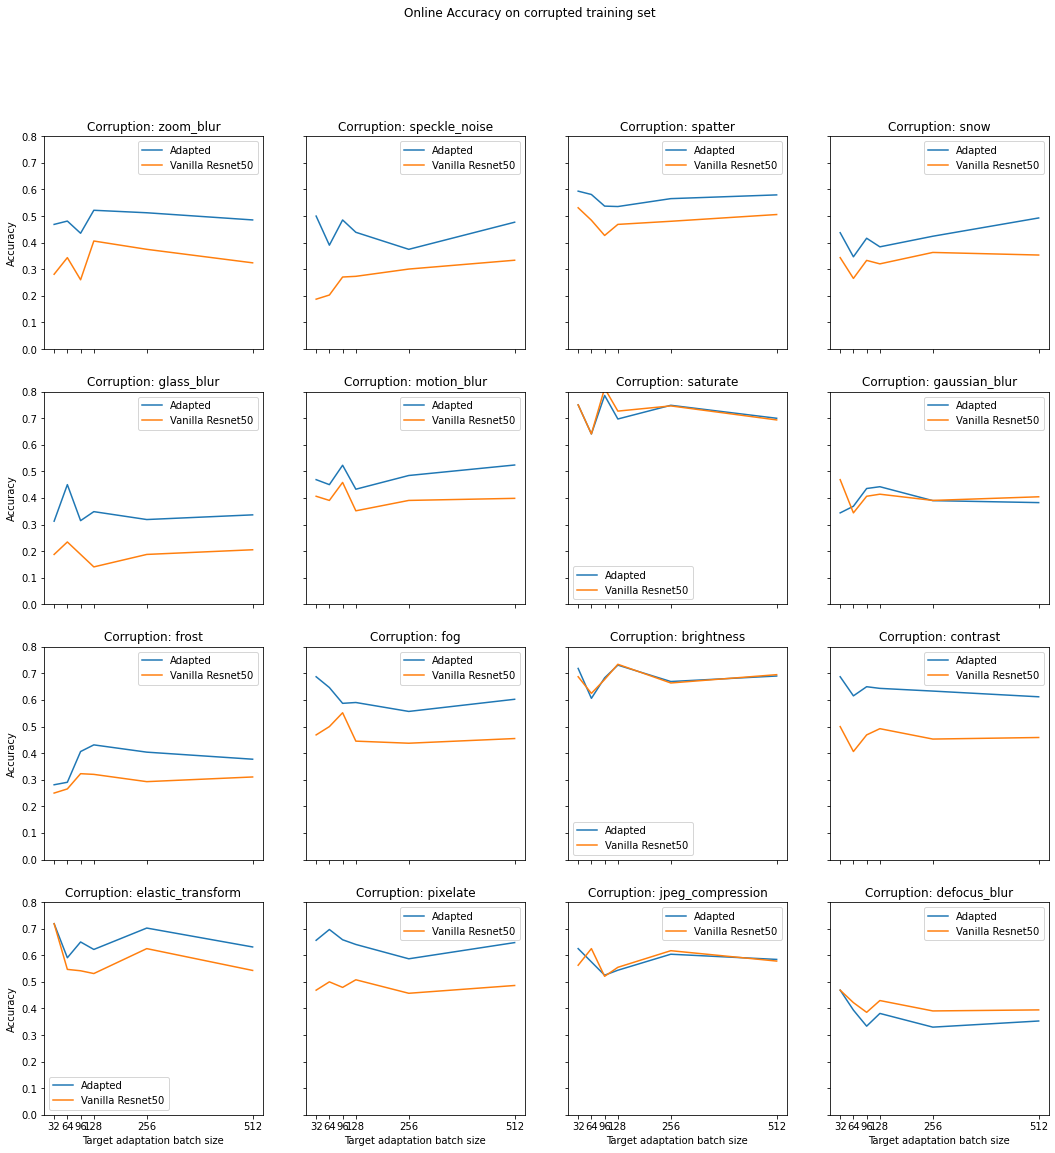

In [59]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Online Accuracy on corrupted training set')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_corrupt_train_acc[cor_ind][2][:-1], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_corrupt_train_acc[cor_ind][2][:-1], label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes[:-1])
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

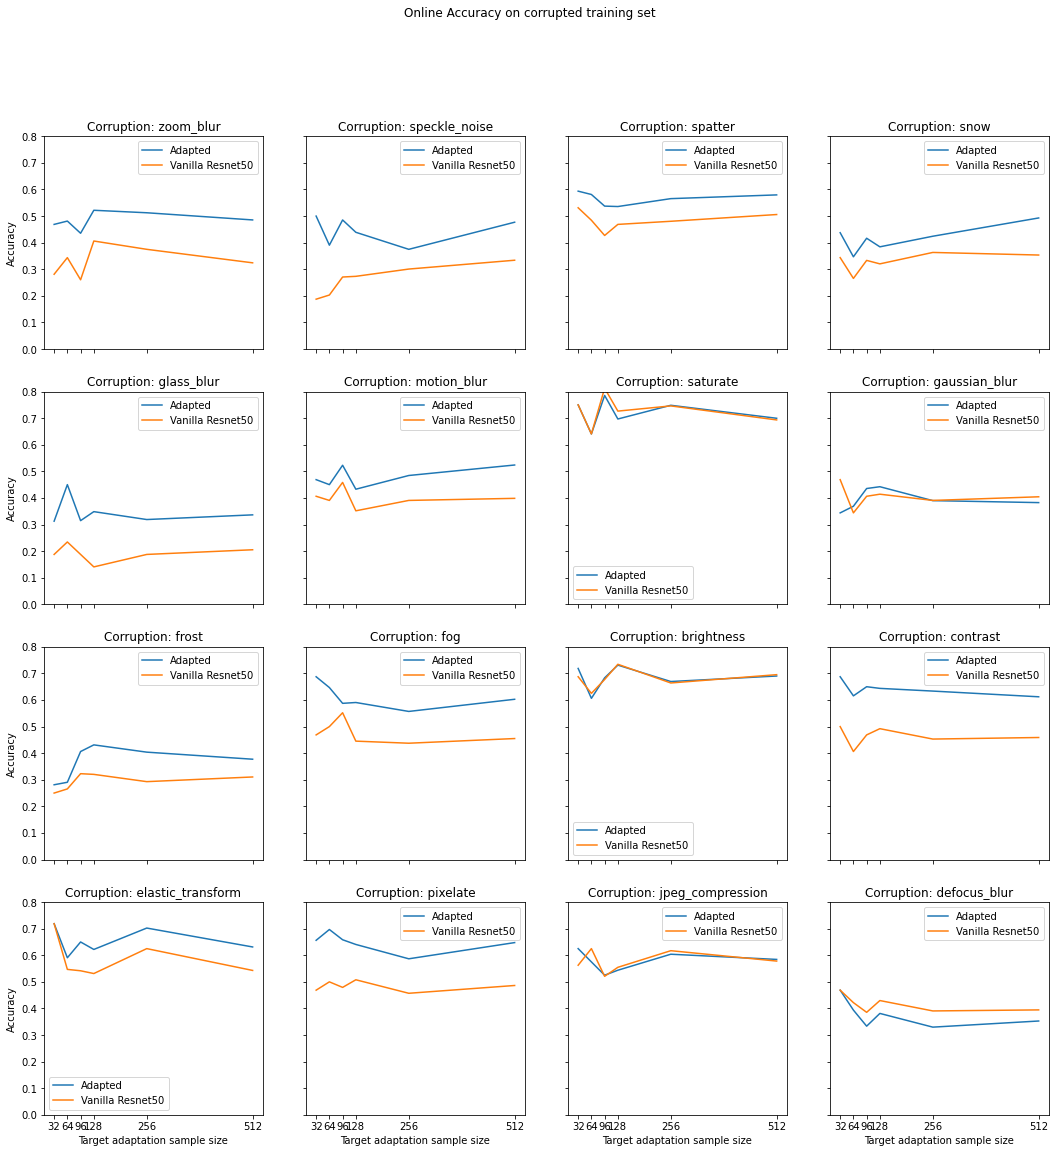

In [10]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Online Accuracy on corrupted training set')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_corrupt_train_acc[cor_ind][2][:-1], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_corrupt_train_acc[cor_ind][2][:-1], label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes[:-1])
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation sample size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

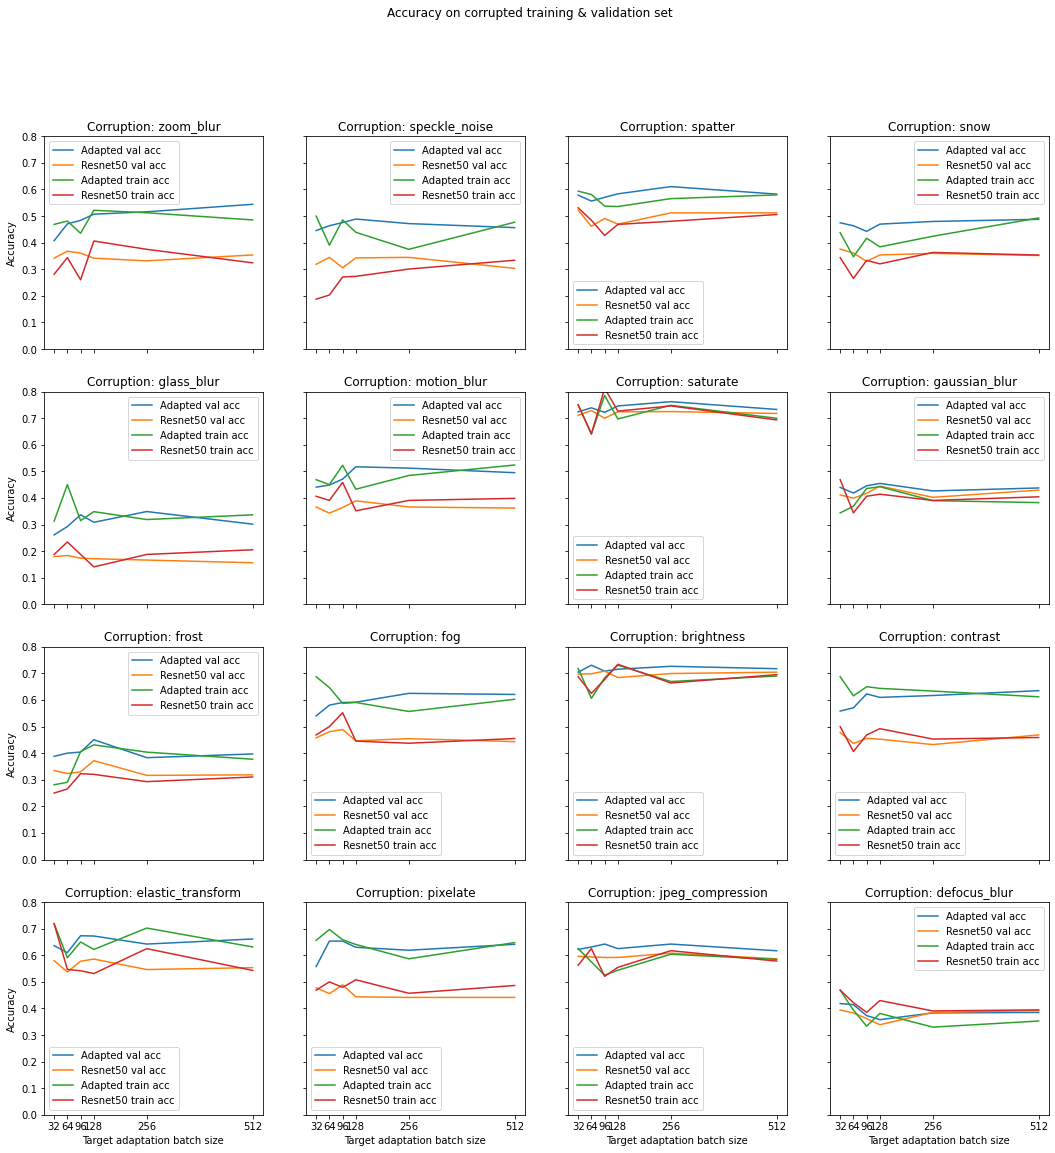

In [44]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted training & validation set for severity = 3')
for cor_ind in range(len(corruption)):
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_corrupt_val_acc[cor_ind][2][:-1], label='Adapted val acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_corrupt_val_acc[cor_ind][2][:-1], label = 'Resnet50 val acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_corrupt_train_acc[cor_ind][2][:-1], label='Adapted train acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_corrupt_train_acc[cor_ind][2][:-1], label = 'Resnet50 train acc')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes[:-1])
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

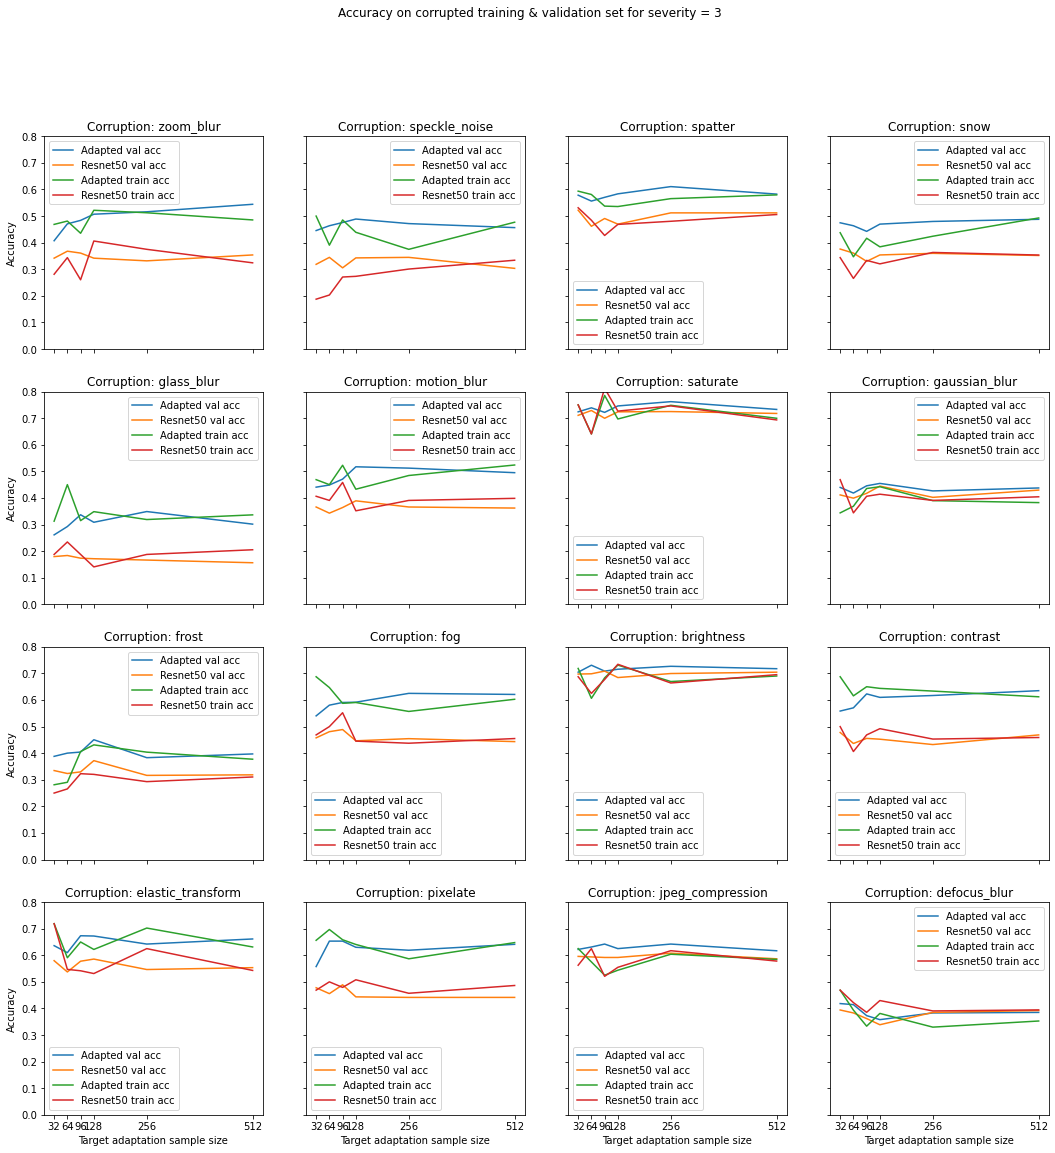

In [11]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted training & validation set for severity = 3')
for cor_ind in range(len(corruption)):
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_corrupt_val_acc[cor_ind][2][:-1], label='Adapted val acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_corrupt_val_acc[cor_ind][2][:-1], label = 'Resnet50 val acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_corrupt_train_acc[cor_ind][2][:-1], label='Adapted train acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_corrupt_train_acc[cor_ind][2][:-1], label = 'Resnet50 train acc')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes[:-1])
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation sample size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [14]:
rpl_corrupt_val_acc.shape

(16, 5, 7)

In [15]:
## Across corruptions
rpl_val_avg_cor = rpl_corrupt_val_acc.mean(axis=0)
base_val_avg_cor = base_corrupt_val_acc.mean(axis=0)
rpl_train_avg_cor = rpl_corrupt_train_acc.mean(axis=0)
base_train_avg_cor = base_corrupt_train_acc.mean(axis=0)

In [19]:
rpl_val_avg_cor

array([[0.6547379 , 0.67256804, 0.67792339, 0.68113659, 0.67930948,
        0.67723034, 0.68573589],
       [0.57321069, 0.59469506, 0.59192288, 0.6077369 , 0.61920363,
        0.61208417, 0.14805948],
       [0.51228579, 0.52772177, 0.53849546, 0.54555192, 0.54788306,
        0.54460685, 0.        ],
       [0.41368448, 0.44291835, 0.4468246 , 0.46238659, 0.46175655,
        0.46307964, 0.        ],
       [0.31709929, 0.34305696, 0.35880796, 0.35383065, 0.36617944,
        0.3672505 , 0.        ]])

In [20]:
target_sizes[:-1]

[32, 64, 96, 128, 256, 512]

In [22]:
rpl_corrupt_val_acc[0]

array([[0.59274194, 0.57862903, 0.60685484, 0.58366935, 0.60483871,
        0.58770161, 0.61592742],
       [0.49495968, 0.5171371 , 0.51814516, 0.55141129, 0.59375   ,
        0.53427419, 0.56048387],
       [0.40725806, 0.47076613, 0.48387097, 0.50705645, 0.51612903,
        0.54435484, 0.        ],
       [0.34677419, 0.40625   , 0.40120968, 0.42741935, 0.47681452,
        0.44153226, 0.        ],
       [0.30040323, 0.33770161, 0.37298387, 0.36592742, 0.40524194,
        0.40927419, 0.        ]])

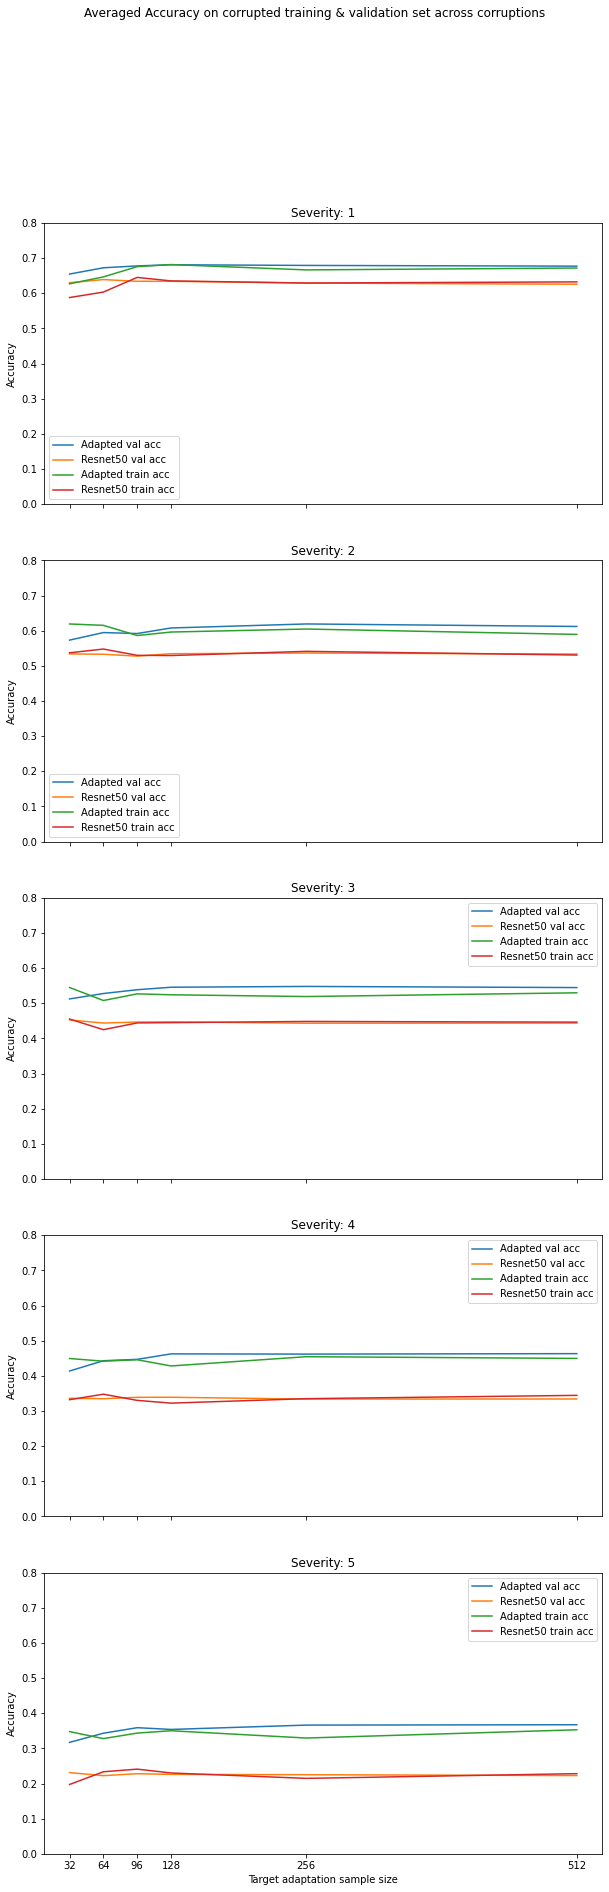

In [29]:
fig, ax = plt.subplots(5, figsize=(10,30))
fig.suptitle('Averaged Accuracy on corrupted training & validation set across corruptions')
for sev_ind in range(len(severity)):
    ax[sev_ind].plot(target_sizes[:-1], rpl_val_avg_cor[sev_ind][:-1], label='Adapted val acc')
    ax[sev_ind].plot(target_sizes[:-1], base_val_avg_cor[sev_ind][:-1], label='Resnet50 val acc')
    ax[sev_ind].plot(target_sizes[:-1], rpl_train_avg_cor[sev_ind][:-1], label='Adapted train acc')
    ax[sev_ind].plot(target_sizes[:-1], base_train_avg_cor[sev_ind][:-1], label = 'Resnet50 train acc')
    ax[sev_ind].legend()
    ax[sev_ind].set_title('Severity: '+str(severity[sev_ind]))
    ax[sev_ind].set_xticks(target_sizes[:-1])
    ax[sev_ind].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation sample size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [32]:
## Across corruptions
rpl_val_avg_sev = rpl_corrupt_val_acc.mean(axis=1)
base_val_avg_sev = base_corrupt_val_acc.mean(axis=1)
rpl_train_avg_sev = rpl_corrupt_train_acc.mean(axis=1)
base_train_avg_sev = base_corrupt_train_acc.mean(axis=1)

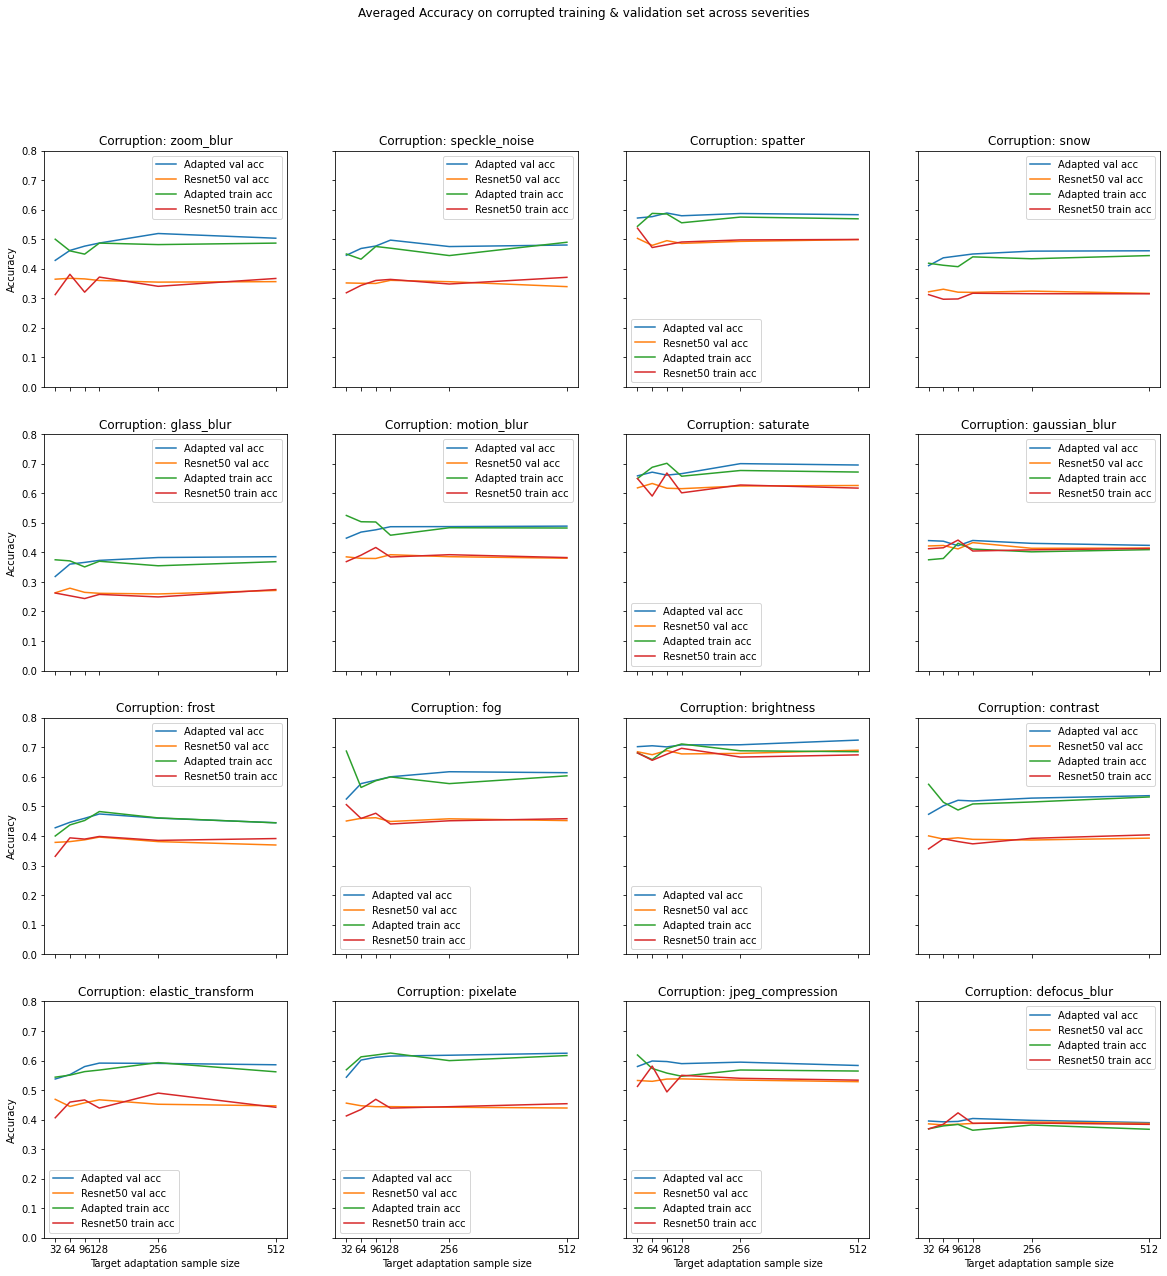

In [38]:
fig, ax = plt.subplots(4, 4, figsize=(20,20))
fig.suptitle('Averaged Accuracy on corrupted training & validation set across severities')
for cor_ind in range(len(corruption)):
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_val_avg_sev[cor_ind][:-1], label='Adapted val acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_val_avg_sev[cor_ind][:-1], label='Resnet50 val acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], rpl_train_avg_sev[cor_ind][:-1], label='Adapted train acc')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes[:-1], base_train_avg_sev[cor_ind][:-1], label = 'Resnet50 train acc')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes[:-1])
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation sample size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [ ]:
# Accuracy over epochs, target_size = 96
# performace_dic = {target_size: 
#                             {severity: 
#                                      {corruption: base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time, base_val_acc, adapted_val_acc} }}


In [33]:
base_acc_progress = np.zeros((len(corruption), len(severity), 5))
adapt_cum_acc_progress = np.zeros((len(corruption), len(severity), 5))
adapt_epoch_acc_progress = np.zeros((len(corruption), len(severity), 5))
for sev in severity:
    for cor in corruption:
        base = np.array(performance_dic[96][sev][cor][0])
        adapt_cum = np.array(performance_dic[96][sev][cor][1])
        adapt_epoch = np.array(performance_dic[96][sev][cor][2])
        base_acc_progress[corruption.index(cor), sev-1] = base
        adapt_cum_acc_progress[corruption.index(cor), sev-1] = adapt_cum        
        adapt_epoch_acc_progress[corruption.index(cor), sev-1] = adapt_epoch

In [40]:
base_acc_progress.mean(axis=0)[0]

array([0.64518229, 0.64518229, 0.64518229, 0.64518229, 0.64518229])

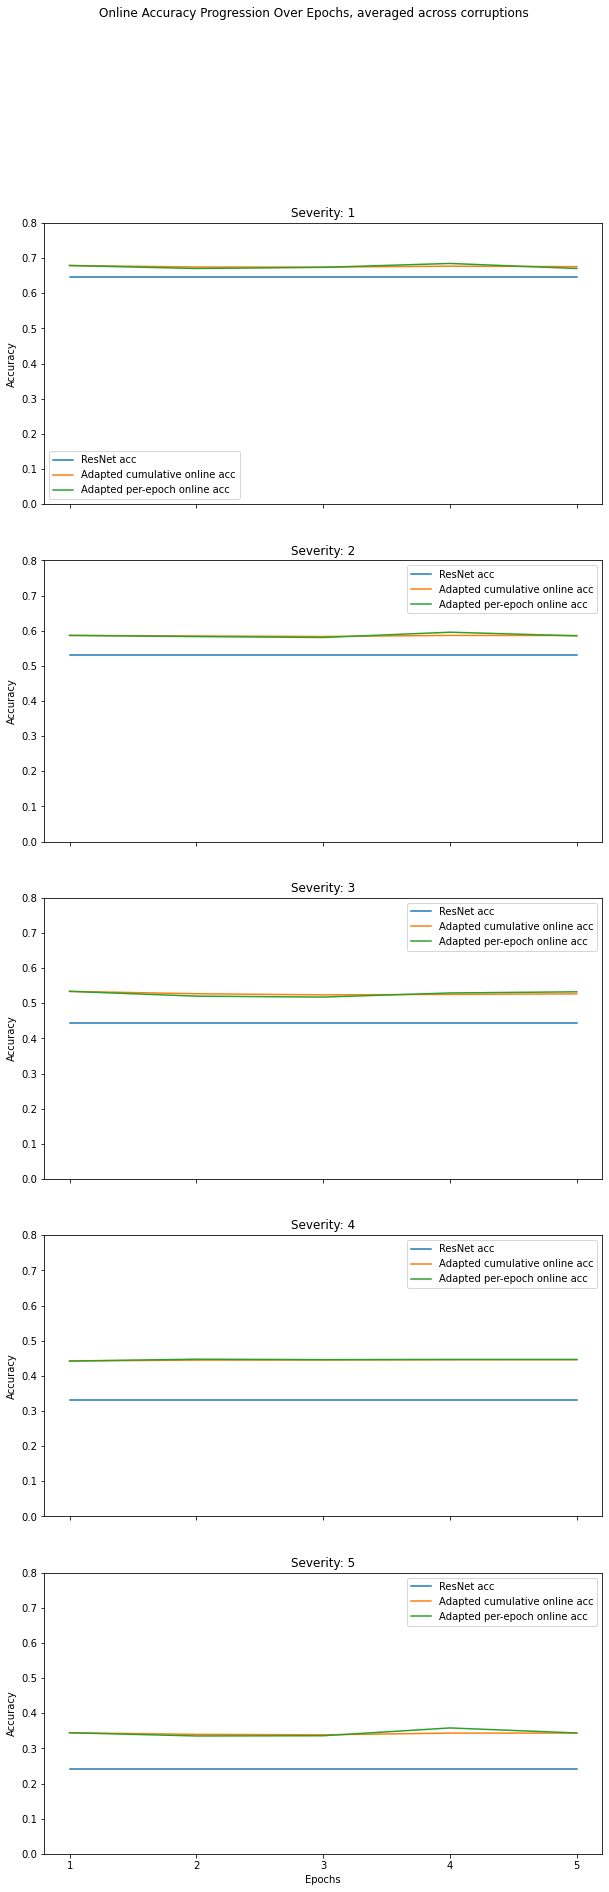

In [41]:
epochs = [1,2,3,4,5]
fig, ax = plt.subplots(5, figsize=(10,30))
fig.suptitle('Online Accuracy Progression Over Epochs, averaged across corruptions')
for sev_ind in range(len(severity)):
    ax[sev_ind].plot(epochs, base_acc_progress.mean(axis=0)[sev_ind], label='ResNet acc')
    ax[sev_ind].plot(epochs, adapt_cum_acc_progress.mean(axis=0)[sev_ind], label='Adapted cumulative online acc')
    ax[sev_ind].plot(epochs, adapt_epoch_acc_progress.mean(axis=0)[sev_ind], label='Adapted per-epoch online acc')
    ax[sev_ind].legend()
    ax[sev_ind].set_title('Severity: '+str(severity[sev_ind]))
    ax[sev_ind].set_xticks(epochs)
    ax[sev_ind].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='Epochs', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

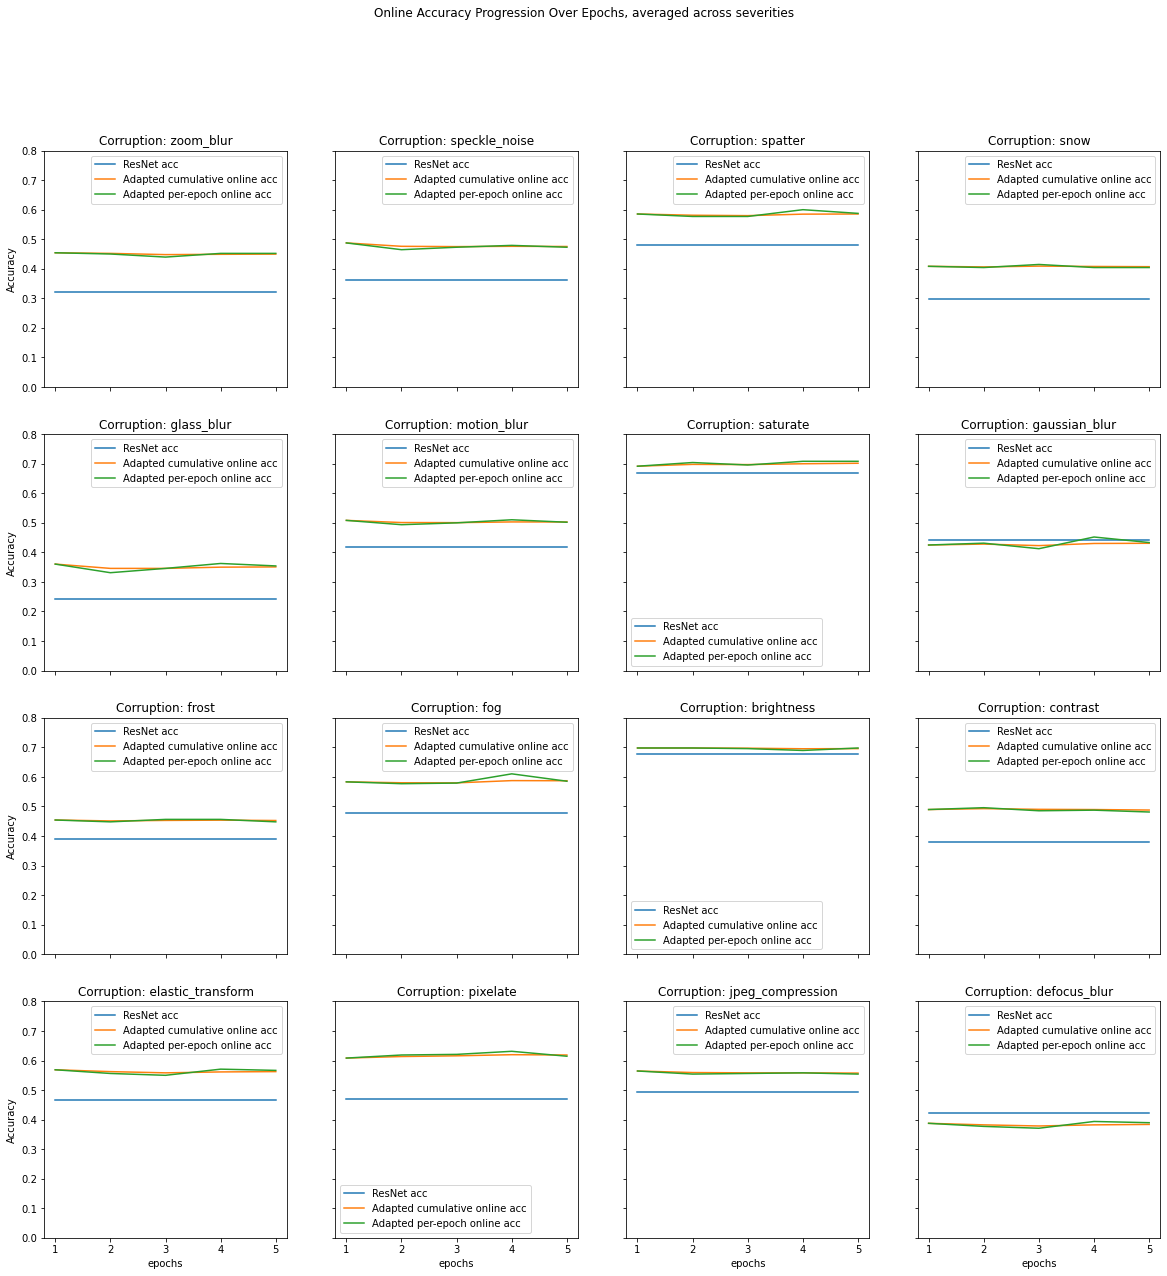

In [42]:
fig, ax = plt.subplots(4, 4, figsize=(20,20))
fig.suptitle('Online Accuracy Progression Over Epochs, averaged across severities')
for cor_ind in range(len(corruption)):
    ax[cor_ind//4][cor_ind%4].plot(epochs, base_acc_progress.mean(axis=1)[cor_ind], label='ResNet acc')
    ax[cor_ind//4][cor_ind%4].plot(epochs, adapt_cum_acc_progress.mean(axis=1)[cor_ind], label='Adapted cumulative online acc')
    ax[cor_ind//4][cor_ind%4].plot(epochs, adapt_epoch_acc_progress.mean(axis=1)[cor_ind], label='Adapted per-epoch online acc')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(epochs)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.8])


    
for a in ax.flat:
    a.set(xlabel='epochs', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [ ]:
# Time vs Target_size / epoch

# performace_dic = {target_size: 
#                             {severity: 
#                                      {corruption: base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time, base_val_acc, adapted_val_acc} }}


In [51]:
def find_average_time_per_epoch(ts):
    time = []
    for sev in severity:
        for cor in corruption:
            for t in performance_dic[ts][sev][cor][3]:
                time.append(t)
    return np.mean(time)

In [52]:
time_per_epoch = []
for ts in target_sizes[:-1]:
    time_per_epoch.append(find_average_time_per_epoch(ts))
        

In [53]:
time_per_epoch

[3.5770736247301103,
 3.798159512281418,
 3.9722636586427686,
 4.122386605143547,
 4.820306075215339,
 6.137031955122947]

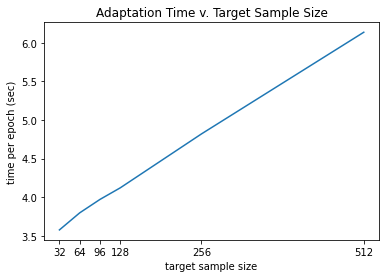

In [61]:
plt.plot(target_sizes[:-1], time_per_epoch)
plt.xticks(target_sizes[:-1])
plt.xlabel('target sample size')
plt.ylabel('time per epoch (sec)')
plt.title('Adaptation Time v. Target Sample Size')
plt.show()

## Varying Target Size, Varying Batch Size (target size = batch size)

In [25]:
target_sizes = [32, 64, 96, 128, 256, 512, 1000]
severity = [1,2,3,4,5]
# batch_size = 32

rpl_corrupt_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
base_corrupt_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
base_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))

rpl_adpt_times = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))

# rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


In [26]:
performance_dic_varying_bs = {} 

# performace_dic = {target_size: {severity: {corruption: base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time, base_val_acc, adapted_val_acc} }}

for ts_ind in range(len(target_sizes)):
        
    performance_dic_varying_bs[target_sizes[ts_ind]] = {}
    
    for severity_ind in range(len(severity)):
        
        performance_dic_varying_bs[target_sizes[ts_ind]][severity[severity_ind]] = {}

        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], target_sizes[ts_ind], target_sizes[ts_ind])
        
        # adapt the model using the rpl methods
        # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
        for cor_ind in range(len(corrupted_dataloaders)):
            
            print(f'## Experiment: Severity = {severity[severity_ind]}, target_size = {target_sizes[ts_ind]}, corruption = {corruption[cor_ind]}')
            
            model = models.resnet50(pretrained=True)
            model.to(device)
            
            baseline = models.resnet50(pretrained=True)
            baseline.to(device)
            
            # adapt the model
            base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time \
            = adapt(model=model, baseline=baseline, dataloader=corrupted_dataloaders[cor_ind]['train'])
            
            # record the performances
            rpl_adpt_times[cor_ind, severity_ind, ts_ind] = training_time[-1]
            rpl_corrupt_train_acc[cor_ind, severity_ind, ts_ind] = adapted_train_acc_cum[-1]
            base_corrupt_train_acc[cor_ind, severity_ind, ts_ind] = base_acc[-1]
            
            print("----------------------------------------------------------")
            
            # evaluate the adapted model & base model on the, corrupted val data
            model.eval()
            with torch.no_grad():
                b_crpt_val_correct, crpt_val_correct, crpt_val_samples = 0, 0, 0
                
                for images, labels in corrupted_dataloaders[cor_ind]['val']:
                    labels = labels.to(device)
                    outputs = model(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    crpt_val_correct += (predicted == labels).sum().item()
                    crpt_val_samples += len(labels)
                    
                    b_outputs = baseline(images.to(device))
                    _, b_predicted = torch.max(b_outputs.data, 1)
                    b_crpt_val_correct += (b_predicted == labels).sum().item()
                
                print(f"Corrupt Val Base Accuracy: {b_crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({b_crpt_val_correct / crpt_val_samples})")
                print(f"Corrupt Val Adapted Accuracy: {crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({crpt_val_correct / crpt_val_samples})")

                rpl_corrupt_val_acc[cor_ind, severity_ind, ts_ind] = crpt_val_correct / crpt_val_samples
                base_corrupt_val_acc[cor_ind, severity_ind, ts_ind] = b_crpt_val_correct / crpt_val_samples
                

                performance_dic_varying_bs[target_sizes[ts_ind]][severity[severity_ind]][corruption[cor_ind]] = \
                [base_acc, adapted_train_acc_cum, adapted_train_acc_epoch, training_time, \
                 (b_crpt_val_correct/crpt_val_samples), (crpt_val_correct/crpt_val_samples)]
                
            print("==================================================================================================")
              
                

        with open('BASE_corrupt_train_acc_vary_bs.npy', 'wb') as f:
            np.save(f, base_corrupt_train_acc)
        with open('BASE_corrupt_validation_acc_vary_bs.npy', 'wb') as f:
            np.save(f, base_corrupt_val_acc)
        with open('RPL_corrupt_train_acc_vary_bs.npy', 'wb') as f:
            np.save(f, rpl_corrupt_train_acc)
        with open('RPL_corrupt_validation_acc_vary_bs.npy', 'wb') as f:
            np.save(f, rpl_corrupt_val_acc)
        with open('RPL_adapt_time_vary_bs.npy', 'wb') as f:
            np.save(f, rpl_adpt_times)
            
        with open('all_exp_performance_dic_vary_bs.pkl', 'wb') as f:
            pickle.dump(performance_dic_varying_bs, f)

        
        
            
            
            

## Experiment: Severity = 1, target_size = 32, corruption = zoom_blur
Epoch 0
Baseline Correct:   17./  32. (53.12 %)
Adapted Cumulative Correct:   20./  32. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 1
Baseline Correct:   34./  64. (53.12 %)
Adapted Cumulative Correct:   40./  64. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 2
Baseline Correct:   51./  96. (53.12 %)
Adapted Cumulative Correct:   60./  96. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 3
Baseline Correct:   68./ 128. (53.12 %)
Adapted Cumulative Correct:   80./ 128. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 4
Baseline Correct:   85./ 160. (53.12 %)
Adapted Cumulative Correct:  100./ 160. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  539./ 992. (0.5433467741935484)
Corrupt Val Adapted Accuracy:  574./ 992. (0.5786290322580645)
## Experiment: Severity = 1, targ

Corrupt Val Base Accuracy:  677./ 992. (0.6824596774193549)
Corrupt Val Adapted Accuracy:  702./ 992. (0.7076612903225806)
## Experiment: Severity = 1, target_size = 32, corruption = frost
Epoch 0
Baseline Correct:   19./  32. (59.38 %)
Adapted Cumulative Correct:   21./  32. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
Epoch 1
Baseline Correct:   38./  64. (59.38 %)
Adapted Cumulative Correct:   42./  64. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
Epoch 2
Baseline Correct:   57./  96. (59.38 %)
Adapted Cumulative Correct:   63./  96. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
Epoch 3
Baseline Correct:   76./ 128. (59.38 %)
Adapted Cumulative Correct:   84./ 128. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
Epoch 4
Baseline Correct:   95./ 160. (59.38 %)
Adapted Cumulative Correct:  105./ 160. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  638./ 992

Baseline Correct:   80./ 160. (50.00 %)
Adapted Cumulative Correct:  100./ 160. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  581./ 992. (0.5856854838709677)
Corrupt Val Adapted Accuracy:  605./ 992. (0.6098790322580645)
## Experiment: Severity = 2, target_size = 32, corruption = zoom_blur
Epoch 0
Baseline Correct:   12./  32. (37.50 %)
Adapted Cumulative Correct:   13./  32. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 1
Baseline Correct:   24./  64. (37.50 %)
Adapted Cumulative Correct:   26./  64. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 2
Baseline Correct:   36./  96. (37.50 %)
Adapted Cumulative Correct:   39./  96. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 3
Baseline Correct:   48./ 128. (37.50 %)
Adapted Cumulative Correct:   52./ 128. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 4
Baseline Correct:   60./ 160. (37

Baseline Correct:   57./  96. (59.38 %)
Adapted Cumulative Correct:   63./  96. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
Epoch 3
Baseline Correct:   76./ 128. (59.38 %)
Adapted Cumulative Correct:   84./ 128. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
Epoch 4
Baseline Correct:   95./ 160. (59.38 %)
Adapted Cumulative Correct:  105./ 160. (65.62 %)
Adapted Epoch Correct:   21./  32. (65.62 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  547./ 992. (0.5514112903225806)
Corrupt Val Adapted Accuracy:  562./ 992. (0.5665322580645161)
## Experiment: Severity = 2, target_size = 32, corruption = frost
Epoch 0
Baseline Correct:   10./  32. (31.25 %)
Adapted Cumulative Correct:    8./  32. (25.00 %)
Adapted Epoch Correct:    8./  32. (25.00 %)
Epoch 1
Baseline Correct:   20./  64. (31.25 %)
Adapted Cumulative Correct:   16./  64. (25.00 %)
Adapted Epoch Correct:    8./  32. (25.00 %)
Epoch 2
Baseline Correct:   30./  96. (31.25 

Epoch 0
Baseline Correct:   14./  32. (43.75 %)
Adapted Cumulative Correct:   13./  32. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 1
Baseline Correct:   28./  64. (43.75 %)
Adapted Cumulative Correct:   26./  64. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 2
Baseline Correct:   42./  96. (43.75 %)
Adapted Cumulative Correct:   39./  96. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 3
Baseline Correct:   56./ 128. (43.75 %)
Adapted Cumulative Correct:   52./ 128. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
Epoch 4
Baseline Correct:   70./ 160. (43.75 %)
Adapted Cumulative Correct:   65./ 160. (40.62 %)
Adapted Epoch Correct:   13./  32. (40.62 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  523./ 992. (0.5272177419354839)
Corrupt Val Adapted Accuracy:  540./ 992. (0.5443548387096774)
## Experiment: Severity = 3, target_size = 32, corruption = zoom_blur
Epoch 0
Baseline Correct:   10./ 

Corrupt Val Base Accuracy:  706./ 992. (0.7116935483870968)
Corrupt Val Adapted Accuracy:  726./ 992. (0.7318548387096774)
## Experiment: Severity = 3, target_size = 32, corruption = gaussian_blur
Epoch 0
Baseline Correct:   11./  32. (34.38 %)
Adapted Cumulative Correct:   10./  32. (31.25 %)
Adapted Epoch Correct:   10./  32. (31.25 %)
Epoch 1
Baseline Correct:   22./  64. (34.38 %)
Adapted Cumulative Correct:   20./  64. (31.25 %)
Adapted Epoch Correct:   10./  32. (31.25 %)
Epoch 2
Baseline Correct:   33./  96. (34.38 %)
Adapted Cumulative Correct:   30./  96. (31.25 %)
Adapted Epoch Correct:   10./  32. (31.25 %)
Epoch 3
Baseline Correct:   44./ 128. (34.38 %)
Adapted Cumulative Correct:   40./ 128. (31.25 %)
Adapted Epoch Correct:   10./  32. (31.25 %)
Epoch 4
Baseline Correct:   55./ 160. (34.38 %)
Adapted Cumulative Correct:   50./ 160. (31.25 %)
Adapted Epoch Correct:   10./  32. (31.25 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  3

Baseline Correct:   72./ 128. (56.25 %)
Adapted Cumulative Correct:   80./ 128. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 4
Baseline Correct:   90./ 160. (56.25 %)
Adapted Cumulative Correct:  100./ 160. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  583./ 992. (0.5877016129032258)
Corrupt Val Adapted Accuracy:  602./ 992. (0.6068548387096774)
## Experiment: Severity = 3, target_size = 32, corruption = defocus_blur
Epoch 0
Baseline Correct:   11./  32. (34.38 %)
Adapted Cumulative Correct:   12./  32. (37.50 %)
Adapted Epoch Correct:   12./  32. (37.50 %)
Epoch 1
Baseline Correct:   22./  64. (34.38 %)
Adapted Cumulative Correct:   24./  64. (37.50 %)
Adapted Epoch Correct:   12./  32. (37.50 %)
Epoch 2
Baseline Correct:   33./  96. (34.38 %)
Adapted Cumulative Correct:   36./  96. (37.50 %)
Adapted Epoch Correct:   12./  32. (37.50 %)
Epoch 3
Baseline Correct:   44./ 128. 

Baseline Correct:   34./  64. (53.12 %)
Adapted Cumulative Correct:   40./  64. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 2
Baseline Correct:   51./  96. (53.12 %)
Adapted Cumulative Correct:   60./  96. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 3
Baseline Correct:   68./ 128. (53.12 %)
Adapted Cumulative Correct:   80./ 128. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
Epoch 4
Baseline Correct:   85./ 160. (53.12 %)
Adapted Cumulative Correct:  100./ 160. (62.50 %)
Adapted Epoch Correct:   20./  32. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  602./ 992. (0.6068548387096774)
Corrupt Val Adapted Accuracy:  646./ 992. (0.6512096774193549)
## Experiment: Severity = 4, target_size = 32, corruption = gaussian_blur
Epoch 0
Baseline Correct:    6./  32. (18.75 %)
Adapted Cumulative Correct:    5./  32. (15.62 %)
Adapted Epoch Correct:    5./  32. (15.62 %)
Epoch 1
Baseline Correct:   12./  64.

Epoch 0
Baseline Correct:   16./  32. (50.00 %)
Adapted Cumulative Correct:   17./  32. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 1
Baseline Correct:   32./  64. (50.00 %)
Adapted Cumulative Correct:   34./  64. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 2
Baseline Correct:   48./  96. (50.00 %)
Adapted Cumulative Correct:   51./  96. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 3
Baseline Correct:   64./ 128. (50.00 %)
Adapted Cumulative Correct:   68./ 128. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
Epoch 4
Baseline Correct:   80./ 160. (50.00 %)
Adapted Cumulative Correct:   85./ 160. (53.12 %)
Adapted Epoch Correct:   17./  32. (53.12 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  455./ 992. (0.4586693548387097)
Corrupt Val Adapted Accuracy:  512./ 992. (0.5161290322580645)
## Experiment: Severity = 4, target_size = 32, corruption = defocus_blur
Epoch 0
Baseline Correct:    2

Corrupt Val Base Accuracy:  160./ 992. (0.16129032258064516)
Corrupt Val Adapted Accuracy:  224./ 992. (0.22580645161290322)
## Experiment: Severity = 5, target_size = 32, corruption = saturate
Epoch 0
Baseline Correct:   13./  32. (40.62 %)
Adapted Cumulative Correct:   22./  32. (68.75 %)
Adapted Epoch Correct:   22./  32. (68.75 %)
Epoch 1
Baseline Correct:   26./  64. (40.62 %)
Adapted Cumulative Correct:   44./  64. (68.75 %)
Adapted Epoch Correct:   22./  32. (68.75 %)
Epoch 2
Baseline Correct:   39./  96. (40.62 %)
Adapted Cumulative Correct:   66./  96. (68.75 %)
Adapted Epoch Correct:   22./  32. (68.75 %)
Epoch 3
Baseline Correct:   52./ 128. (40.62 %)
Adapted Cumulative Correct:   88./ 128. (68.75 %)
Adapted Epoch Correct:   22./  32. (68.75 %)
Epoch 4
Baseline Correct:   65./ 160. (40.62 %)
Adapted Cumulative Correct:  110./ 160. (68.75 %)
Adapted Epoch Correct:   22./  32. (68.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  461.

Baseline Correct:   24./ 128. (18.75 %)
Adapted Cumulative Correct:   44./ 128. (34.38 %)
Adapted Epoch Correct:   11./  32. (34.38 %)
Epoch 4
Baseline Correct:   30./ 160. (18.75 %)
Adapted Cumulative Correct:   55./ 160. (34.38 %)
Adapted Epoch Correct:   11./  32. (34.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  212./ 992. (0.21370967741935484)
Corrupt Val Adapted Accuracy:  381./ 992. (0.3840725806451613)
## Experiment: Severity = 5, target_size = 32, corruption = jpeg_compression
Epoch 0
Baseline Correct:   11./  32. (34.38 %)
Adapted Cumulative Correct:   12./  32. (37.50 %)
Adapted Epoch Correct:   12./  32. (37.50 %)
Epoch 1
Baseline Correct:   22./  64. (34.38 %)
Adapted Cumulative Correct:   24./  64. (37.50 %)
Adapted Epoch Correct:   12./  32. (37.50 %)
Epoch 2
Baseline Correct:   33./  96. (34.38 %)
Adapted Cumulative Correct:   36./  96. (37.50 %)
Adapted Epoch Correct:   12./  32. (37.50 %)
Epoch 3
Baseline Correct:   44./ 

Baseline Correct:   66./ 128. (51.56 %)
Adapted Cumulative Correct:   88./ 128. (68.75 %)
Adapted Epoch Correct:   44./  64. (68.75 %)
Epoch 2
Baseline Correct:   99./ 192. (51.56 %)
Adapted Cumulative Correct:  132./ 192. (68.75 %)
Adapted Epoch Correct:   44./  64. (68.75 %)
Epoch 3
Baseline Correct:  132./ 256. (51.56 %)
Adapted Cumulative Correct:  176./ 256. (68.75 %)
Adapted Epoch Correct:   44./  64. (68.75 %)
Epoch 4
Baseline Correct:  165./ 320. (51.56 %)
Adapted Cumulative Correct:  220./ 320. (68.75 %)
Adapted Epoch Correct:   44./  64. (68.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  629./ 960. (0.6552083333333333)
Corrupt Val Adapted Accuracy:  635./ 960. (0.6614583333333334)
## Experiment: Severity = 1, target_size = 64, corruption = saturate
Epoch 0
Baseline Correct:   47./  64. (73.44 %)
Adapted Cumulative Correct:   47./  64. (73.44 %)
Adapted Epoch Correct:   47./  64. (73.44 %)
Epoch 1
Baseline Correct:   94./ 128. (73.

Epoch 0
Baseline Correct:   39./  64. (60.94 %)
Adapted Cumulative Correct:   46./  64. (71.88 %)
Adapted Epoch Correct:   46./  64. (71.88 %)
Epoch 1
Baseline Correct:   78./ 128. (60.94 %)
Adapted Cumulative Correct:   92./ 128. (71.88 %)
Adapted Epoch Correct:   46./  64. (71.88 %)
Epoch 2
Baseline Correct:  117./ 192. (60.94 %)
Adapted Cumulative Correct:  138./ 192. (71.88 %)
Adapted Epoch Correct:   46./  64. (71.88 %)
Epoch 3
Baseline Correct:  156./ 256. (60.94 %)
Adapted Cumulative Correct:  184./ 256. (71.88 %)
Adapted Epoch Correct:   46./  64. (71.88 %)
Epoch 4
Baseline Correct:  195./ 320. (60.94 %)
Adapted Cumulative Correct:  230./ 320. (71.88 %)
Adapted Epoch Correct:   46./  64. (71.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  592./ 960. (0.6166666666666667)
Corrupt Val Adapted Accuracy:  638./ 960. (0.6645833333333333)
## Experiment: Severity = 1, target_size = 64, corruption = jpeg_compression
Epoch 0
Baseline Correct: 

Corrupt Val Base Accuracy:  400./ 960. (0.4166666666666667)
Corrupt Val Adapted Accuracy:  459./ 960. (0.478125)
## Experiment: Severity = 2, target_size = 64, corruption = motion_blur
Epoch 0
Baseline Correct:   29./  64. (45.31 %)
Adapted Cumulative Correct:   35./  64. (54.69 %)
Adapted Epoch Correct:   35./  64. (54.69 %)
Epoch 1
Baseline Correct:   58./ 128. (45.31 %)
Adapted Cumulative Correct:   70./ 128. (54.69 %)
Adapted Epoch Correct:   35./  64. (54.69 %)
Epoch 2
Baseline Correct:   87./ 192. (45.31 %)
Adapted Cumulative Correct:  105./ 192. (54.69 %)
Adapted Epoch Correct:   35./  64. (54.69 %)
Epoch 3
Baseline Correct:  116./ 256. (45.31 %)
Adapted Cumulative Correct:  140./ 256. (54.69 %)
Adapted Epoch Correct:   35./  64. (54.69 %)
Epoch 4
Baseline Correct:  145./ 320. (45.31 %)
Adapted Cumulative Correct:  175./ 320. (54.69 %)
Adapted Epoch Correct:   35./  64. (54.69 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  522./ 960. (0

Baseline Correct:  140./ 320. (43.75 %)
Adapted Cumulative Correct:  185./ 320. (57.81 %)
Adapted Epoch Correct:   37./  64. (57.81 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  431./ 960. (0.44895833333333335)
Corrupt Val Adapted Accuracy:  479./ 960. (0.49895833333333334)
## Experiment: Severity = 2, target_size = 64, corruption = pixelate
Epoch 0
Baseline Correct:   36./  64. (56.25 %)
Adapted Cumulative Correct:   42./  64. (65.62 %)
Adapted Epoch Correct:   42./  64. (65.62 %)
Epoch 1
Baseline Correct:   72./ 128. (56.25 %)
Adapted Cumulative Correct:   84./ 128. (65.62 %)
Adapted Epoch Correct:   42./  64. (65.62 %)
Epoch 2
Baseline Correct:  108./ 192. (56.25 %)
Adapted Cumulative Correct:  126./ 192. (65.62 %)
Adapted Epoch Correct:   42./  64. (65.62 %)
Epoch 3
Baseline Correct:  144./ 256. (56.25 %)
Adapted Cumulative Correct:  168./ 256. (65.62 %)
Adapted Epoch Correct:   42./  64. (65.62 %)
Epoch 4
Baseline Correct:  180./ 320. (5

Baseline Correct:   24./ 192. (12.50 %)
Adapted Cumulative Correct:   54./ 192. (28.12 %)
Adapted Epoch Correct:   18./  64. (28.12 %)
Epoch 3
Baseline Correct:   32./ 256. (12.50 %)
Adapted Cumulative Correct:   72./ 256. (28.12 %)
Adapted Epoch Correct:   18./  64. (28.12 %)
Epoch 4
Baseline Correct:   40./ 320. (12.50 %)
Adapted Cumulative Correct:   90./ 320. (28.12 %)
Adapted Epoch Correct:   18./  64. (28.12 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  160./ 960. (0.16666666666666666)
Corrupt Val Adapted Accuracy:  251./ 960. (0.26145833333333335)
## Experiment: Severity = 3, target_size = 64, corruption = motion_blur
Epoch 0
Baseline Correct:   26./  64. (40.62 %)
Adapted Cumulative Correct:   31./  64. (48.44 %)
Adapted Epoch Correct:   31./  64. (48.44 %)
Epoch 1
Baseline Correct:   52./ 128. (40.62 %)
Adapted Cumulative Correct:   62./ 128. (48.44 %)
Adapted Epoch Correct:   31./  64. (48.44 %)
Epoch 2
Baseline Correct:   78./ 192.

Epoch 0
Baseline Correct:   35./  64. (54.69 %)
Adapted Cumulative Correct:   38./  64. (59.38 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
Epoch 1
Baseline Correct:   70./ 128. (54.69 %)
Adapted Cumulative Correct:   76./ 128. (59.38 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
Epoch 2
Baseline Correct:  105./ 192. (54.69 %)
Adapted Cumulative Correct:  114./ 192. (59.38 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
Epoch 3
Baseline Correct:  140./ 256. (54.69 %)
Adapted Cumulative Correct:  152./ 256. (59.38 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
Epoch 4
Baseline Correct:  175./ 320. (54.69 %)
Adapted Cumulative Correct:  190./ 320. (59.38 %)
Adapted Epoch Correct:   38./  64. (59.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  533./ 960. (0.5552083333333333)
Corrupt Val Adapted Accuracy:  585./ 960. (0.609375)
## Experiment: Severity = 3, target_size = 64, corruption = pixelate
Epoch 0
Baseline Correct:   25./  64. (39.06

Epoch 0
Baseline Correct:   13./  64. (20.31 %)
Adapted Cumulative Correct:   17./  64. (26.56 %)
Adapted Epoch Correct:   17./  64. (26.56 %)
Epoch 1
Baseline Correct:   26./ 128. (20.31 %)
Adapted Cumulative Correct:   34./ 128. (26.56 %)
Adapted Epoch Correct:   17./  64. (26.56 %)
Epoch 2
Baseline Correct:   39./ 192. (20.31 %)
Adapted Cumulative Correct:   51./ 192. (26.56 %)
Adapted Epoch Correct:   17./  64. (26.56 %)
Epoch 3
Baseline Correct:   52./ 256. (20.31 %)
Adapted Cumulative Correct:   68./ 256. (26.56 %)
Adapted Epoch Correct:   17./  64. (26.56 %)
Epoch 4
Baseline Correct:   65./ 320. (20.31 %)
Adapted Cumulative Correct:   85./ 320. (26.56 %)
Adapted Epoch Correct:   17./  64. (26.56 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  153./ 960. (0.159375)
Corrupt Val Adapted Accuracy:  216./ 960. (0.225)
## Experiment: Severity = 4, target_size = 64, corruption = motion_blur
Epoch 0
Baseline Correct:    7./  64. (10.94 %)
Adapte

Epoch 0
Baseline Correct:   30./  64. (46.88 %)
Adapted Cumulative Correct:   45./  64. (70.31 %)
Adapted Epoch Correct:   45./  64. (70.31 %)
Epoch 1
Baseline Correct:   60./ 128. (46.88 %)
Adapted Cumulative Correct:   90./ 128. (70.31 %)
Adapted Epoch Correct:   45./  64. (70.31 %)
Epoch 2
Baseline Correct:   90./ 192. (46.88 %)
Adapted Cumulative Correct:  135./ 192. (70.31 %)
Adapted Epoch Correct:   45./  64. (70.31 %)
Epoch 3
Baseline Correct:  120./ 256. (46.88 %)
Adapted Cumulative Correct:  180./ 256. (70.31 %)
Adapted Epoch Correct:   45./  64. (70.31 %)
Epoch 4
Baseline Correct:  150./ 320. (46.88 %)
Adapted Cumulative Correct:  225./ 320. (70.31 %)
Adapted Epoch Correct:   45./  64. (70.31 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  405./ 960. (0.421875)
Corrupt Val Adapted Accuracy:  506./ 960. (0.5270833333333333)
## Experiment: Severity = 4, target_size = 64, corruption = pixelate
Epoch 0
Baseline Correct:   19./  64. (29.69

Corrupt Val Base Accuracy:  161./ 960. (0.16770833333333332)
Corrupt Val Adapted Accuracy:  262./ 960. (0.27291666666666664)
## Experiment: Severity = 5, target_size = 64, corruption = glass_blur
Epoch 0
Baseline Correct:    4./  64. (6.25 %)
Adapted Cumulative Correct:    8./  64. (12.50 %)
Adapted Epoch Correct:    8./  64. (12.50 %)
Epoch 1
Baseline Correct:    8./ 128. (6.25 %)
Adapted Cumulative Correct:   16./ 128. (12.50 %)
Adapted Epoch Correct:    8./  64. (12.50 %)
Epoch 2
Baseline Correct:   12./ 192. (6.25 %)
Adapted Cumulative Correct:   24./ 192. (12.50 %)
Adapted Epoch Correct:    8./  64. (12.50 %)
Epoch 3
Baseline Correct:   16./ 256. (6.25 %)
Adapted Cumulative Correct:   32./ 256. (12.50 %)
Adapted Epoch Correct:    8./  64. (12.50 %)
Epoch 4
Baseline Correct:   20./ 320. (6.25 %)
Adapted Cumulative Correct:   40./ 320. (12.50 %)
Adapted Epoch Correct:    8./  64. (12.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  109./ 9

Baseline Correct:   40./ 320. (12.50 %)
Adapted Cumulative Correct:  100./ 320. (31.25 %)
Adapted Epoch Correct:   20./  64. (31.25 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:   53./ 960. (0.05520833333333333)
Corrupt Val Adapted Accuracy:  131./ 960. (0.13645833333333332)
## Experiment: Severity = 5, target_size = 64, corruption = elastic_transform
Epoch 0
Baseline Correct:   12./  64. (18.75 %)
Adapted Cumulative Correct:   27./  64. (42.19 %)
Adapted Epoch Correct:   27./  64. (42.19 %)
Epoch 1
Baseline Correct:   24./ 128. (18.75 %)
Adapted Cumulative Correct:   54./ 128. (42.19 %)
Adapted Epoch Correct:   27./  64. (42.19 %)
Epoch 2
Baseline Correct:   36./ 192. (18.75 %)
Adapted Cumulative Correct:   81./ 192. (42.19 %)
Adapted Epoch Correct:   27./  64. (42.19 %)
Epoch 3
Baseline Correct:   48./ 256. (18.75 %)
Adapted Cumulative Correct:  108./ 256. (42.19 %)
Adapted Epoch Correct:   27./  64. (42.19 %)
Epoch 4
Baseline Correct:   60.

Baseline Correct:  153./ 288. (53.12 %)
Adapted Cumulative Correct:  156./ 288. (54.17 %)
Adapted Epoch Correct:   52./  96. (54.17 %)
Epoch 3
Baseline Correct:  204./ 384. (53.12 %)
Adapted Cumulative Correct:  208./ 384. (54.17 %)
Adapted Epoch Correct:   52./  96. (54.17 %)
Epoch 4
Baseline Correct:  255./ 480. (53.12 %)
Adapted Cumulative Correct:  260./ 480. (54.17 %)
Adapted Epoch Correct:   52./  96. (54.17 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  518./ 960. (0.5395833333333333)
Corrupt Val Adapted Accuracy:  567./ 960. (0.590625)
## Experiment: Severity = 1, target_size = 96, corruption = glass_blur
Epoch 0
Baseline Correct:   47./  96. (48.96 %)
Adapted Cumulative Correct:   60./  96. (62.50 %)
Adapted Epoch Correct:   60./  96. (62.50 %)
Epoch 1
Baseline Correct:   94./ 192. (48.96 %)
Adapted Cumulative Correct:  120./ 192. (62.50 %)
Adapted Epoch Correct:   60./  96. (62.50 %)
Epoch 2
Baseline Correct:  141./ 288. (48.96 %)
Ad

Baseline Correct:   66./  96. (68.75 %)
Adapted Cumulative Correct:   68./  96. (70.83 %)
Adapted Epoch Correct:   68./  96. (70.83 %)
Epoch 1
Baseline Correct:  132./ 192. (68.75 %)
Adapted Cumulative Correct:  136./ 192. (70.83 %)
Adapted Epoch Correct:   68./  96. (70.83 %)
Epoch 2
Baseline Correct:  198./ 288. (68.75 %)
Adapted Cumulative Correct:  204./ 288. (70.83 %)
Adapted Epoch Correct:   68./  96. (70.83 %)
Epoch 3
Baseline Correct:  264./ 384. (68.75 %)
Adapted Cumulative Correct:  272./ 384. (70.83 %)
Adapted Epoch Correct:   68./  96. (70.83 %)
Epoch 4
Baseline Correct:  330./ 480. (68.75 %)
Adapted Cumulative Correct:  340./ 480. (70.83 %)
Adapted Epoch Correct:   68./  96. (70.83 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  622./ 960. (0.6479166666666667)
Corrupt Val Adapted Accuracy:  660./ 960. (0.6875)
## Experiment: Severity = 1, target_size = 96, corruption = elastic_transform
Epoch 0
Baseline Correct:   68./  96. (70.83 

Epoch 0
Baseline Correct:   31./  96. (32.29 %)
Adapted Cumulative Correct:   48./  96. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
Epoch 1
Baseline Correct:   62./ 192. (32.29 %)
Adapted Cumulative Correct:   96./ 192. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
Epoch 2
Baseline Correct:   93./ 288. (32.29 %)
Adapted Cumulative Correct:  144./ 288. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
Epoch 3
Baseline Correct:  124./ 384. (32.29 %)
Adapted Cumulative Correct:  192./ 384. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
Epoch 4
Baseline Correct:  155./ 480. (32.29 %)
Adapted Cumulative Correct:  240./ 480. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  295./ 960. (0.3072916666666667)
Corrupt Val Adapted Accuracy:  370./ 960. (0.3854166666666667)
## Experiment: Severity = 2, target_size = 96, corruption = glass_blur
Epoch 0
Baseline Correct:   37./

Epoch 0
Baseline Correct:   57./  96. (59.38 %)
Adapted Cumulative Correct:   69./  96. (71.88 %)
Adapted Epoch Correct:   69./  96. (71.88 %)
Epoch 1
Baseline Correct:  114./ 192. (59.38 %)
Adapted Cumulative Correct:  138./ 192. (71.88 %)
Adapted Epoch Correct:   69./  96. (71.88 %)
Epoch 2
Baseline Correct:  171./ 288. (59.38 %)
Adapted Cumulative Correct:  207./ 288. (71.88 %)
Adapted Epoch Correct:   69./  96. (71.88 %)
Epoch 3
Baseline Correct:  228./ 384. (59.38 %)
Adapted Cumulative Correct:  276./ 384. (71.88 %)
Adapted Epoch Correct:   69./  96. (71.88 %)
Epoch 4
Baseline Correct:  285./ 480. (59.38 %)
Adapted Cumulative Correct:  345./ 480. (71.88 %)
Adapted Epoch Correct:   69./  96. (71.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  555./ 960. (0.578125)
Corrupt Val Adapted Accuracy:  597./ 960. (0.621875)
## Experiment: Severity = 2, target_size = 96, corruption = elastic_transform
Epoch 0
Baseline Correct:   37./  96. (38.54 

Corrupt Val Base Accuracy:  475./ 960. (0.4947916666666667)
Corrupt Val Adapted Accuracy:  555./ 960. (0.578125)
## Experiment: Severity = 3, target_size = 96, corruption = snow
Epoch 0
Baseline Correct:   35./  96. (36.46 %)
Adapted Cumulative Correct:   46./  96. (47.92 %)
Adapted Epoch Correct:   46./  96. (47.92 %)
Epoch 1
Baseline Correct:   70./ 192. (36.46 %)
Adapted Cumulative Correct:   92./ 192. (47.92 %)
Adapted Epoch Correct:   46./  96. (47.92 %)
Epoch 2
Baseline Correct:  105./ 288. (36.46 %)
Adapted Cumulative Correct:  138./ 288. (47.92 %)
Adapted Epoch Correct:   46./  96. (47.92 %)
Epoch 3
Baseline Correct:  140./ 384. (36.46 %)
Adapted Cumulative Correct:  184./ 384. (47.92 %)
Adapted Epoch Correct:   46./  96. (47.92 %)
Epoch 4
Baseline Correct:  175./ 480. (36.46 %)
Adapted Cumulative Correct:  230./ 480. (47.92 %)
Adapted Epoch Correct:   46./  96. (47.92 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  337./ 960. (0.351041

Baseline Correct:  330./ 480. (68.75 %)
Adapted Cumulative Correct:  335./ 480. (69.79 %)
Adapted Epoch Correct:   67./  96. (69.79 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  659./ 960. (0.6864583333333333)
Corrupt Val Adapted Accuracy:  676./ 960. (0.7041666666666667)
## Experiment: Severity = 3, target_size = 96, corruption = contrast
Epoch 0
Baseline Correct:   49./  96. (51.04 %)
Adapted Cumulative Correct:   64./  96. (66.67 %)
Adapted Epoch Correct:   64./  96. (66.67 %)
Epoch 1
Baseline Correct:   98./ 192. (51.04 %)
Adapted Cumulative Correct:  128./ 192. (66.67 %)
Adapted Epoch Correct:   64./  96. (66.67 %)
Epoch 2
Baseline Correct:  147./ 288. (51.04 %)
Adapted Cumulative Correct:  192./ 288. (66.67 %)
Adapted Epoch Correct:   64./  96. (66.67 %)
Epoch 3
Baseline Correct:  196./ 384. (51.04 %)
Adapted Cumulative Correct:  256./ 384. (66.67 %)
Adapted Epoch Correct:   64./  96. (66.67 %)
Epoch 4
Baseline Correct:  245./ 480. (51.

Baseline Correct:   93./ 288. (32.29 %)
Adapted Cumulative Correct:  144./ 288. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
Epoch 3
Baseline Correct:  124./ 384. (32.29 %)
Adapted Cumulative Correct:  192./ 384. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
Epoch 4
Baseline Correct:  155./ 480. (32.29 %)
Adapted Cumulative Correct:  240./ 480. (50.00 %)
Adapted Epoch Correct:   48./  96. (50.00 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  352./ 960. (0.36666666666666664)
Corrupt Val Adapted Accuracy:  489./ 960. (0.509375)
## Experiment: Severity = 4, target_size = 96, corruption = snow
Epoch 0
Baseline Correct:   22./  96. (22.92 %)
Adapted Cumulative Correct:   32./  96. (33.33 %)
Adapted Epoch Correct:   32./  96. (33.33 %)
Epoch 1
Baseline Correct:   44./ 192. (22.92 %)
Adapted Cumulative Correct:   64./ 192. (33.33 %)
Adapted Epoch Correct:   32./  96. (33.33 %)
Epoch 2
Baseline Correct:   66./ 288. (22.92 %)
Adapted

Baseline Correct:  132./ 192. (68.75 %)
Adapted Cumulative Correct:  134./ 192. (69.79 %)
Adapted Epoch Correct:   67./  96. (69.79 %)
Epoch 2
Baseline Correct:  198./ 288. (68.75 %)
Adapted Cumulative Correct:  201./ 288. (69.79 %)
Adapted Epoch Correct:   67./  96. (69.79 %)
Epoch 3
Baseline Correct:  264./ 384. (68.75 %)
Adapted Cumulative Correct:  268./ 384. (69.79 %)
Adapted Epoch Correct:   67./  96. (69.79 %)
Epoch 4
Baseline Correct:  330./ 480. (68.75 %)
Adapted Cumulative Correct:  335./ 480. (69.79 %)
Adapted Epoch Correct:   67./  96. (69.79 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  619./ 960. (0.6447916666666667)
Corrupt Val Adapted Accuracy:  649./ 960. (0.6760416666666667)
## Experiment: Severity = 4, target_size = 96, corruption = contrast
Epoch 0
Baseline Correct:   18./  96. (18.75 %)
Adapted Cumulative Correct:   39./  96. (40.62 %)
Adapted Epoch Correct:   39./  96. (40.62 %)
Epoch 1
Baseline Correct:   36./ 192. (18.

Epoch 0
Baseline Correct:   23./  96. (23.96 %)
Adapted Cumulative Correct:   41./  96. (42.71 %)
Adapted Epoch Correct:   41./  96. (42.71 %)
Epoch 1
Baseline Correct:   46./ 192. (23.96 %)
Adapted Cumulative Correct:   82./ 192. (42.71 %)
Adapted Epoch Correct:   41./  96. (42.71 %)
Epoch 2
Baseline Correct:   69./ 288. (23.96 %)
Adapted Cumulative Correct:  123./ 288. (42.71 %)
Adapted Epoch Correct:   41./  96. (42.71 %)
Epoch 3
Baseline Correct:   92./ 384. (23.96 %)
Adapted Cumulative Correct:  164./ 384. (42.71 %)
Adapted Epoch Correct:   41./  96. (42.71 %)
Epoch 4
Baseline Correct:  115./ 480. (23.96 %)
Adapted Cumulative Correct:  205./ 480. (42.71 %)
Adapted Epoch Correct:   41./  96. (42.71 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  267./ 960. (0.278125)
Corrupt Val Adapted Accuracy:  400./ 960. (0.4166666666666667)
## Experiment: Severity = 5, target_size = 96, corruption = snow
Epoch 0
Baseline Correct:   14./  96. (14.58 %)


Epoch 0
Baseline Correct:   54./  96. (56.25 %)
Adapted Cumulative Correct:   63./  96. (65.62 %)
Adapted Epoch Correct:   63./  96. (65.62 %)
Epoch 1
Baseline Correct:  108./ 192. (56.25 %)
Adapted Cumulative Correct:  126./ 192. (65.62 %)
Adapted Epoch Correct:   63./  96. (65.62 %)
Epoch 2
Baseline Correct:  162./ 288. (56.25 %)
Adapted Cumulative Correct:  189./ 288. (65.62 %)
Adapted Epoch Correct:   63./  96. (65.62 %)
Epoch 3
Baseline Correct:  216./ 384. (56.25 %)
Adapted Cumulative Correct:  252./ 384. (65.62 %)
Adapted Epoch Correct:   63./  96. (65.62 %)
Epoch 4
Baseline Correct:  270./ 480. (56.25 %)
Adapted Cumulative Correct:  315./ 480. (65.62 %)
Adapted Epoch Correct:   63./  96. (65.62 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  553./ 960. (0.5760416666666667)
Corrupt Val Adapted Accuracy:  593./ 960. (0.6177083333333333)
## Experiment: Severity = 5, target_size = 96, corruption = contrast
Epoch 0
Baseline Correct:    5./  

Corrupt Val Base Accuracy:  555./ 896. (0.6194196428571429)
Corrupt Val Adapted Accuracy:  569./ 896. (0.6350446428571429)
## Experiment: Severity = 1, target_size = 128, corruption = spatter
Epoch 0
Baseline Correct:   89./ 128. (69.53 %)
Adapted Cumulative Correct:   89./ 128. (69.53 %)
Adapted Epoch Correct:   89./ 128. (69.53 %)
Epoch 1
Baseline Correct:  178./ 256. (69.53 %)
Adapted Cumulative Correct:  178./ 256. (69.53 %)
Adapted Epoch Correct:   89./ 128. (69.53 %)
Epoch 2
Baseline Correct:  267./ 384. (69.53 %)
Adapted Cumulative Correct:  267./ 384. (69.53 %)
Adapted Epoch Correct:   89./ 128. (69.53 %)
Epoch 3
Baseline Correct:  356./ 512. (69.53 %)
Adapted Cumulative Correct:  356./ 512. (69.53 %)
Adapted Epoch Correct:   89./ 128. (69.53 %)
Epoch 4
Baseline Correct:  445./ 640. (69.53 %)
Adapted Cumulative Correct:  445./ 640. (69.53 %)
Adapted Epoch Correct:   89./ 128. (69.53 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  646./ 

Baseline Correct:  395./ 640. (61.72 %)
Adapted Cumulative Correct:  445./ 640. (69.53 %)
Adapted Epoch Correct:   89./ 128. (69.53 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  560./ 896. (0.625)
Corrupt Val Adapted Accuracy:  586./ 896. (0.6540178571428571)
## Experiment: Severity = 1, target_size = 128, corruption = brightness
Epoch 0
Baseline Correct:  100./ 128. (78.12 %)
Adapted Cumulative Correct:  105./ 128. (82.03 %)
Adapted Epoch Correct:  105./ 128. (82.03 %)
Epoch 1
Baseline Correct:  200./ 256. (78.12 %)
Adapted Cumulative Correct:  210./ 256. (82.03 %)
Adapted Epoch Correct:  105./ 128. (82.03 %)
Epoch 2
Baseline Correct:  300./ 384. (78.12 %)
Adapted Cumulative Correct:  315./ 384. (82.03 %)
Adapted Epoch Correct:  105./ 128. (82.03 %)
Epoch 3
Baseline Correct:  400./ 512. (78.12 %)
Adapted Cumulative Correct:  420./ 512. (82.03 %)
Adapted Epoch Correct:  105./ 128. (82.03 %)
Epoch 4
Baseline Correct:  500./ 640. (78.12 %)
Adap

Baseline Correct:  222./ 384. (57.81 %)
Adapted Cumulative Correct:  240./ 384. (62.50 %)
Adapted Epoch Correct:   80./ 128. (62.50 %)
Epoch 3
Baseline Correct:  296./ 512. (57.81 %)
Adapted Cumulative Correct:  320./ 512. (62.50 %)
Adapted Epoch Correct:   80./ 128. (62.50 %)
Epoch 4
Baseline Correct:  370./ 640. (57.81 %)
Adapted Cumulative Correct:  400./ 640. (62.50 %)
Adapted Epoch Correct:   80./ 128. (62.50 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  479./ 896. (0.5345982142857143)
Corrupt Val Adapted Accuracy:  533./ 896. (0.5948660714285714)
## Experiment: Severity = 2, target_size = 128, corruption = spatter
Epoch 0
Baseline Correct:   74./ 128. (57.81 %)
Adapted Cumulative Correct:   79./ 128. (61.72 %)
Adapted Epoch Correct:   79./ 128. (61.72 %)
Epoch 1
Baseline Correct:  148./ 256. (57.81 %)
Adapted Cumulative Correct:  158./ 256. (61.72 %)
Adapted Epoch Correct:   79./ 128. (61.72 %)
Epoch 2
Baseline Correct:  222./ 384. (57.

Epoch 0
Baseline Correct:   69./ 128. (53.91 %)
Adapted Cumulative Correct:   88./ 128. (68.75 %)
Adapted Epoch Correct:   88./ 128. (68.75 %)
Epoch 1
Baseline Correct:  138./ 256. (53.91 %)
Adapted Cumulative Correct:  176./ 256. (68.75 %)
Adapted Epoch Correct:   88./ 128. (68.75 %)
Epoch 2
Baseline Correct:  207./ 384. (53.91 %)
Adapted Cumulative Correct:  264./ 384. (68.75 %)
Adapted Epoch Correct:   88./ 128. (68.75 %)
Epoch 3
Baseline Correct:  276./ 512. (53.91 %)
Adapted Cumulative Correct:  352./ 512. (68.75 %)
Adapted Epoch Correct:   88./ 128. (68.75 %)
Epoch 4
Baseline Correct:  345./ 640. (53.91 %)
Adapted Cumulative Correct:  440./ 640. (68.75 %)
Adapted Epoch Correct:   88./ 128. (68.75 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  486./ 896. (0.5424107142857143)
Corrupt Val Adapted Accuracy:  526./ 896. (0.5870535714285714)
## Experiment: Severity = 2, target_size = 128, corruption = brightness
Epoch 0
Baseline Correct:   89.

Corrupt Val Base Accuracy:  322./ 896. (0.359375)
Corrupt Val Adapted Accuracy:  375./ 896. (0.4185267857142857)
## Experiment: Severity = 3, target_size = 128, corruption = speckle_noise
Epoch 0
Baseline Correct:   42./ 128. (32.81 %)
Adapted Cumulative Correct:   60./ 128. (46.88 %)
Adapted Epoch Correct:   60./ 128. (46.88 %)
Epoch 1
Baseline Correct:   84./ 256. (32.81 %)
Adapted Cumulative Correct:  120./ 256. (46.88 %)
Adapted Epoch Correct:   60./ 128. (46.88 %)
Epoch 2
Baseline Correct:  126./ 384. (32.81 %)
Adapted Cumulative Correct:  180./ 384. (46.88 %)
Adapted Epoch Correct:   60./ 128. (46.88 %)
Epoch 3
Baseline Correct:  168./ 512. (32.81 %)
Adapted Cumulative Correct:  240./ 512. (46.88 %)
Adapted Epoch Correct:   60./ 128. (46.88 %)
Epoch 4
Baseline Correct:  210./ 640. (32.81 %)
Adapted Cumulative Correct:  300./ 640. (46.88 %)
Adapted Epoch Correct:   60./ 128. (46.88 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  251./ 896.

Baseline Correct:  160./ 640. (25.00 %)
Adapted Cumulative Correct:  225./ 640. (35.16 %)
Adapted Epoch Correct:   45./ 128. (35.16 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  300./ 896. (0.33482142857142855)
Corrupt Val Adapted Accuracy:  359./ 896. (0.40066964285714285)
## Experiment: Severity = 3, target_size = 128, corruption = fog
Epoch 0
Baseline Correct:   47./ 128. (36.72 %)
Adapted Cumulative Correct:   74./ 128. (57.81 %)
Adapted Epoch Correct:   74./ 128. (57.81 %)
Epoch 1
Baseline Correct:   94./ 256. (36.72 %)
Adapted Cumulative Correct:  148./ 256. (57.81 %)
Adapted Epoch Correct:   74./ 128. (57.81 %)
Epoch 2
Baseline Correct:  141./ 384. (36.72 %)
Adapted Cumulative Correct:  222./ 384. (57.81 %)
Adapted Epoch Correct:   74./ 128. (57.81 %)
Epoch 3
Baseline Correct:  188./ 512. (36.72 %)
Adapted Cumulative Correct:  296./ 512. (57.81 %)
Adapted Epoch Correct:   74./ 128. (57.81 %)
Epoch 4
Baseline Correct:  235./ 640. (36.72

Baseline Correct:  105./ 384. (27.34 %)
Adapted Cumulative Correct:  162./ 384. (42.19 %)
Adapted Epoch Correct:   54./ 128. (42.19 %)
Epoch 3
Baseline Correct:  140./ 512. (27.34 %)
Adapted Cumulative Correct:  216./ 512. (42.19 %)
Adapted Epoch Correct:   54./ 128. (42.19 %)
Epoch 4
Baseline Correct:  175./ 640. (27.34 %)
Adapted Cumulative Correct:  270./ 640. (42.19 %)
Adapted Epoch Correct:   54./ 128. (42.19 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  242./ 896. (0.2700892857142857)
Corrupt Val Adapted Accuracy:  298./ 896. (0.3325892857142857)
## Experiment: Severity = 4, target_size = 128, corruption = speckle_noise
Epoch 0
Baseline Correct:   22./ 128. (17.19 %)
Adapted Cumulative Correct:   50./ 128. (39.06 %)
Adapted Epoch Correct:   50./ 128. (39.06 %)
Epoch 1
Baseline Correct:   44./ 256. (17.19 %)
Adapted Cumulative Correct:  100./ 256. (39.06 %)
Adapted Epoch Correct:   50./ 128. (39.06 %)
Epoch 2
Baseline Correct:   66./ 384

Epoch 0
Baseline Correct:   36./ 128. (28.12 %)
Adapted Cumulative Correct:   59./ 128. (46.09 %)
Adapted Epoch Correct:   59./ 128. (46.09 %)
Epoch 1
Baseline Correct:   72./ 256. (28.12 %)
Adapted Cumulative Correct:  118./ 256. (46.09 %)
Adapted Epoch Correct:   59./ 128. (46.09 %)
Epoch 2
Baseline Correct:  108./ 384. (28.12 %)
Adapted Cumulative Correct:  177./ 384. (46.09 %)
Adapted Epoch Correct:   59./ 128. (46.09 %)
Epoch 3
Baseline Correct:  144./ 512. (28.12 %)
Adapted Cumulative Correct:  236./ 512. (46.09 %)
Adapted Epoch Correct:   59./ 128. (46.09 %)
Epoch 4
Baseline Correct:  180./ 640. (28.12 %)
Adapted Cumulative Correct:  295./ 640. (46.09 %)
Adapted Epoch Correct:   59./ 128. (46.09 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  269./ 896. (0.3002232142857143)
Corrupt Val Adapted Accuracy:  321./ 896. (0.35825892857142855)
## Experiment: Severity = 4, target_size = 128, corruption = fog
Epoch 0
Baseline Correct:   59./ 128.

Corrupt Val Base Accuracy:  232./ 896. (0.25892857142857145)
Corrupt Val Adapted Accuracy:  254./ 896. (0.28348214285714285)
## Experiment: Severity = 5, target_size = 128, corruption = zoom_blur
Epoch 0
Baseline Correct:   31./ 128. (24.22 %)
Adapted Cumulative Correct:   44./ 128. (34.38 %)
Adapted Epoch Correct:   44./ 128. (34.38 %)
Epoch 1
Baseline Correct:   62./ 256. (24.22 %)
Adapted Cumulative Correct:   88./ 256. (34.38 %)
Adapted Epoch Correct:   44./ 128. (34.38 %)
Epoch 2
Baseline Correct:   93./ 384. (24.22 %)
Adapted Cumulative Correct:  132./ 384. (34.38 %)
Adapted Epoch Correct:   44./ 128. (34.38 %)
Epoch 3
Baseline Correct:  124./ 512. (24.22 %)
Adapted Cumulative Correct:  176./ 512. (34.38 %)
Adapted Epoch Correct:   44./ 128. (34.38 %)
Epoch 4
Baseline Correct:  155./ 640. (24.22 %)
Adapted Cumulative Correct:  220./ 640. (34.38 %)
Adapted Epoch Correct:   44./ 128. (34.38 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  19

Baseline Correct:   76./ 512. (14.84 %)
Adapted Cumulative Correct:   56./ 512. (10.94 %)
Adapted Epoch Correct:   14./ 128. (10.94 %)
Epoch 4
Baseline Correct:   95./ 640. (14.84 %)
Adapted Cumulative Correct:   70./ 640. (10.94 %)
Adapted Epoch Correct:   14./ 128. (10.94 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  124./ 896. (0.13839285714285715)
Corrupt Val Adapted Accuracy:  128./ 896. (0.14285714285714285)
## Experiment: Severity = 5, target_size = 128, corruption = frost
Epoch 0
Baseline Correct:   37./ 128. (28.91 %)
Adapted Cumulative Correct:   53./ 128. (41.41 %)
Adapted Epoch Correct:   53./ 128. (41.41 %)
Epoch 1
Baseline Correct:   74./ 256. (28.91 %)
Adapted Cumulative Correct:  106./ 256. (41.41 %)
Adapted Epoch Correct:   53./ 128. (41.41 %)
Epoch 2
Baseline Correct:  111./ 384. (28.91 %)
Adapted Cumulative Correct:  159./ 384. (41.41 %)
Adapted Epoch Correct:   53./ 128. (41.41 %)
Epoch 3
Baseline Correct:  148./ 512. (28.

Baseline Correct:   46./ 256. (17.97 %)
Adapted Cumulative Correct:   34./ 256. (13.28 %)
Adapted Epoch Correct:   17./ 128. (13.28 %)
Epoch 2
Baseline Correct:   69./ 384. (17.97 %)
Adapted Cumulative Correct:   51./ 384. (13.28 %)
Adapted Epoch Correct:   17./ 128. (13.28 %)
Epoch 3
Baseline Correct:   92./ 512. (17.97 %)
Adapted Cumulative Correct:   68./ 512. (13.28 %)
Adapted Epoch Correct:   17./ 128. (13.28 %)
Epoch 4
Baseline Correct:  115./ 640. (17.97 %)
Adapted Cumulative Correct:   85./ 640. (13.28 %)
Adapted Epoch Correct:   17./ 128. (13.28 %)
----------------------------------------------------------
Corrupt Val Base Accuracy:  167./ 896. (0.18638392857142858)
Corrupt Val Adapted Accuracy:  182./ 896. (0.203125)
## Experiment: Severity = 1, target_size = 256, corruption = zoom_blur
Epoch 0
Baseline Correct:  139./ 256. (54.30 %)
Adapted Cumulative Correct:  160./ 256. (62.50 %)
Adapted Epoch Correct:  160./ 256. (62.50 %)
Epoch 1


RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 23.65 GiB total capacity; 20.92 GiB already allocated; 517.56 MiB free; 21.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [27]:
## Saving the recorded performance dictionary
with open('all_exp_performance_dic_vary_bs.pkl', 'wb') as f:
    pickle.dump(performance_dic_varying_bs, f)


In [28]:
# save the numpy arrays

with open('BASE_corrupt_train_acc_vary_bs.npy', 'wb') as f:
    np.save(f, base_corrupt_train_acc)
with open('BASE_corrupt_validation_acc_vary_bs.npy', 'wb') as f:
    np.save(f, base_corrupt_val_acc)
with open('RPL_corrupt_train_acc_vary_bs.npy', 'wb') as f:
    np.save(f, rpl_corrupt_train_acc)
with open('RPL_corrupt_validation_acc_vary_bs.npy', 'wb') as f:
    np.save(f, rpl_corrupt_val_acc)
with open('RPL_adapt_time_vary_bs.npy', 'wb') as f:
    np.save(f, rpl_adpt_times)

## Comparison with TENT

In [19]:
# validation accuracy averaged over all corruptions and all batch sizes
# sev1, 2, 3, 4, 5
rpl_corrupt_val_acc.transpose(2, 1, 0).mean(axis=0).mean(axis=1)

array([0.67395413, 0.59870632, 0.53384367, 0.45141339, 0.35242356])

In [20]:
# validation accuracy (batch size = 32) averaged over all corruptions
# sev1, 2, 3, 4, 5
rpl_corrupt_val_acc.transpose(2, 1, 0)[0].mean(axis=1)

array([0.67149698, 0.59450605, 0.52948589, 0.44449345, 0.34923135])

In [64]:
# validation error rate averaged over all corruptions and all batch sizes, shuffled
# sev5, 4, 3, 2, 1
(1 - rpl_corrupt_val_acc.transpose(2, 1, 0).mean(axis=0).mean(axis=1))[::-1]

array([0.64757644, 0.54858661, 0.46615633, 0.40129368, 0.32604587])

In [65]:
# validation error rate (batch size = 32) averaged over all corruptions, shuffled
# sev5, 4, 3, 2, 1
1 - rpl_corrupt_val_acc.transpose(2, 1, 0)[0].mean(axis=1)[::-1]

array([0.65076865, 0.55550655, 0.47051411, 0.40549395, 0.32850302])

## Comparison with RPL Paper

In [30]:
print(corruption)
1-rpl_corrupt_val_acc.mean(axis=1).mean(axis=1)

['zoom_blur', 'speckle_noise', 'spatter', 'snow', 'glass_blur', 'motion_blur', 'saturate', 'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']


array([0.51061828, 0.52624328, 0.43222446, 0.55090726, 0.62846102,
       0.52211022, 0.32402554, 0.58397177, 0.54868952, 0.40268817,
       0.30131048, 0.47086694, 0.42217742, 0.3905914 , 0.41875   ,
       0.61327285])

In [32]:
1 - baseline_performances.mean(axis=1).mean(axis=1)

array([0.63765941, 0.63858019, 0.50879715, 0.67556213, 0.73131435,
       0.61035379, 0.38323564, 0.58333158, 0.6227243 , 0.54395559,
       0.31226967, 0.61064041, 0.55121667, 0.55014742, 0.46622676,
       0.61470044])

# One-shot adaptation

In [9]:
import time

In [10]:
def few_shot_adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        model,
        dataloader,
        num_epochs = 1, # followed their findings in the paper
        batch_size = 32,
        learning_rate = 0.75e-3,
        gce_q = 0.8,
    ):
    
#     model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
#     # TODO change this loader
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    optimizer = torch.optim.SGD(
        model.parameters(), lr = learning_rate
    )
    
    num_correct, num_samples = 0., 0.
    for epoch in range(num_epochs):
        predictions = []
#         batch_inf_times = []
        batch_accs = []
#         step = 0
        for images, labels in dataloader:
#             start = time.time()
#             print(f"DEBUGGING: num_samples = {num_samples}")
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)
#             _, predicted = torch.max(outputs.data, 1)

#             inference_time = time.time() - start
#             batch_inf_times.append(inference_time)

#             batch_accuracy = ((predicted == labels).sum().item()) / labels.size(0)
#             batch_accs.append(batch_accuracy)

            # TODO: in our scenario, do we want to revert back to original model after adapting in each step?
            loss = gce(outputs, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)

            num_correct += (predictions.detach().cpu() == labels).float().sum()
            num_samples += len(labels)
#                 print(f"DEBUGGING: len(labels) = {len(labels)}")

#                 step += 1
#                 print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    
    print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    return num_correct/num_samples
            


In [34]:
target_sizes = [32, 64, 128, 256, 512, 1000]
severity = [1,2,3,4,5]

rpl_one_shot_acc = np.zeros(shape=(len(corruption), len(severity)))
# rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
# rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


# rpl_one_shot_adpt_times = np.zeros(shape=(len(corruption), len(severity)))
device


device(type='cuda')

In [35]:
# test on 1000 datapoints within
for severity_ind in range(len(severity)):
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
    = get_imagenetc(imagebase, severity[severity_ind], 1, 1000)


    # adapt the model using the rpl methods
    # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
    for cor_ind in range(len(corrupted_dataloaders)):
        print(f'## Experiment: Severity = {severity[severity_ind]}, corruption = {corruption[cor_ind]}, shot_size = {1}')
#         one_shot_accs = []
        
        model = models.resnet50(pretrained=True)
        model.to(device)


            # adapt the model
    #         start = time.time()
        training_acc = few_shot_adapt(model, corrupted_dataloaders[cor_ind]['train'])
    #         adapt_time = time.time() - start
    #         print(f"Adaptation time: {adapt_time}")
        print('Few_shot_accuracies are:', training_acc)

#         rpl_one_shot_adpt_times[cor_ind, severity_ind] = one_shot_accs.mean()
        rpl_one_shot_acc[cor_ind, severity_ind] = training_acc


    with open('rpl_one_shot_acc.npy', 'wb') as f:
        np.save(f, rpl_one_shot_acc)
#         with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
#             np.save(f, rpl_corrupt_val_acc)
#         with open('RPL_target_acc.npy', 'wb') as f:
#             np.save(f, rpl_ref_acc)
#     with open('rpl_one_shot_adpt_times.npy', 'wb') as f:
#         np.save(f, rpl_one_shot_adpt_times)






## Experiment: Severity = 1, corruption = zoom_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = speckle_noise
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = spatter
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 1, corruption = snow
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 1, corruption = glass_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = motion_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = saturate
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 1, corruption = gaussian_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption =

Correct:    3./1000. (0.30 %)
One_shot_accuracies are: tensor(0.0030)
## Experiment: Severity = 5, corruption = motion_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 5, corruption = saturate
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = gaussian_blur
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = frost
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = fog
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 5, corruption = brightness
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = contrast
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 5, corruption = elastic_transform
Correct:    3./1000. (0.30 %)

In [36]:
rpl_one_shot_acc

array([[0.   , 0.002, 0.002, 0.002, 0.   ],
       [0.   , 0.   , 0.001, 0.001, 0.001],
       [0.002, 0.   , 0.001, 0.   , 0.001],
       [0.002, 0.002, 0.   , 0.002, 0.   ],
       [0.   , 0.003, 0.   , 0.001, 0.003],
       [0.   , 0.   , 0.002, 0.002, 0.   ],
       [0.002, 0.001, 0.002, 0.   , 0.001],
       [0.   , 0.001, 0.   , 0.   , 0.001],
       [0.   , 0.002, 0.   , 0.   , 0.001],
       [0.001, 0.001, 0.001, 0.001, 0.   ],
       [0.   , 0.001, 0.   , 0.002, 0.001],
       [0.   , 0.   , 0.002, 0.   , 0.002],
       [0.   , 0.   , 0.   , 0.   , 0.003],
       [0.   , 0.003, 0.   , 0.   , 0.002],
       [0.001, 0.   , 0.001, 0.   , 0.002],
       [0.   , 0.   , 0.   , 0.001, 0.   ]])

In [ ]:
# repeat same step 32 times outside
for severity_ind in range(len(severity)):
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
    = get_imagenetc(imagebase, severity[severity_ind], 1, 1)


    # adapt the model using the rpl methods
    # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
    for cor_ind in range(len(corrupted_dataloaders)):
        print(f'## Experiment: Severity = {severity[severity_ind]}, corruption = {corruption[cor_ind]}')
        one_shot_accs = []
        
        for i in range(32):
            model = models.resnet50(pretrained=True)
            model.to(device)


            # adapt the model
    #         start = time.time()
            one_shot_accs.append(one_shot_adapt(model, corrupted_dataloaders[cor_ind]['train']))
    #         adapt_time = time.time() - start
    #         print(f"Adaptation time: {adapt_time}")
        print('One_shot_accuracies are:', one_shot_accs)

#         rpl_one_shot_adpt_times[cor_ind, severity_ind] = one_shot_accs.mean()
        rpl_one_shot_acc[cor_ind, severity_ind] = np.mean(one_shot_accs)


    with open('rpl_one_shot_acc.npy', 'wb') as f:
        np.save(f, rpl_one_shot_acc)
#         with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
#             np.save(f, rpl_corrupt_val_acc)
#         with open('RPL_target_acc.npy', 'wb') as f:
#             np.save(f, rpl_ref_acc)
#     with open('rpl_one_shot_adpt_times.npy', 'wb') as f:
#         np.save(f, rpl_one_shot_adpt_times)






# Few-shot adaptation

In [26]:
import time

In [32]:
def few_shot_adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        model,
        dataloader,
        num_epochs = 1, # followed their findings in the paper
        batch_size = 32,
        learning_rate = 0.75e-3,
        gce_q = 0.8,
    ):
    
#     model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
#     # TODO change this loader
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    optimizer = torch.optim.SGD(
        model.parameters(), lr = learning_rate
    )
    
    num_correct, num_samples = 0., 0.
    for epoch in range(num_epochs):
        predictions = []
#         batch_inf_times = []
        batch_accs = []
#         step = 0
        for images, labels in dataloader:
#             start = time.time()
#             print(f"DEBUGGING: num_samples = {num_samples}")
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)
#             _, predicted = torch.max(outputs.data, 1)

#             inference_time = time.time() - start
#             batch_inf_times.append(inference_time)

#             batch_accuracy = ((predicted == labels).sum().item()) / labels.size(0)
#             batch_accs.append(batch_accuracy)

            # TODO: in our scenario, do we want to revert back to original model after adapting in each step?
            loss = gce(outputs, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)

            num_correct += (predictions.detach().cpu() == labels).float().sum()
            num_samples += len(labels)
#                 print(f"DEBUGGING: len(labels) = {len(labels)}")

#                 step += 1
#                 print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    
    print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    return num_correct/num_samples
            


In [43]:
shot_sizes = [1, 5, 10, 15, 20, 25, 30, 32]
severity = [1,2,3,4,5]

rpl_few_shot_acc = np.zeros(shape=(len(corruption), len(severity), len(shot_sizes)))
# rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
# rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


# rpl_one_shot_adpt_times = np.zeros(shape=(len(corruption), len(severity)))
device
rpl_few_shot_acc.shape

(16, 5, 8)

In [44]:
# test on 1000 datapoints within
for severity_ind in range(len(severity)):
    for ss_ind in range(len(shot_sizes)):
        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], shot_sizes[ss_ind], 1000)


        # adapt the model using the rpl methods
        # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
        for cor_ind in range(len(corrupted_dataloaders)):
            print(f'## Experiment: Severity = {severity[severity_ind]}, corruption = {corruption[cor_ind]}, shot_size = {shot_sizes[ss_ind]}')
    #         one_shot_accs = []

            model = models.resnet50(pretrained=True)
            model.to(device)


                # adapt the model
        #         start = time.time()
            training_acc = few_shot_adapt(model, corrupted_dataloaders[cor_ind]['train']).numpy()
        #         adapt_time = time.time() - start
        #         print(f"Adaptation time: {adapt_time}")
            print('One_shot_accuracies are:', training_acc)

    #         rpl_one_shot_adpt_times[cor_ind, severity_ind] = one_shot_accs.mean()
            rpl_few_shot_acc[cor_ind, severity_ind, ss_ind] = training_acc


        with open('rpl_few_shot_acc.npy', 'wb') as f:
            np.save(f, rpl_few_shot_acc)
    #         with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
    #             np.save(f, rpl_corrupt_val_acc)
    #         with open('RPL_target_acc.npy', 'wb') as f:
    #             np.save(f, rpl_ref_acc)
    #     with open('rpl_one_shot_adpt_times.npy', 'wb') as f:
    #         np.save(f, rpl_one_shot_adpt_times)





## Experiment: Severity = 1, corruption = zoom_blur, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = speckle_noise, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = spatter, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = snow, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = glass_blur, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 1, corruption = motion_blur, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 1, corruption = saturate, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = gaussian_blur, shot_size = 1
Correct:    1./1000. (0.10 %)
One_

Correct:  395./ 990. (39.90 %)
One_shot_accuracies are: 0.3989899
## Experiment: Severity = 1, corruption = zoom_blur, shot_size = 20
Correct:  390./1000. (39.00 %)
One_shot_accuracies are: 0.39
## Experiment: Severity = 1, corruption = speckle_noise, shot_size = 20
Correct:  486./1000. (48.60 %)
One_shot_accuracies are: 0.486
## Experiment: Severity = 1, corruption = spatter, shot_size = 20
Correct:  585./1000. (58.50 %)
One_shot_accuracies are: 0.585
## Experiment: Severity = 1, corruption = snow, shot_size = 20
Correct:  427./1000. (42.70 %)
One_shot_accuracies are: 0.427
## Experiment: Severity = 1, corruption = glass_blur, shot_size = 20
Correct:  404./1000. (40.40 %)
One_shot_accuracies are: 0.404
## Experiment: Severity = 1, corruption = motion_blur, shot_size = 20
Correct:  460./1000. (46.00 %)
One_shot_accuracies are: 0.46
## Experiment: Severity = 1, corruption = saturate, shot_size = 20
Correct:  558./1000. (55.80 %)
One_shot_accuracies are: 0.558
## Experiment: Severity = 1

Correct:  550./ 992. (55.44 %)
One_shot_accuracies are: 0.5544355
## Experiment: Severity = 1, corruption = jpeg_compression, shot_size = 32
Correct:  488./ 992. (49.19 %)
One_shot_accuracies are: 0.4919355
## Experiment: Severity = 1, corruption = defocus_blur, shot_size = 32
Correct:  372./ 992. (37.50 %)
One_shot_accuracies are: 0.375
## Experiment: Severity = 2, corruption = zoom_blur, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 2, corruption = speckle_noise, shot_size = 1
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: 0.0
## Experiment: Severity = 2, corruption = spatter, shot_size = 1
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: 0.0
## Experiment: Severity = 2, corruption = snow, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 2, corruption = glass_blur, shot_size = 1
Correct:    3./1000. (0.30 %)
One_shot_accuracies are: 0.003
## Experiment: Severity = 

Correct:  329./ 990. (33.23 %)
One_shot_accuracies are: 0.33232322
## Experiment: Severity = 2, corruption = pixelate, shot_size = 15
Correct:  525./ 990. (53.03 %)
One_shot_accuracies are: 0.530303
## Experiment: Severity = 2, corruption = jpeg_compression, shot_size = 15
Correct:  405./ 990. (40.91 %)
One_shot_accuracies are: 0.4090909
## Experiment: Severity = 2, corruption = defocus_blur, shot_size = 15
Correct:  263./ 990. (26.57 %)
One_shot_accuracies are: 0.26565656
## Experiment: Severity = 2, corruption = zoom_blur, shot_size = 20
Correct:  310./1000. (31.00 %)
One_shot_accuracies are: 0.31
## Experiment: Severity = 2, corruption = speckle_noise, shot_size = 20
Correct:  404./1000. (40.40 %)
One_shot_accuracies are: 0.404
## Experiment: Severity = 2, corruption = spatter, shot_size = 20
Correct:  480./1000. (48.00 %)
One_shot_accuracies are: 0.48
## Experiment: Severity = 2, corruption = snow, shot_size = 20
Correct:  248./1000. (24.80 %)
One_shot_accuracies are: 0.248
## Expe

Correct:  595./ 992. (59.98 %)
One_shot_accuracies are: 0.5997984
## Experiment: Severity = 2, corruption = contrast, shot_size = 32
Correct:  464./ 992. (46.77 %)
One_shot_accuracies are: 0.46774194
## Experiment: Severity = 2, corruption = elastic_transform, shot_size = 32
Correct:  375./ 992. (37.80 %)
One_shot_accuracies are: 0.3780242
## Experiment: Severity = 2, corruption = pixelate, shot_size = 32
Correct:  528./ 992. (53.23 %)
One_shot_accuracies are: 0.5322581
## Experiment: Severity = 2, corruption = jpeg_compression, shot_size = 32
Correct:  450./ 992. (45.36 %)
One_shot_accuracies are: 0.45362905
## Experiment: Severity = 2, corruption = defocus_blur, shot_size = 32
Correct:  309./ 992. (31.15 %)
One_shot_accuracies are: 0.31149194
## Experiment: Severity = 3, corruption = zoom_blur, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 3, corruption = speckle_noise, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accurac

Correct:  366./ 990. (36.97 %)
One_shot_accuracies are: 0.36969697
## Experiment: Severity = 3, corruption = brightness, shot_size = 15
Correct:  532./ 990. (53.74 %)
One_shot_accuracies are: 0.5373737
## Experiment: Severity = 3, corruption = contrast, shot_size = 15
Correct:  313./ 990. (31.62 %)
One_shot_accuracies are: 0.3161616
## Experiment: Severity = 3, corruption = elastic_transform, shot_size = 15
Correct:  421./ 990. (42.53 %)
One_shot_accuracies are: 0.42525253
## Experiment: Severity = 3, corruption = pixelate, shot_size = 15
Correct:  431./ 990. (43.54 %)
One_shot_accuracies are: 0.43535355
## Experiment: Severity = 3, corruption = jpeg_compression, shot_size = 15
Correct:  390./ 990. (39.39 %)
One_shot_accuracies are: 0.3939394
## Experiment: Severity = 3, corruption = defocus_blur, shot_size = 15
Correct:  163./ 990. (16.46 %)
One_shot_accuracies are: 0.16464646
## Experiment: Severity = 3, corruption = zoom_blur, shot_size = 20
Correct:  283./1000. (28.30 %)
One_shot_a

Correct:  219./ 992. (22.08 %)
One_shot_accuracies are: 0.22076613
## Experiment: Severity = 3, corruption = frost, shot_size = 32
Correct:  226./ 992. (22.78 %)
One_shot_accuracies are: 0.22782259
## Experiment: Severity = 3, corruption = fog, shot_size = 32
Correct:  359./ 992. (36.19 %)
One_shot_accuracies are: 0.36189517
## Experiment: Severity = 3, corruption = brightness, shot_size = 32
Correct:  565./ 992. (56.96 %)
One_shot_accuracies are: 0.5695565
## Experiment: Severity = 3, corruption = contrast, shot_size = 32
Correct:  361./ 992. (36.39 %)
One_shot_accuracies are: 0.3639113
## Experiment: Severity = 3, corruption = elastic_transform, shot_size = 32
Correct:  471./ 992. (47.48 %)
One_shot_accuracies are: 0.47479838
## Experiment: Severity = 3, corruption = pixelate, shot_size = 32
Correct:  448./ 992. (45.16 %)
One_shot_accuracies are: 0.4516129
## Experiment: Severity = 3, corruption = jpeg_compression, shot_size = 32
Correct:  388./ 992. (39.11 %)
One_shot_accuracies are

Correct:  483./ 990. (48.79 %)
One_shot_accuracies are: 0.4878788
## Experiment: Severity = 4, corruption = gaussian_blur, shot_size = 15
Correct:  113./ 990. (11.41 %)
One_shot_accuracies are: 0.11414141
## Experiment: Severity = 4, corruption = frost, shot_size = 15
Correct:  213./ 990. (21.52 %)
One_shot_accuracies are: 0.21515152
## Experiment: Severity = 4, corruption = fog, shot_size = 15
Correct:  335./ 990. (33.84 %)
One_shot_accuracies are: 0.33838382
## Experiment: Severity = 4, corruption = brightness, shot_size = 15
Correct:  476./ 990. (48.08 %)
One_shot_accuracies are: 0.48080808
## Experiment: Severity = 4, corruption = contrast, shot_size = 15
Correct:  117./ 990. (11.82 %)
One_shot_accuracies are: 0.11818182
## Experiment: Severity = 4, corruption = elastic_transform, shot_size = 15
Correct:  421./ 990. (42.53 %)
One_shot_accuracies are: 0.42525253
## Experiment: Severity = 4, corruption = pixelate, shot_size = 15
Correct:  331./ 990. (33.43 %)
One_shot_accuracies are:

Correct:  111./ 992. (11.19 %)
One_shot_accuracies are: 0.11189516
## Experiment: Severity = 4, corruption = motion_blur, shot_size = 32
Correct:  143./ 992. (14.42 %)
One_shot_accuracies are: 0.14415322
## Experiment: Severity = 4, corruption = saturate, shot_size = 32
Correct:  494./ 992. (49.80 %)
One_shot_accuracies are: 0.49798387
## Experiment: Severity = 4, corruption = gaussian_blur, shot_size = 32
Correct:  155./ 992. (15.62 %)
One_shot_accuracies are: 0.15625
## Experiment: Severity = 4, corruption = frost, shot_size = 32
Correct:  223./ 992. (22.48 %)
One_shot_accuracies are: 0.22479838
## Experiment: Severity = 4, corruption = fog, shot_size = 32
Correct:  335./ 992. (33.77 %)
One_shot_accuracies are: 0.33770162
## Experiment: Severity = 4, corruption = brightness, shot_size = 32
Correct:  506./ 992. (51.01 %)
One_shot_accuracies are: 0.51008064
## Experiment: Severity = 4, corruption = contrast, shot_size = 32
Correct:  143./ 992. (14.42 %)
One_shot_accuracies are: 0.14415

Correct:  172./ 990. (17.37 %)
One_shot_accuracies are: 0.17373738
## Experiment: Severity = 5, corruption = glass_blur, shot_size = 15
Correct:   64./ 990. (6.46 %)
One_shot_accuracies are: 0.06464647
## Experiment: Severity = 5, corruption = motion_blur, shot_size = 15
Correct:  100./ 990. (10.10 %)
One_shot_accuracies are: 0.1010101
## Experiment: Severity = 5, corruption = saturate, shot_size = 15
Correct:  343./ 990. (34.65 %)
One_shot_accuracies are: 0.34646463
## Experiment: Severity = 5, corruption = gaussian_blur, shot_size = 15
Correct:   52./ 990. (5.25 %)
One_shot_accuracies are: 0.052525252
## Experiment: Severity = 5, corruption = frost, shot_size = 15
Correct:  149./ 990. (15.05 %)
One_shot_accuracies are: 0.15050505
## Experiment: Severity = 5, corruption = fog, shot_size = 15
Correct:  209./ 990. (21.11 %)
One_shot_accuracies are: 0.21111111
## Experiment: Severity = 5, corruption = brightness, shot_size = 15
Correct:  429./ 990. (43.33 %)
One_shot_accuracies are: 0.43

Correct:  150./ 992. (15.12 %)
One_shot_accuracies are: 0.15120968
## Experiment: Severity = 5, corruption = spatter, shot_size = 32
Correct:  241./ 992. (24.29 %)
One_shot_accuracies are: 0.24294356
## Experiment: Severity = 5, corruption = snow, shot_size = 32
Correct:  154./ 992. (15.52 %)
One_shot_accuracies are: 0.15524194
## Experiment: Severity = 5, corruption = glass_blur, shot_size = 32
Correct:   65./ 992. (6.55 %)
One_shot_accuracies are: 0.06552419
## Experiment: Severity = 5, corruption = motion_blur, shot_size = 32
Correct:  121./ 992. (12.20 %)
One_shot_accuracies are: 0.12197581
## Experiment: Severity = 5, corruption = saturate, shot_size = 32
Correct:  384./ 992. (38.71 %)
One_shot_accuracies are: 0.38709676
## Experiment: Severity = 5, corruption = gaussian_blur, shot_size = 32
Correct:   50./ 992. (5.04 %)
One_shot_accuracies are: 0.050403226
## Experiment: Severity = 5, corruption = frost, shot_size = 32
Correct:  168./ 992. (16.94 %)
One_shot_accuracies are: 0.169

In [72]:
with open('rpl_few_shot_acc.npy', 'rb') as f:
    rpl_few_shot_acc = np.load(f)

In [73]:
rpl_few_shot_acc

array([[[0.001     , 0.315     , 0.389     , 0.39292929, 0.38999999,
         0.36500001, 0.38989899, 0.37903225],
        [0.002     , 0.241     , 0.308     , 0.31212121, 0.31      ,
         0.33199999, 0.33737373, 0.33165324],
        [0.001     , 0.176     , 0.23      , 0.27878788, 0.28299999,
         0.27900001, 0.30505049, 0.28830644],
        [0.002     , 0.162     , 0.2       , 0.19797979, 0.233     ,
         0.23899999, 0.24040404, 0.21774194],
        [0.        , 0.132     , 0.198     , 0.17777778, 0.204     ,
         0.206     , 0.22424242, 0.19052419]],

       [[0.001     , 0.38800001, 0.44      , 0.47272727, 0.486     ,
         0.49599999, 0.50707072, 0.49899194],
        [0.        , 0.32800001, 0.391     , 0.43333334, 0.40400001,
         0.41299999, 0.44141415, 0.42137095],
        [0.001     , 0.212     , 0.25      , 0.26666668, 0.28999999,
         0.292     , 0.310101  , 0.28931451],
        [0.002     , 0.15800001, 0.20299999, 0.23232323, 0.208     ,
         

# Graphs

In [49]:
import matplotlib.pyplot as plt

In [10]:
# severity 5, 16 graphs for 16 corruptions, 
# 6 lines for 6 batch sizes, an extra line for baseline corruption, an extra line for ref

In [55]:
with open('ResNet50_performances.npy', 'rb') as f:
    baseline_performances = np.load(f)
with open('ResNet50_times.npy', 'rb') as f:
    baseline_inf_times = np.load(f)
with open('RPL_corrupt_train_acc.npy', 'rb') as f:
    rpl_corrupt_train_acc = np.load(f)
with open('RPL_corrupt_validation_acc.npy', 'rb') as f:
    rpl_corrupt_val_acc = np.load(f)
with open('RPL_target_acc.npy', 'rb') as f:
    rpl_ref_acc = np.load(f)
with open('RPL_adapt_time.npy', 'rb') as f:
    rpl_adpt_times = np.load(f)


In [57]:
target_sizes = [32, 64, 128, 256, 512, 1000]
severity = [1,2,3,4,5]
shot_sizes = [1, 5, 10, 15, 20, 25, 30, 32]

NameError: name 'baseline_performances' is not defined

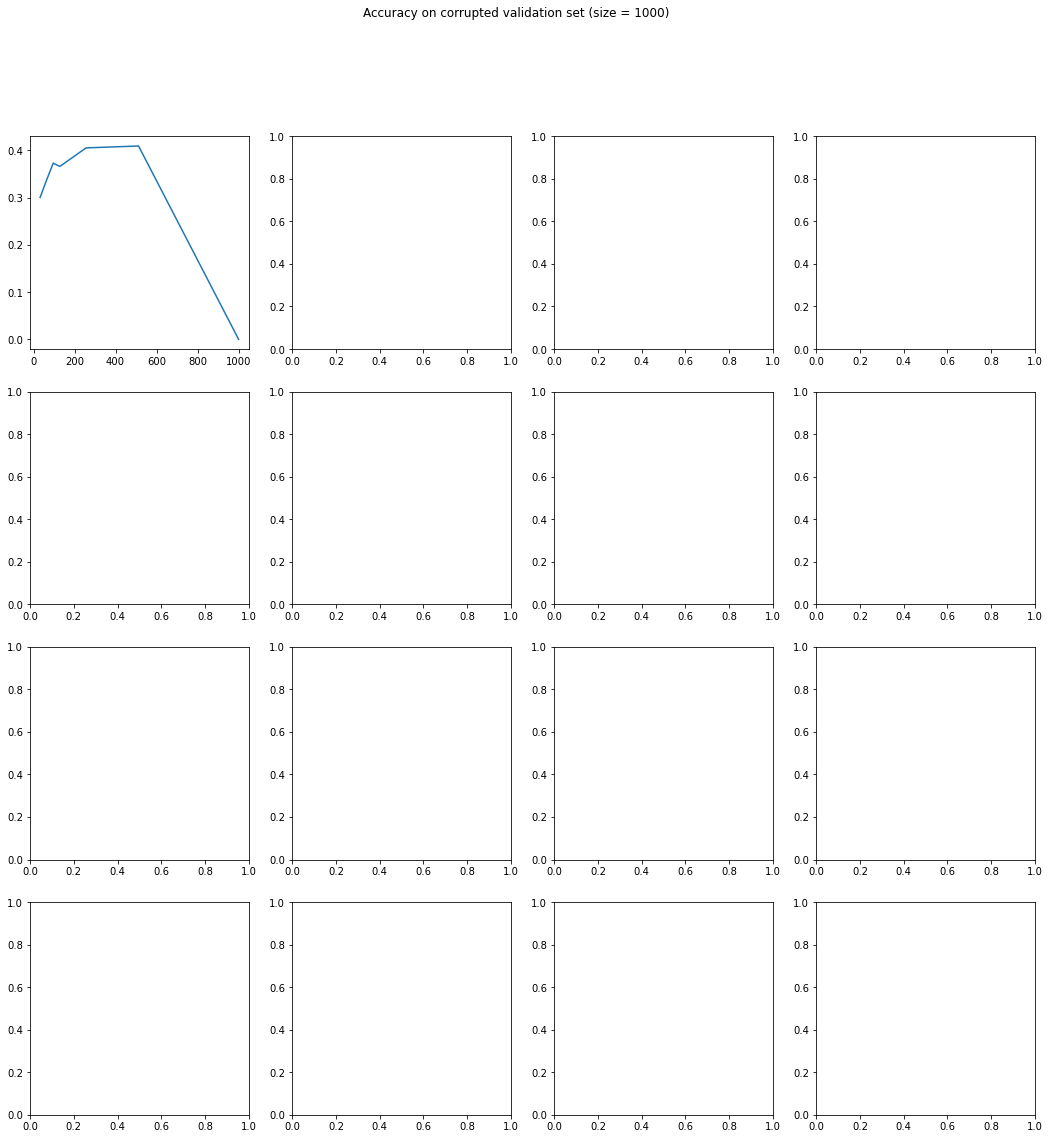

In [48]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted validation set (size = 1000)')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][4], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, baseline_performances[cor_ind][4], label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.7])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

NameError: name 'target_sizes' is not defined

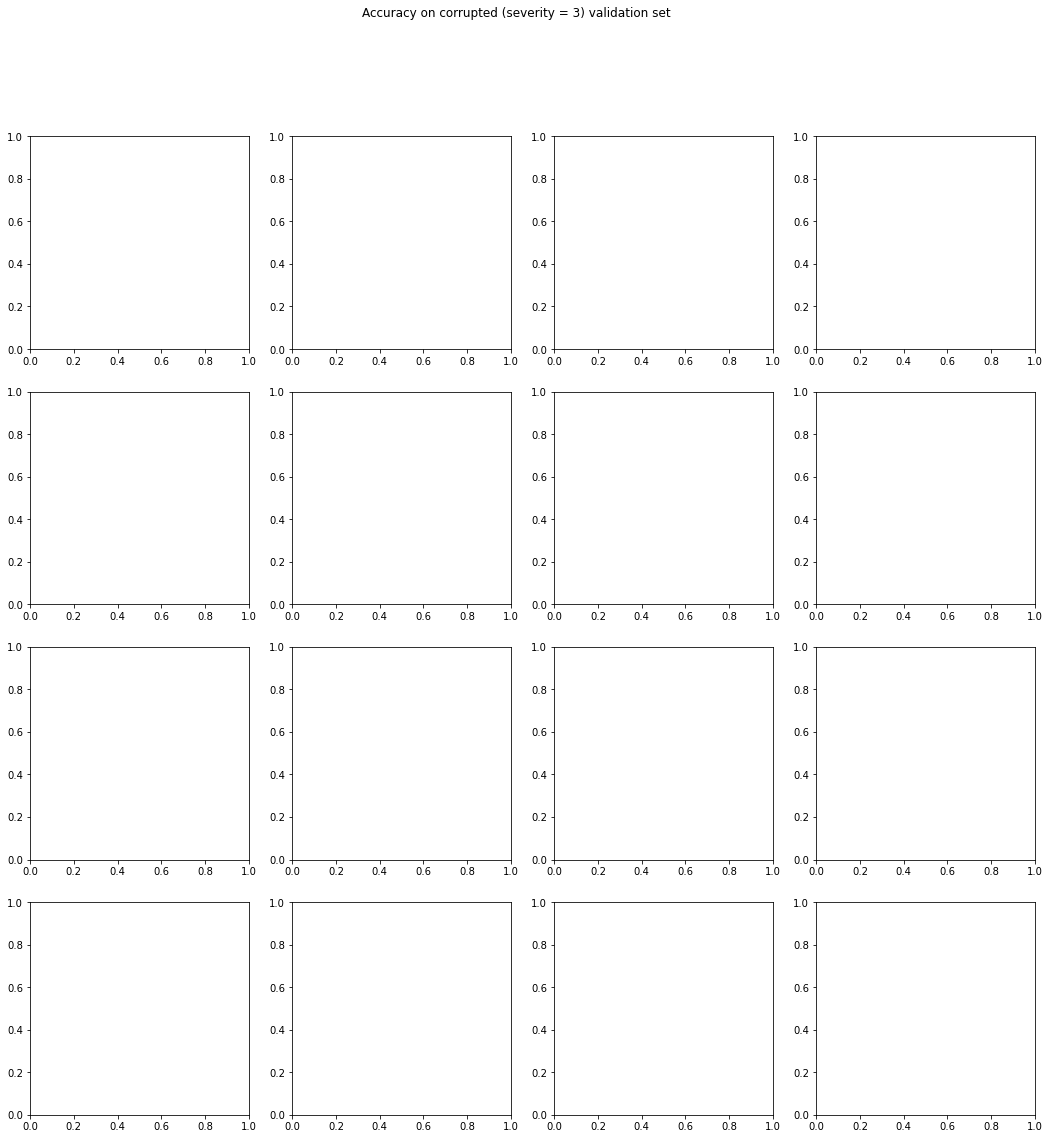

In [50]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted (severity = 3) validation set')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, baseline_performances[cor_ind][2], label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.9])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

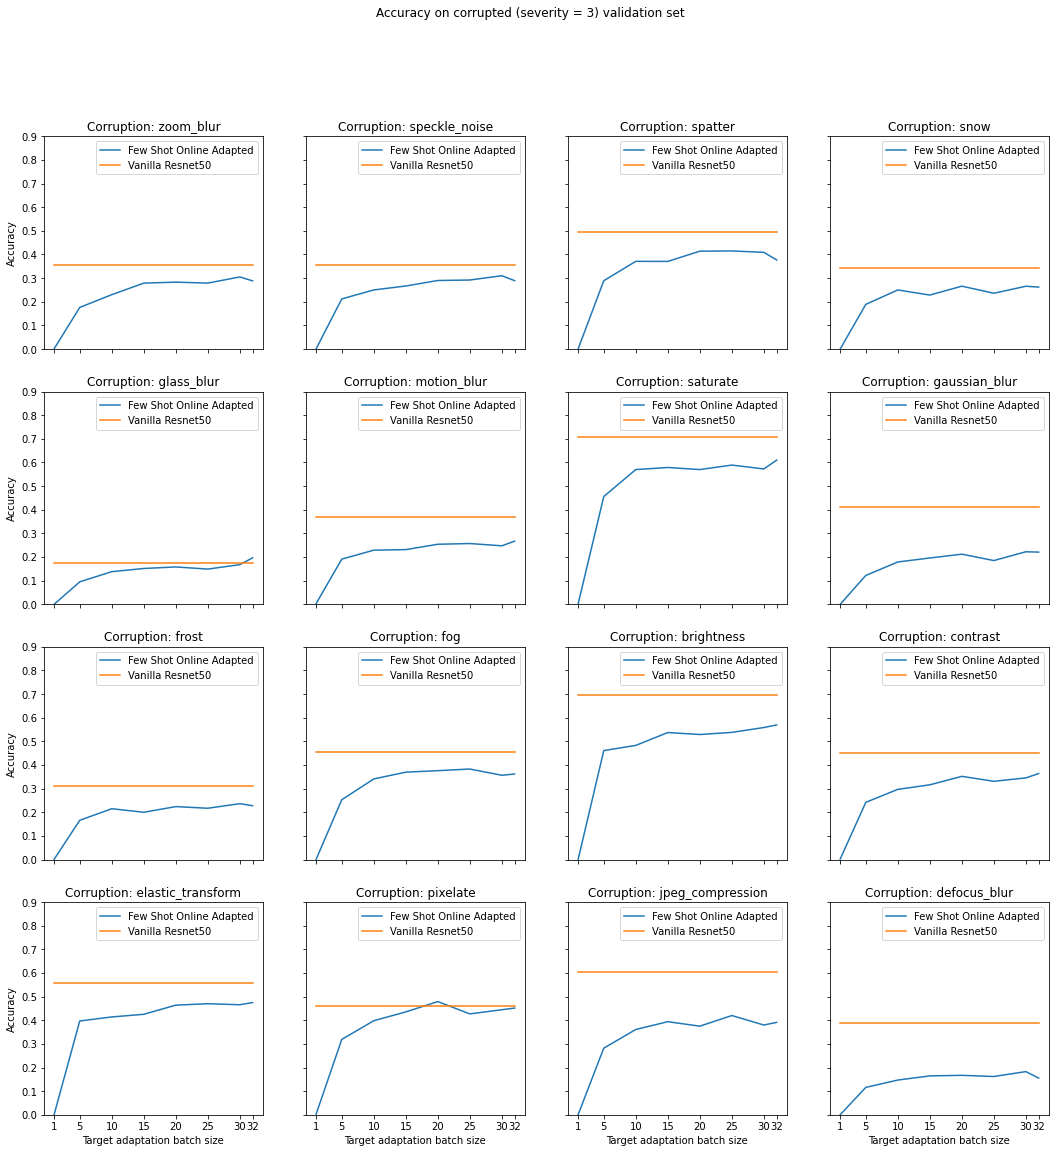

In [74]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted (severity = 3) validation set')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(shot_sizes, rpl_few_shot_acc[cor_ind][2], label='Few Shot Online Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(shot_sizes, baseline_performances[cor_ind][2][0].repeat(8), label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(shot_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.9])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [68]:
baseline_performances[1][2][0].repeat(8)

array([0.35483871, 0.35483871, 0.35483871, 0.35483871, 0.35483871,
       0.35483871, 0.35483871, 0.35483871])

In [25]:
ref_dataset_sizes

{'val': 1000, 'test': 1000}

In [26]:
len(ref_dataloaders['val'])


391

In [44]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in /home/zw2774/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
zoom_blur_loader = corrupted_dataloaders[0]['train']

In [56]:
corrects = 0
for images, labels in zoom_blur_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    corrects += torch.sum(preds == labels.data)
total_accuracy = corrects/corrupted_dataset_sizes[0]['train']

In [55]:
torch.sum(preds == y.data)

tensor(15)